In [1]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
from math import pi
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# colour palette
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
# Replace the color for 'ups' with a high contrast color
high_contrast_color = sns.color_palette("colorblind")[1]  # Example high contrast color
region_colors['ups'] = high_contrast_color

## INPUT DATA OF GLOBAL GRID

In [2]:
# Parameter selection
scenario_year = 2050

In [10]:
run_this_cell = True
if run_this_cell:
    # DISTIANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    cable_capacity = 1200 # MW
    cable_voltage = 1100 # kV
    cable_resistivity = 0.01286 # ohms/km
    converter_losses = 0.015 # [-]
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # SYNTHETIC -> excludes Europe
    path = "/Volumes/fi246disk/synde/resources/gegis/output"
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "north_america" and key != "europe" and key != "alaska":
            load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" ) # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36
    load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", "ssp1-26")
    load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa

    # RENEWABLE PROFILES
    res_potential_dic = {}
    for key, value in regions_dic.items():
        res_potential_dic[key] = {}
        res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=10, land_available=10)
        res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=10) # MW
    
    # Normalizing of RENEWABLE PROFILES
    for key, value in regions_dic.items():
        normalizing_factor_wind = res_potential_dic[key]["wind"].max()
        normalizing_factor_pv = res_potential_dic[key]["pv"].max()
        res_potential_dic[key]['factor_wind'] = normalizing_factor_wind
        res_potential_dic[key]['factor_pv'] = normalizing_factor_pv
        res_potential_dic[key]["wind_normalized"] = res_potential_dic[key]["wind"] / normalizing_factor_wind
        res_potential_dic[key]["pv_normalized"] = res_potential_dic[key]["pv"] / normalizing_factor_pv

## REGIONAL DEMAND PROFILES

In [19]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        load_series = load_profile_dic[key]["load"]
        ax = axs[idx]
        ax.plot(load_series, linewidth=0.6)
        ax.set_title(f'Electricity Demand {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Demand (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## REGIONAL VRE POTENTIAL PROFILES

In [20]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        pv_series = res_potential_dic[key]["pv"]
        wind_series = res_potential_dic[key]["wind"]
        demand_series = load_profile_dic[key]['load']
        ax = axs[idx]
        ax.plot(pv_series, linewidth=0.2, label='PV', color='gold')
        ax.plot(wind_series, linewidth=0.2, label='Wind', color='green')
        ax.plot(demand_series, linewidth=0.2, label='Demand')
        ax.set_title(f'VRE Potential {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Potential (MW)', fontsize=14)
        ax.set_yscale('log')
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        ax.legend()
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## PyPSA --> Create the grid 

In [11]:
# Parameter selection
cost_capacity_wind = 1
cost_capacity_pv = 1
cost_generation_wind = 100
cost_generation_pv = 100
cost_transmission = 1e-4
cost_curtailment = 0

# Initialise the network
n = pypsa.Network() 
snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
n.set_snapshots(snapshots)

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links 
# for key, value in links_dic.items():
#     n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
#     n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in res_potential_dic.items():
    n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
    n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
    n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

m = n.optimize.create_model();

n.optimize(solver_name='gurobi')


    

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]
INFO:linopy.io: Writing time: 3.6s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-d7ycpo2o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-d7ycpo2o.lp


Reading time = 1.31 seconds


INFO:gurobipy:Reading time = 1.31 seconds


obj: 797225 rows, 341679 columns, 1527911 nonzeros


INFO:gurobipy:obj: 797225 rows, 341679 columns, 1527911 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 797225 rows, 341679 columns and 1527911 nonzeros


INFO:gurobipy:Optimize a model with 797225 rows, 341679 columns and 1527911 nonzeros


Model fingerprint: 0x13304fda


INFO:gurobipy:Model fingerprint: 0x13304fda


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+02]


INFO:gurobipy:  Objective range  [1e+00, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 3e+10]


INFO:gurobipy:  RHS range        [2e+03, 3e+10]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 791435 rows and 341653 columns


INFO:gurobipy:Presolve removed 791435 rows and 341653 columns


Presolve time: 2.06s


INFO:gurobipy:Presolve time: 2.06s


Presolved: 26 rows, 5910 columns, 11781 nonzeros


INFO:gurobipy:Presolved: 26 rows, 5910 columns, 11781 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier performed 0 iterations in 2.12 seconds (1.21 work units)


INFO:gurobipy:Barrier performed 0 iterations in 2.12 seconds (1.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


      40    2.7219551e+13   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:      40    2.7219551e+13   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 40 iterations and 2.63 seconds (1.53 work units)


INFO:gurobipy:Solved in 40 iterations and 2.63 seconds (1.53 work units)


Optimal objective  2.721955113e+13


INFO:gurobipy:Optimal objective  2.721955113e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 341679 primals, 797225 duals
Objective: 2.72e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

# **ANALYSIS OF GLOBAL GRID**

## Plot generation and curtailment profiles 

In [ ]:
run_this_cell = True
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        generation_series = n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
        ax = axs[idx]
        ax.plot(generation_series, linewidth=0.6)
        ax.set_title(f'Generation {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Generation (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

    for idx, (key, value) in enumerate(regions_dic.items()):
        curtailment_series = n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
        ax = axs[idx]
        ax.plot(curtailment_series, linewidth=0.6)
        ax.set_title(f'Curtailment {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Curtailment (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## **Calculation of results**

## Caluclate Capacity, Generation, Curtailment and Demand

In [12]:
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
        regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
    
    regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
    regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
 
for key, value in regions_dic.items():
    # Generation data of each node
    for carrier in ["pv", "wind"]:
        series_g = n.generators_t.p[f"{carrier}_{key}"] * 1e-3 # GW
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # GW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # GWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # GW
        regions_dic[key][f"total_{carrier}_daily"] = series_g.groupby(series_g.index.date).sum() # GW
    # Curtailment data of each node
    series_c = n.generators_t.p[f"curtailment_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_curtailment_daily"] = series_c.groupby(series_c.index.date).sum() # GW
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # GW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # GWh
    # Demand data of each node
    series_l = n.loads_t.p[f"load_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # GWh
    
# Daily hourly values of specific days
dates = pd.to_datetime([f"{scenario_year}-03-21", f"{scenario_year}-06-21", f"{scenario_year}-09-21", f"{scenario_year}-12-21", f"{scenario_year}-04-06"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = n.generators_t.p[f"{carrier}_{key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = n.loads_t.p[f"load_{key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day
        regions_dic[key][f"houtly_curtailment_{date}"] = n.generators_t.p[f"curtailment_{key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day

## Hourly time series of generation, curtailment, and load

In [13]:
# Sum generation and loads of nodes
total_hourly_gen = pd.Series(0, index=n.snapshots)
total_hourly_wind = pd.Series(0, index=n.snapshots)
total_hourly_pv = pd.Series(0, index=n.snapshots)
total_hourly_cur = pd.Series(0, index=n.snapshots)
total_hourly_load = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_gen += n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
    total_hourly_cur += n.generators_t.p[f"curtailment_{key}"]
    total_hourly_pv += n.generators_t.p[f"pv_{key}"]
    total_hourly_wind += n.generators_t.p[f"wind_{key}"]
    total_hourly_load += n.loads_t.p[f"load_{key}"]
    
# Generation total
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Generation wind
total_daily_wind = total_hourly_wind.groupby(total_hourly_wind.index.date).sum()
total_monthly_wind = total_hourly_wind.groupby(total_hourly_wind.index.to_period('M')).sum()
total_annual_wind = total_hourly_wind.sum()

# Generation pv
total_daily_pv = total_hourly_pv.groupby(total_hourly_pv.index.date).sum()
total_monthly_pv = total_hourly_pv.groupby(total_hourly_pv.index.to_period('M')).sum()
total_annual_pv = total_hourly_pv.sum()

# Curtailment
total_daily_cur = total_hourly_cur.groupby(total_hourly_cur.index.date).sum()
total_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).sum()
total_annual_cur = total_hourly_cur.sum()

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()



## Calculation of global transmission and losses relative 

In [26]:
# Store hourly losses for each link in dictionary
for key, value in links_dic.items():
    p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
    p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
    abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
    p_trans = p0_0 + p0_1
    value["hourly_p_trans"] = p_trans
    value["hourly_abs_losses"] = abs_losses

# Sum the transmission and losses of the links
total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
total_hourly_p_trans = pd.Series(0, index=n.snapshots)
for key, value in links_dic.items():
    total_hourly_abs_losses += value["hourly_abs_losses"]
    total_hourly_p_trans += value["hourly_p_trans"]

# Absolute losses
total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
total_annual_abs_losses = total_hourly_abs_losses.sum()

# Power transmitted
total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
total_annual_p_trans = total_hourly_p_trans.sum()

# Relative losses to transmission
daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

# Statistics of the losses to transmission
mean_losses = total_hourly_abs_losses.mean()
std_losses = total_hourly_abs_losses.std()
daily_deviation = daily_rel_losses - daily_rel_losses.mean()
monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

# Losses relative to load
hourly_losses_rel_to_load = total_hourly_abs_losses / total_hourly_load
daily_losses_rel_to_load = total_daily_abs_losses / total_daily_load
monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

# Losses relative to gen
hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

# Curtailment relative to gen
hourly_cur_rel_to_gen = total_hourly_cur / total_hourly_gen
daily_cur_rel_to_gen = total_daily_cur / total_daily_gen
monthly_cur_rel_to_gen = total_monthly_cur / total_monthly_gen
annual_cur_rel_to_gen = total_annual_cur / total_annual_gen

# Curtailment relative to load
hourly_cur_rel_to_load = total_hourly_cur / total_hourly_load
daily_cur_rel_to_load = total_daily_cur / total_daily_load
monthly_cur_rel_to_load = total_monthly_cur / total_monthly_load
annual_cur_rel_to_load = total_annual_cur / total_annual_load

# Power transmitted rel to gen
hourly_p_trans_rel_gen = total_hourly_p_trans / total_hourly_gen
daily_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_gen
monthly_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_gen
annual_p_trans_rel_gen = total_hourly_p_trans.sum() / total_annual_gen

## Calculation of inflows and outflows and actualflow

In [27]:
# Calculate inflow, outflow, and 
for region_key, region_value in regions_dic.items():
    inflow = 0
    outflow = 0
    inflow_series = pd.Series(0, index=n.snapshots)
    outflow_series = pd.Series(0, index=n.snapshots)
    for link_key, link_value in links_dic.items():
        if region_value["bus"] == link_value["bus0"][0]: 
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p1_1 = abs(sum(p1_1))
            outflow += sum_p0_0
            inflow += sum_p1_1
            outflow_series += p0_0.abs()
            inflow_series += p1_1.abs()
        elif region_value["bus"] == link_value["bus1"][0]:
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_0 = n.links_t.p1[f"{link_value["name"]}_0"]
            sum_p0_1 = sum(p0_1.abs())
            sum_p1_0 = sum(p1_0.abs())
            outflow += sum_p0_1
            inflow += sum_p1_0
            outflow_series += p0_1.abs()
            inflow_series += p1_0.abs()
    netflow = (outflow - inflow) 
    netflow_series = (outflow_series - inflow_series) 
    region_value["inflow"] = inflow * 1e-3 # GW
    region_value["outflow"] = outflow * 1e-3 # GW
    region_value["inflow_series"] = inflow_series * 1e-3 # GW
    region_value["outflow_series"] = outflow_series * 1e-3 # GW
    region_value["netflow"] = netflow * 1e-3 # GW
    region_value["netflow_series"] = netflow_series * 1e-3 # GW
    region_value["actualflow"] = (outflow_series.abs() - inflow_series.abs()) * 1e-3 # GW
    region_value["actualflow"] = np.where(region_value["actualflow"] < 0, 0, region_value["actualflow"])
    region_value['total_actualflow'] = region_value["actualflow"].sum()



In [28]:
# Compute total power transmitted for each hour
total_actual_flow = pd.Series(0, index=n.snapshots)
total_actual_flow_int = 0
for key, value in regions_dic.items():
    total_actual_flow += value["actualflow"]
    total_actual_flow_int += value["total_actualflow"]

# Actual flow 
hourly_actual_flow_rel_gen = total_actual_flow / total_hourly_gen

def flow_direction(date=None):
    # Compute inflow, outflow direction per link
    flow_statements = {}
    netflows_links = {}
    netflows_links_series = {}
    for link_key, link_value in links_dic.items():
        if date == None:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p0_1 = abs(sum(p1_1))
            netflows_links[link_key] = abs(sum_p0_0 - sum_p0_1)
            netflows_links_series[link_key] = (p0_0 - p0_1) * 1e-3 #GW
            if sum_p0_0 > sum_p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        else:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"][date]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"][date]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"][date]
            net_flow = abs(p0_0 - p0_1)
            if p0_0 > p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        
    return flow_statements, netflows_links, netflows_links_series
flow_statements = flow_direction()[0]
netflows_links = flow_direction()[1]
netflows_links_series = flow_direction()[2]

# Calculation of monthly inflows and outflows
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')
month_to_period = {month: period for month, period in zip(months, month_periods)}
for i, month in enumerate(months):
    period = month_to_period[month]
    for region_key, region_value in regions_dic.items():
        inflow = 0
        outflow = 0
        for link_key, link_value in links_dic.items():
            if region_value["bus"] == link_value["bus0"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
            elif region_value["bus"] == link_value["bus1"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_1"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_0"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
        region_value[f"inflow_{month}"] = inflow * 1e-3 # GW
        region_value[f"outflow_{month}"] = outflow * 1e-3 # GW
        region_value[f"netflow_{month}"] = (inflow - outflow) * 1e-3 # GW

## Losses per node

In [29]:
for key, value in regions_dic.items():
    net_inflow = np.where(value["netflow_series"] > 0, 0, value["netflow_series"])
    annual_net_inflow = net_inflow.sum()
    annual_load = value['total_load_yearly']
    share_inflow_consumption = annual_net_inflow / annual_load * 100
    print(key, round(share_inflow_consumption, 2))

north_america -16.96
latin_america -3.23
oceania 0.0
north_asia -58.0
south_asia -57.2
north_west_asia 0.0
south_west_asia -48.1
middle_east -11.65
europe -27.48
ups -51.16
north_africa 0.0
africa -0.06
atlantic_north 0.0


# **Evaluation of results**

## Plotting of inflow and outflow series

In [30]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        inflow_series = - regions_dic[key]['inflow_series']
        ax = axs[idx]
        ax.plot(inflow_series, linewidth=0.6)
        ax.set_title(f'Inflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Inflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

    for idx, (key, value) in enumerate(regions_dic.items()):
        outflow_series = regions_dic[key]['outflow_series']
        ax = axs[idx]
        ax.plot(curtailment_series, linewidth=0.6)
        ax.set_title(f'Outflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Outflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## Overview of grid 

In [20]:
wind_share = total_annual_wind / total_annual_gen * 100
pv_share = 100 - wind_share
print('NO TRANSMISSION COST')
print(f'Total generation: {total_annual_gen:.2e}')
print(f'Wind: {round(wind_share, 1)} PV: {round(pv_share, 1)}')
print(f'Total curtailment: {total_annual_cur:.2e}')

NO TRANSMISSION COST
Total generation: 2.72e+11
Wind: 91.9 PV: 8.1
Total curtailment: 2.21e+11


## Regional share of wind and solar

In [15]:
for key, value in regions_dic.items():
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    #print(f'{key} Total Cap: {total_cap:.2e}, Total Gen: {total_gen:.2e}')
    print(f'{key} Wind Cap: {round(wind_cap_share, 2)}%, PV Cap: {round(pv_cap_share, 2)}%')
    print(f'{key} Wind Gen: {round(wind_gen_share, 2)}%, PV Cap: {round(pv_gen_share, 2)}%')

north_america Wind Cap: 73.17%, PV Cap: 26.83%
north_america Wind Gen: 82.98%, PV Cap: 17.02%
latin_america Wind Cap: 75.72%, PV Cap: 24.28%
latin_america Wind Gen: 84.23%, PV Cap: 15.77%
oceania Wind Cap: 60.63%, PV Cap: 39.37%
oceania Wind Gen: 71.38%, PV Cap: 28.62%
north_asia Wind Cap: 91.17%, PV Cap: 8.83%
north_asia Wind Gen: 93.67%, PV Cap: 6.33%
south_asia Wind Cap: 96.77%, PV Cap: 3.23%
south_asia Wind Gen: 95.92%, PV Cap: 4.08%
north_west_asia Wind Cap: 83.52%, PV Cap: 16.48%
north_west_asia Wind Gen: 89.32%, PV Cap: 10.68%
south_west_asia Wind Cap: 94.91%, PV Cap: 5.09%
south_west_asia Wind Gen: 94.1%, PV Cap: 5.9%
middle_east Wind Cap: 68.61%, PV Cap: 31.39%
middle_east Wind Gen: 75.02%, PV Cap: 24.98%
europe Wind Cap: 83.06%, PV Cap: 16.94%
europe Wind Gen: 90.47%, PV Cap: 9.53%
ups Wind Cap: 98.88%, PV Cap: 1.12%
ups Wind Gen: 99.22%, PV Cap: 0.78%
north_africa Wind Cap: 78.58%, PV Cap: 21.42%
north_africa Wind Gen: 86.18%, PV Cap: 13.82%
africa Wind Cap: 81.89%, PV Cap: 

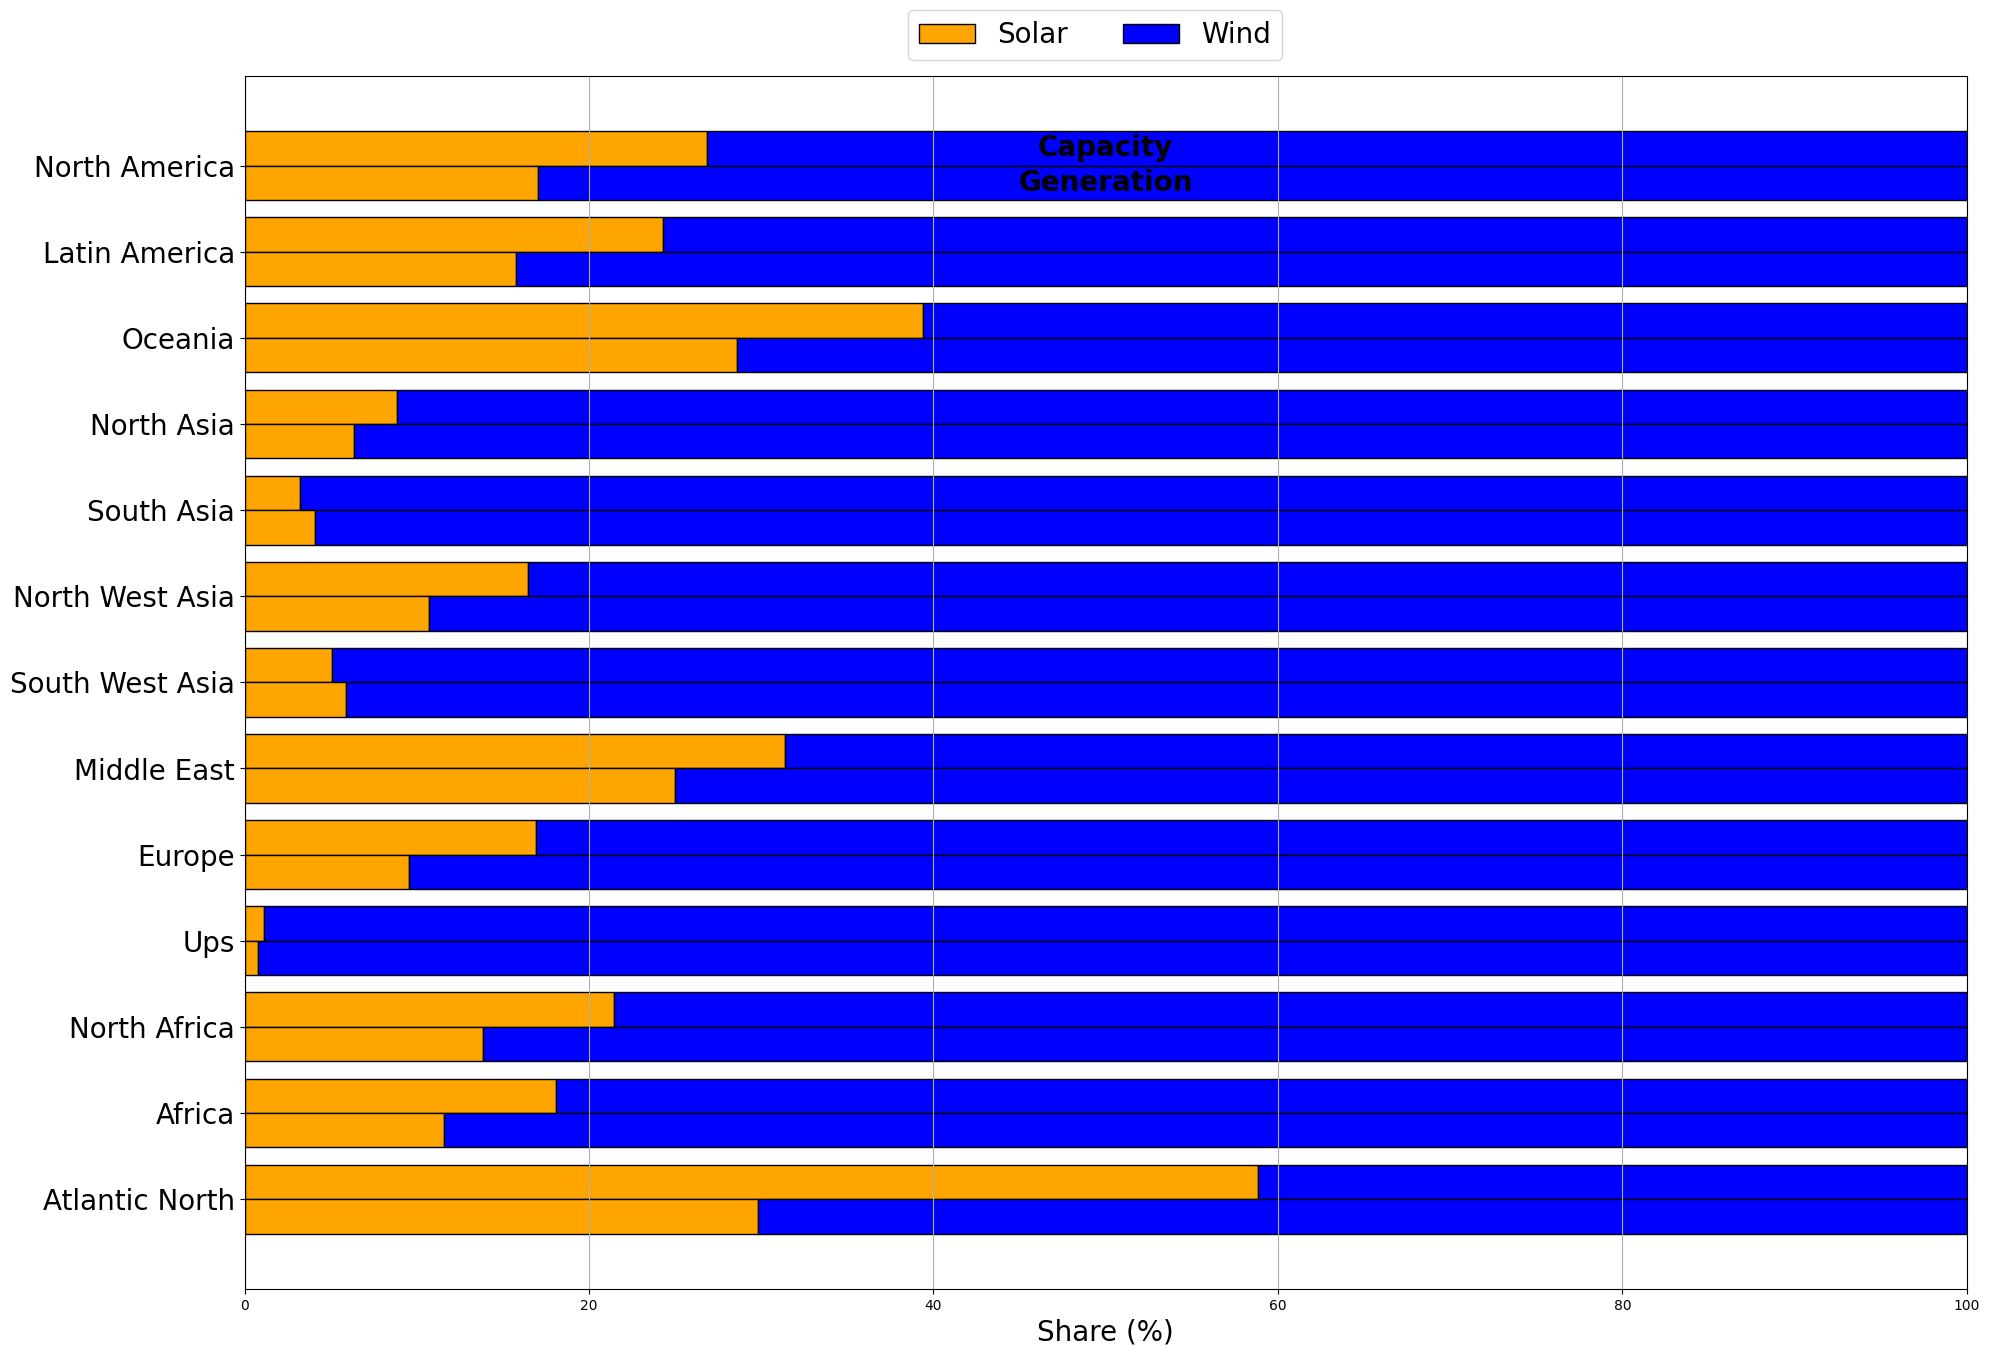

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate shares
regions = []
pv_cap_shares = []
wind_cap_shares = []
pv_gen_shares = []
wind_gen_shares = []

for key, value in regions_dic.items():
    regions.append(key)
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    pv_cap_shares.append(pv_cap_share)
    wind_cap_shares.append(wind_cap_share)
    pv_gen_shares.append(pv_gen_share)
    wind_gen_shares.append(wind_gen_share)

# Define the number of regions
num_regions = len(regions)

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, num_regions * 1))

# Bar width
bar_width = 0.4

# Plot Capacity shares
y_positions = np.arange(num_regions)
ax.barh(y_positions - bar_width/2, pv_cap_shares, height=bar_width, color='orange', edgecolor='black', label='Solar')
ax.barh(y_positions - bar_width/2, wind_cap_shares, height=bar_width, left=pv_cap_shares, color='blue', edgecolor='black', label='Wind')

# Plot Generation shares
ax.barh(y_positions + bar_width/2, pv_gen_shares, height=bar_width, color='orange', edgecolor='black')
ax.barh(y_positions + bar_width/2, wind_gen_shares, height=bar_width, left=pv_gen_shares, color='blue', edgecolor='black')

# Customizing the plot
formatted_regions = [region.replace('_', ' ').title() for region in regions]
ax.set_yticks(y_positions)
ax.set_yticklabels(formatted_regions, fontsize=20)
ax.set_xlim(0, 100)
ax.set_xlabel('Share (%)', fontsize=20)
ax.invert_yaxis()

# Add text annotations for capacity and generation
for i, (pv_cap, wind_cap, pv_gen, wind_gen) in enumerate(zip(pv_cap_shares, wind_cap_shares, pv_gen_shares, wind_gen_shares)):
    ax.text(50, i - bar_width/2, 'Capacity', ha='center', va='center', color='black', fontweight='bold', fontsize=20)
    ax.text(50, i + bar_width/2, 'Generation', ha='center', va='center', color='black', fontweight='bold', fontsize=20)
    break

# Add gridlines only for the x-axis
ax.grid(True, axis='x')

# Add the legend above the plot
plt.figlegend(loc='upper center', bbox_to_anchor=(0.55, 1.05), ncol=2, fontsize=20)

plt.tight_layout()
plt.show()


## Plotting of monthly regional data

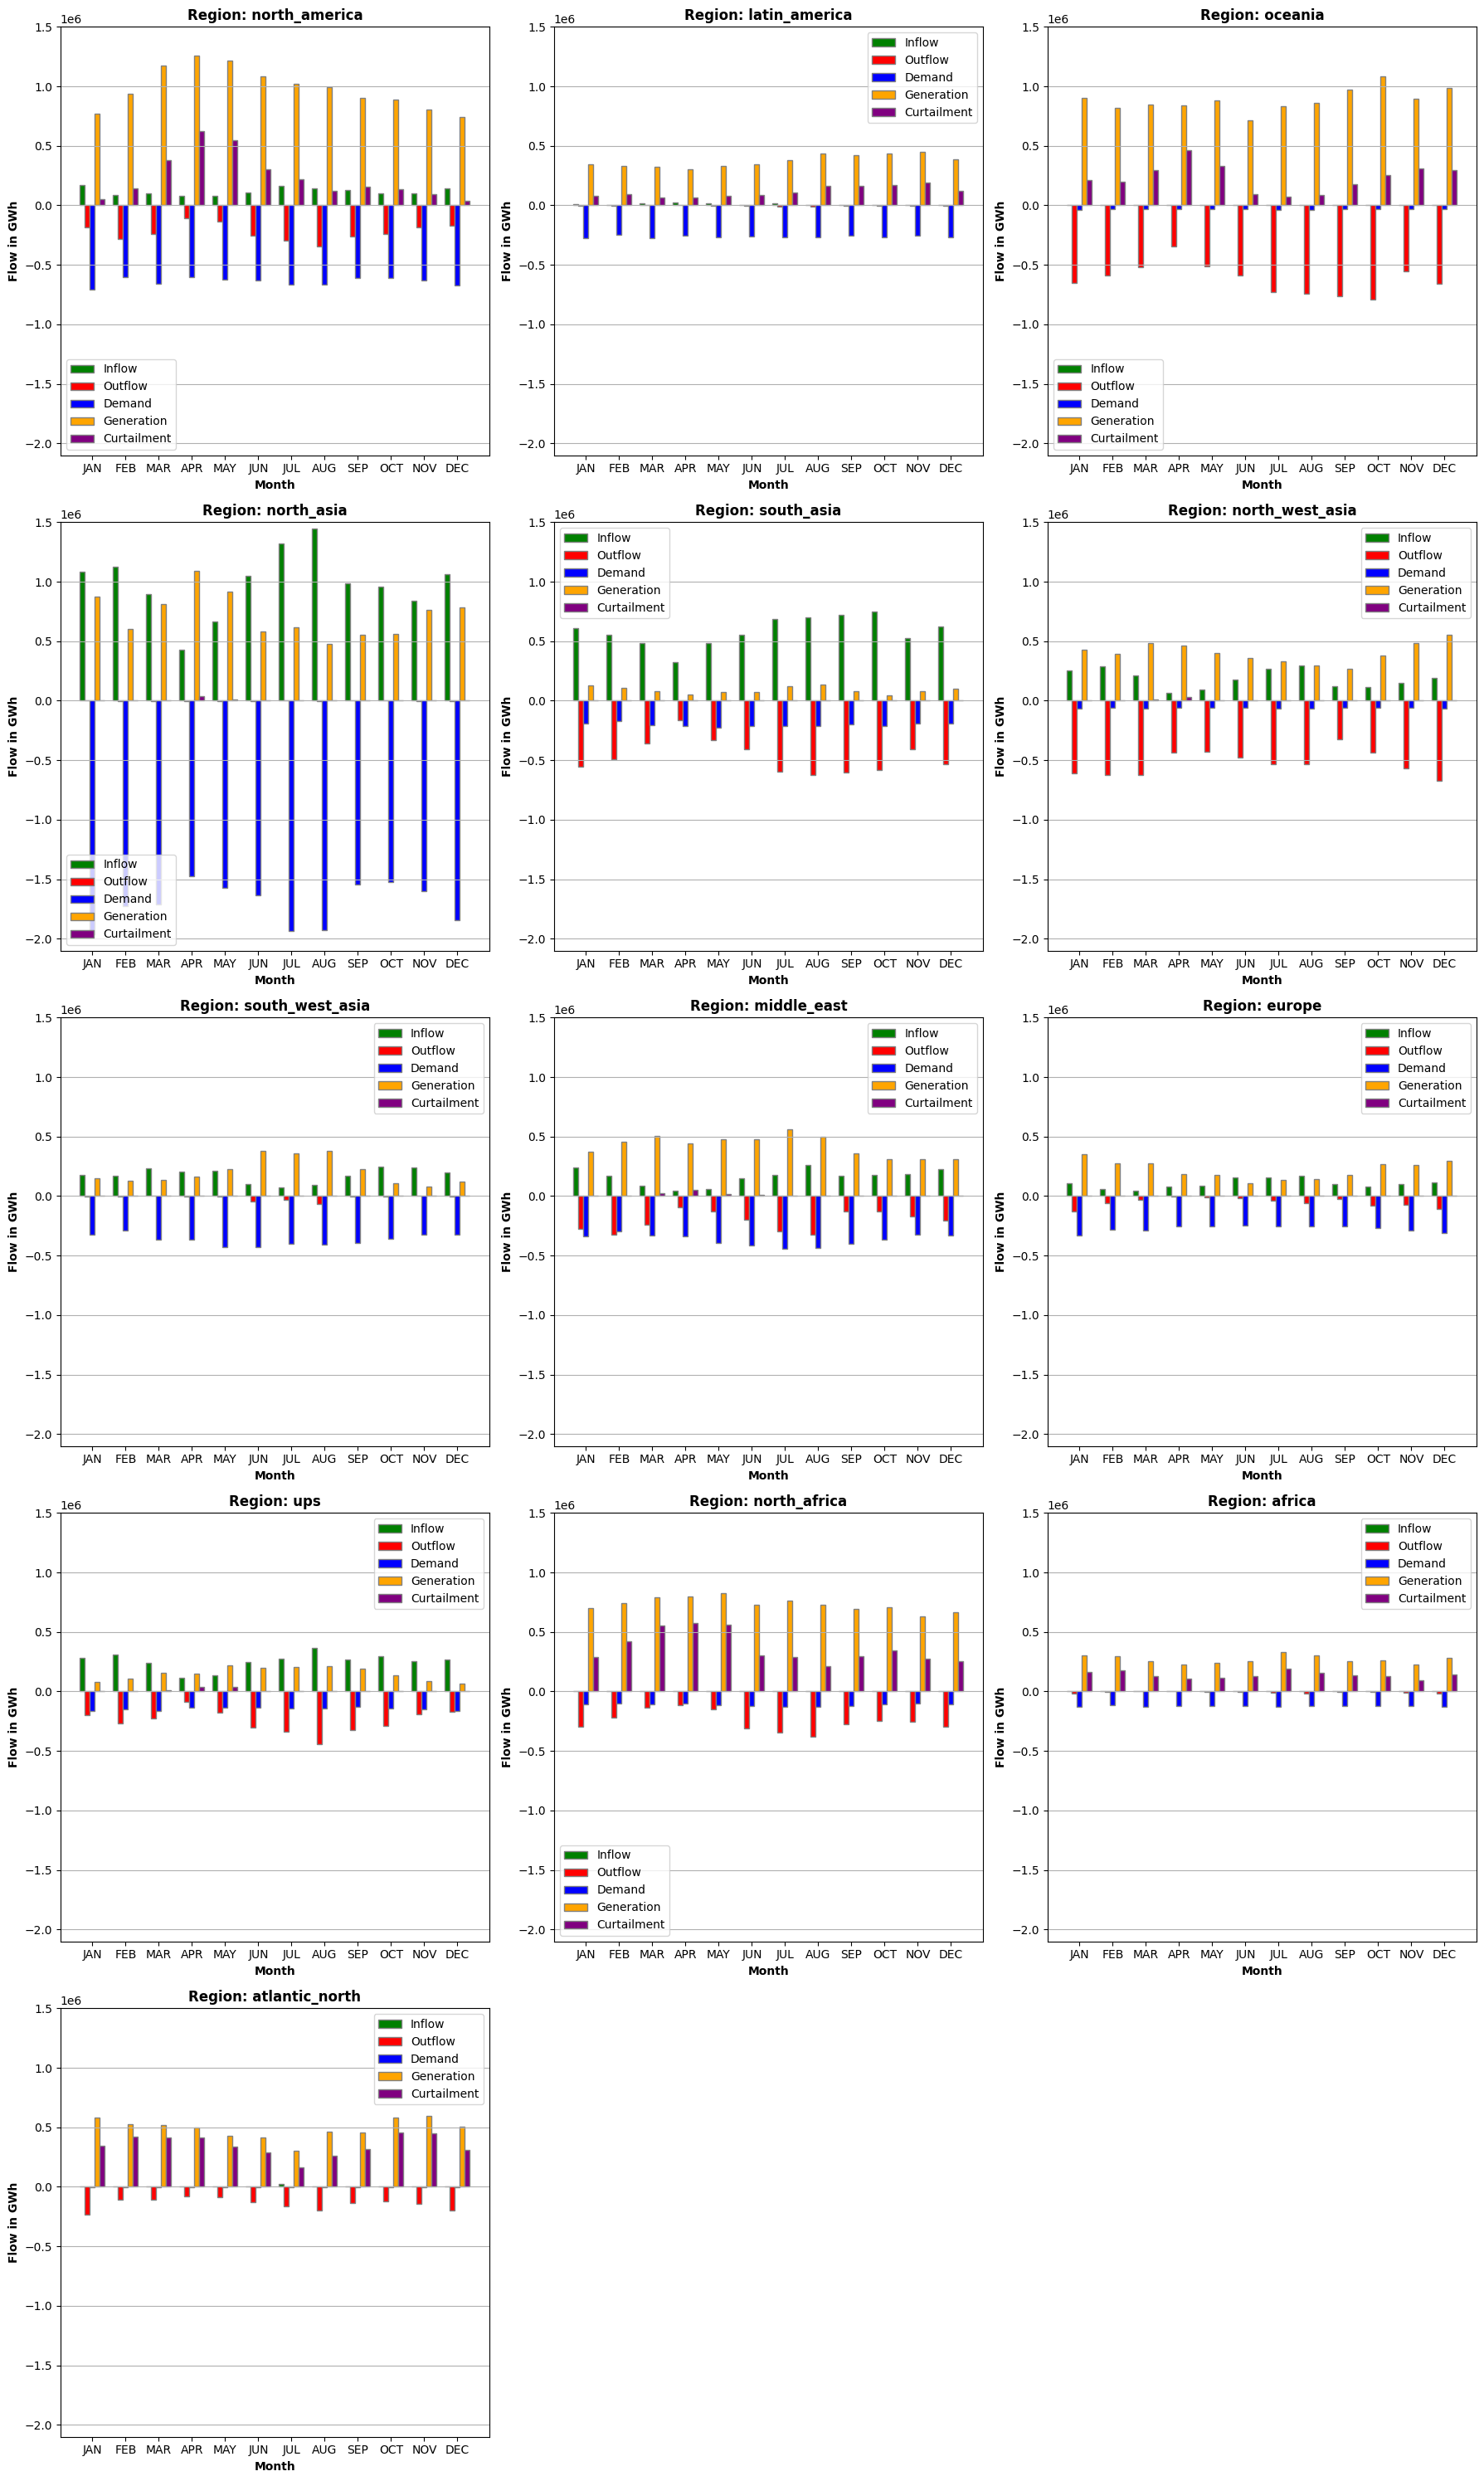

In [34]:
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')

def plot_region_monthly_data(region_key, region_value, ax):
    inflows = [region_value[f'inflow_{month}'] for month in months]
    outflows = [region_value[f'outflow_{month}'] for month in months]
    loads = [region_value[f'total_load_monthly'].loc[period] for period in month_periods]
    generations = [(region_value[f'total_pv_monthly'].loc[period] + region_value[f'total_wind_monthly'].loc[period]) for period in month_periods]
    curtailments = [region_value[f'total_curtailment_monthly'].loc[period] for period in month_periods]

    bar_width = 0.15
    r1 = range(len(months))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    ax.grid(False)
    ax.bar(r1, inflows, color='green', width=bar_width, edgecolor='grey', label='Inflow')
    ax.bar(r2, [-outflow for outflow in outflows], color='red', width=bar_width, edgecolor='grey', label='Outflow')
    ax.bar(r3, [-load for load in loads], color='blue', width=bar_width, edgecolor='grey', label='Demand')
    ax.bar(r4, generations, color='orange', width=bar_width, edgecolor='grey', label='Generation')
    ax.bar(r5, curtailments, color='purple', width=bar_width, edgecolor='grey', label='Curtailment')

    ax.set_xlabel('Month', fontweight='bold')
    ax.set_ylabel('Flow in GWh', fontweight='bold')
    ax.set_ylim(-2.1e6, 1.5e6)
    ax.set_title(f'Region: {region_key}', fontweight='bold')
    ax.set_xticks([r + 2*bar_width for r in range(len(months))])
    ax.set_xticklabels(months)
    ax.grid(True, axis='y')
    ax.legend()

num_plots = len(regions_dic)
rows = (num_plots + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axs = axs.flatten()

for idx, (region_key, region_value) in enumerate(regions_dic.items()):
    plot_region_monthly_data(region_key, region_value, axs[idx])

for idx in range(len(regions_dic), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()


## Tornado plot of annual regional data in 

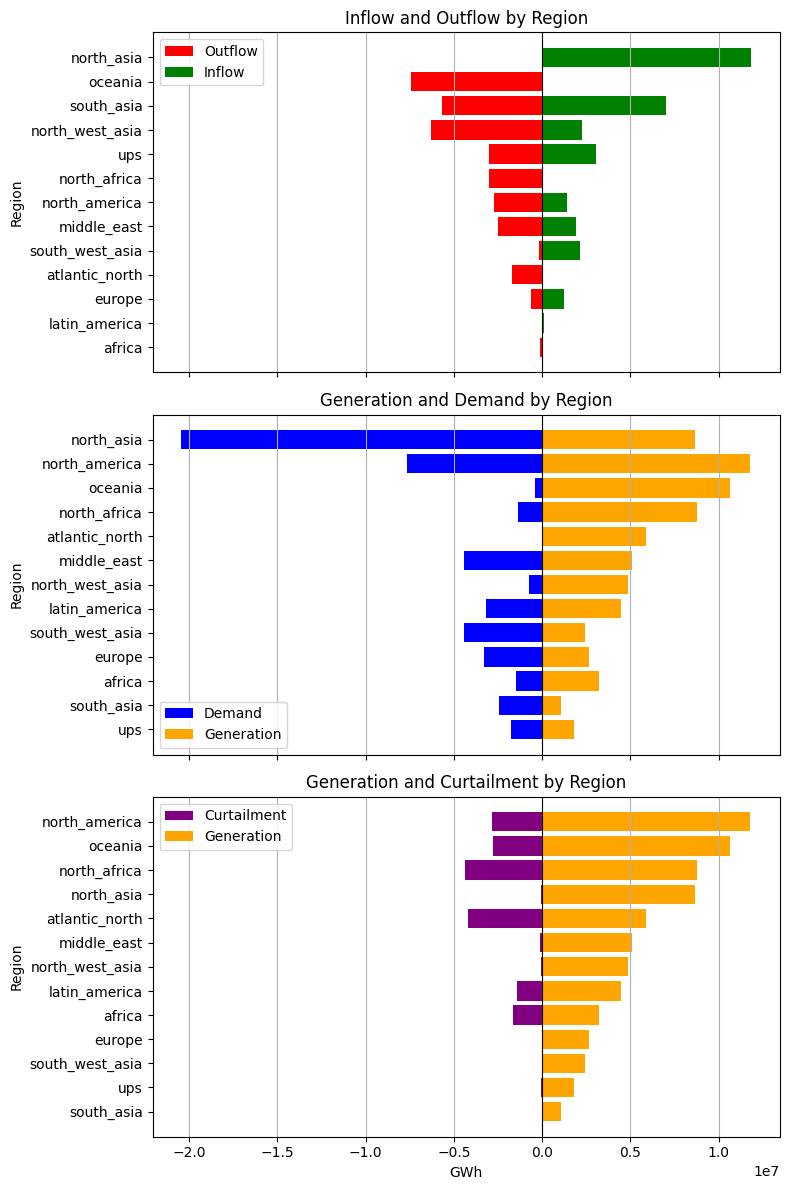

In [35]:
inflow_outflow_data = [
    (region_key, region_value['inflow'], region_value['outflow'])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_demand_data = [
    (region_key, region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_load_yearly'])
    for region_key, region_value in regions_dic.items()
]
generation_demand_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_curtailment_data = [
    (region_key, region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_curtailment_yearly'])
    for region_key, region_value in regions_dic.items()
]
generation_curtailment_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1] for item in inflow_outflow_data]
outflows = [item[2] for item in inflow_outflow_data]

regions_generation_demand = [item[0] for item in generation_demand_data]
generations_demand = [item[1] for item in generation_demand_data]
demands = [item[2] for item in generation_demand_data]

regions_generation_curtailment = [item[0] for item in generation_curtailment_data]
generations_curtailment = [item[1] for item in generation_curtailment_data]
curtailments = [item[2] for item in generation_curtailment_data]

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

axs[0].barh(regions_inflow_outflow, [-outflow for outflow in outflows], color='red', label='Outflow')
axs[0].barh(regions_inflow_outflow, inflows, color='green', label='Inflow')
axs[0].axvline(x=0, color='black', linewidth=0.8)
#axs[0].set_xlim(-2.2e7, 2.2e7)
axs[0].set_ylabel('Region')
axs[0].set_title('Inflow and Outflow by Region')
axs[0].grid(True, axis='x')
axs[0].legend()
axs[0].invert_yaxis()

axs[1].barh(regions_generation_demand, [-demand for demand in demands], color='blue', label='Demand')
axs[1].barh(regions_generation_demand, generations_demand, color='orange', label='Generation')
axs[1].axvline(x=0, color='black', linewidth=0.8)
#axs[1].set_xlim(-2.2e7, 2.2e7)
axs[1].set_ylabel('Region')
axs[1].set_title('Generation and Demand by Region')
axs[1].grid(True, axis='x')
axs[1].legend()
axs[1].invert_yaxis()

axs[2].barh(regions_generation_curtailment, [-curtailment for curtailment in curtailments], color='purple', label='Curtailment')
axs[2].barh(regions_generation_curtailment, generations_curtailment, color='orange', label='Generation')
axs[2].axvline(x=0, color='black', linewidth=0.8)
#axs[2].set_xlim(-2.2e7, 2.2e7)
axs[2].set_xlabel('GWh')
axs[2].set_ylabel('Region')
axs[2].set_title('Generation and Curtailment by Region')
axs[2].grid(True, axis='x')
axs[2].legend()
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


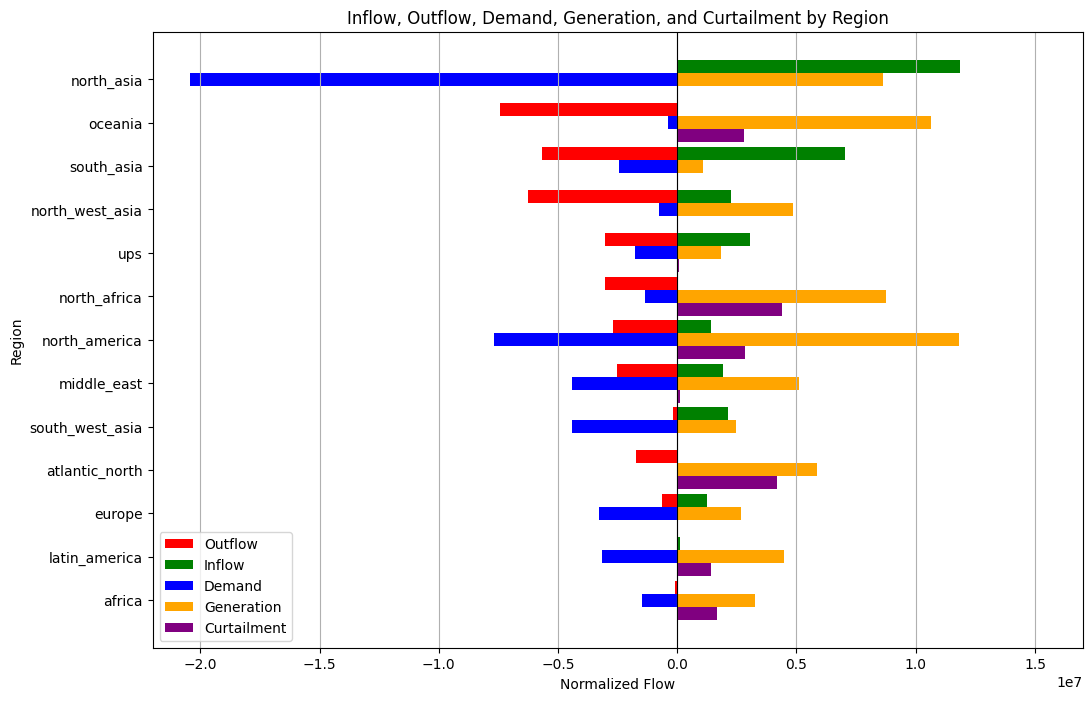

In [36]:
regions_data = [
    (
        region_key,
        region_value['inflow'],  
        region_value['outflow'],  
        region_value['total_load_yearly'],  
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  
        region_value['total_curtailment_yearly'], 
        max(
            abs(region_value['inflow']),
            abs(region_value['outflow'])
        ) 
    )
    for region_key, region_value in regions_dic.items()
]

regions_data.sort(key=lambda x: x[6], reverse=False)

regions = [item[0] for item in regions_data]
inflows = [item[1] for item in regions_data]
outflows = [item[2] for item in regions_data]
loads = [item[3] for item in regions_data]
generations = [item[4] for item in regions_data]
curtailments = [item[5] for item in regions_data]

fig, ax = plt.subplots(figsize=(12, 8))

y_positions = range(len(regions))

ax.barh([y + 0.3 for y in y_positions], [-outflow for outflow in outflows], color='red', label='Outflow', height=0.3)
ax.barh([y + 0.3 for y in y_positions], inflows, color='green', label='Inflow', height=0.3)
ax.barh([y for y in y_positions], [-load for load in loads], color='blue', label='Demand', height=0.3)
ax.barh([y for y in y_positions], generations, color='orange', label='Generation', height=0.3)
ax.barh([y - 0.3 for y in y_positions], curtailments, color='purple', label='Curtailment', height=0.3)

ax.axvline(x=0, color='black', linewidth=0.8)

ax.grid(False, axis='y')
ax.grid(True, axis='x')

ax.set_xlabel('Normalized Flow')
ax.set_xlim(-2.2e7, 1.7e7)
ax.set_ylabel('Region')
ax.set_title('Inflow, Outflow, Demand, Generation, and Curtailment by Region')
ax.set_yticks([y for y in y_positions])
ax.set_yticklabels(regions)
ax.legend()

plt.show()


## Spyder diagramms of annual regional data

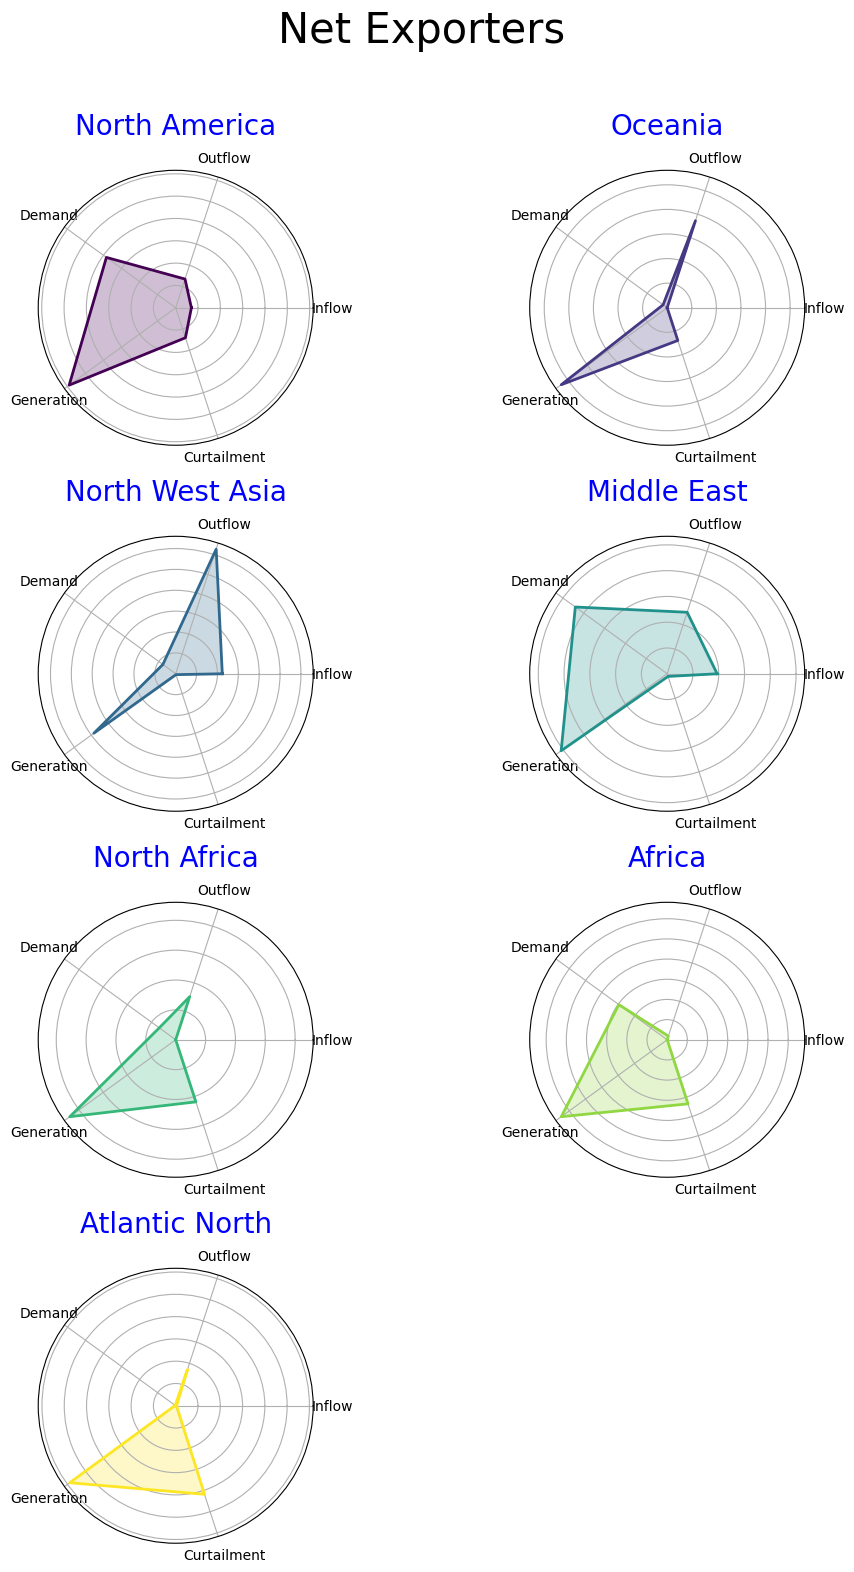

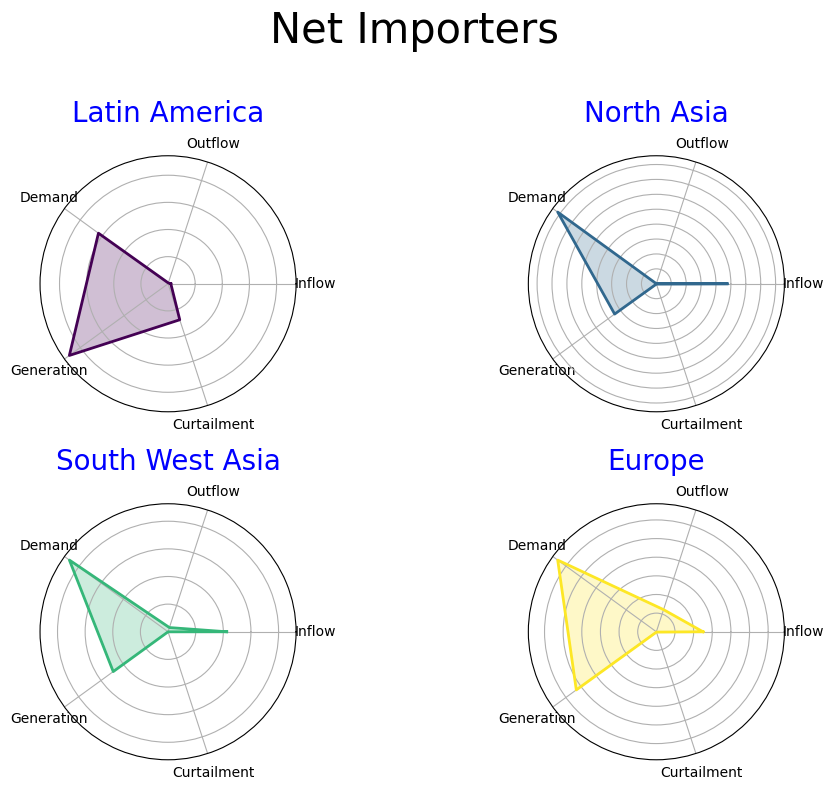

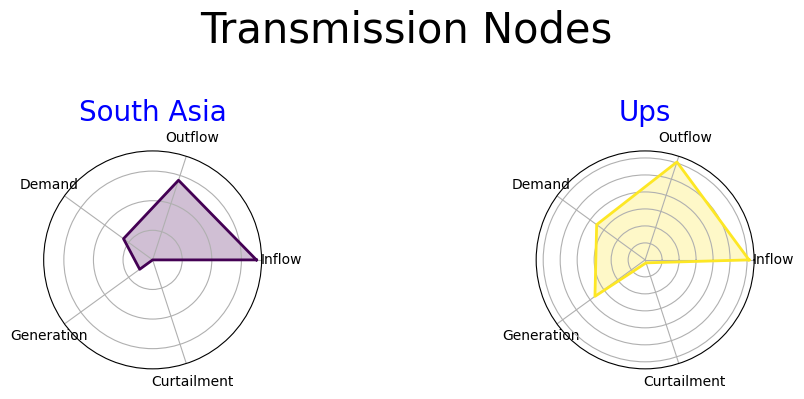

In [37]:
data = {
    region_key: [
        region_value['inflow'],  # Normalize to generation
        region_value['outflow'],  # Normalize to generation
        (region_value['total_load_yearly']),  # Normalize to generation
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  # Generation normalized to itself
        region_value['total_curtailment_yearly']  # Normalize to generation
    ]
    for region_key, region_value in regions_dic.items()
}

variables = ['Inflow', 'Outflow', 'Demand', 'Generation', 'Curtailment']
df = pd.DataFrame(data, index=variables)

tolerance = 0.25
exporters = []
importers = []
transmission_nodes = []

for region in df.columns:
    inflow = df[region]['Inflow']
    outflow = df[region]['Outflow']
    if inflow > outflow * (1 + tolerance):
        importers.append(region)
    elif outflow > inflow * (1 + tolerance):
        exporters.append(region)
    elif inflow != 0 and outflow != 0 and abs(inflow - outflow) <= tolerance * max(inflow, outflow):
        transmission_nodes.append(region)

def plot_radar_charts(regions, title):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    num_regions = len(regions)
    n_cols = 2
    n_rows = (num_regions + 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), subplot_kw=dict(polar=True))
    axs = axs.flatten()
    colors = plt.cm.viridis(np.linspace(0, 1, num_regions))

    for i, (region, color) in enumerate(zip(regions, colors)):
        values = df[region].tolist()
        values += values[:1]
        ax = axs[i]
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
        ax.fill(angles, values, color=color, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(variables)
        ax.set_yticklabels([])
        formatted_title = format_title(region)
        ax.set_title(formatted_title, size=20, color='blue', y=1.1)

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle(title, size=30, color='black')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def format_title(title):
    return ' '.join(word.capitalize() for word in title.split('_'))

plot_radar_charts(exporters, 'Net Exporters')
plot_radar_charts(importers, 'Net Importers')

if transmission_nodes:
    plot_radar_charts(transmission_nodes, 'Transmission Nodes')


## Chord diagram of netflows 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
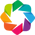

:Chord   [source,target]   (value)

In [38]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim

hv.extension('bokeh')
hv.output(size=200)
# Calculate total flow for each link and store in data frame
link_flow_data = []
for link_key, link_value in links_dic.items():
    p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
    p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
    sum_p0_0 = abs(sum(p0_0))
    sum_p0_1 = abs(sum(p0_1))
    net_flow = sum_p0_0 - sum_p0_1
    if net_flow > 0:
        bus0 = link_value["bus0"][1]
        bus1 = link_value["bus1"][1]
    else:
        bus0 = link_value["bus1"][1]
        bus1 = link_value["bus0"][1]
    link_flow_data.append((bus0, bus1, abs(net_flow)))
links = pd.DataFrame(link_flow_data, columns=['source', 'target', 'value'])

# Convert the keys of the dictionary to a list and create a DataFrame
regions_df = pd.DataFrame(list(regions_dic.keys()), columns=['index'])

# Create a Dataset for nodes
nodes = hv.Dataset(regions_df, 'index')

chord = hv.Chord((links, nodes)).select(value=(100, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='index', node_color=dim('index').str()))

## Global Generation and demand graphs

In [31]:

weeks[0]= 0

TypeError: Index does not support mutable operations

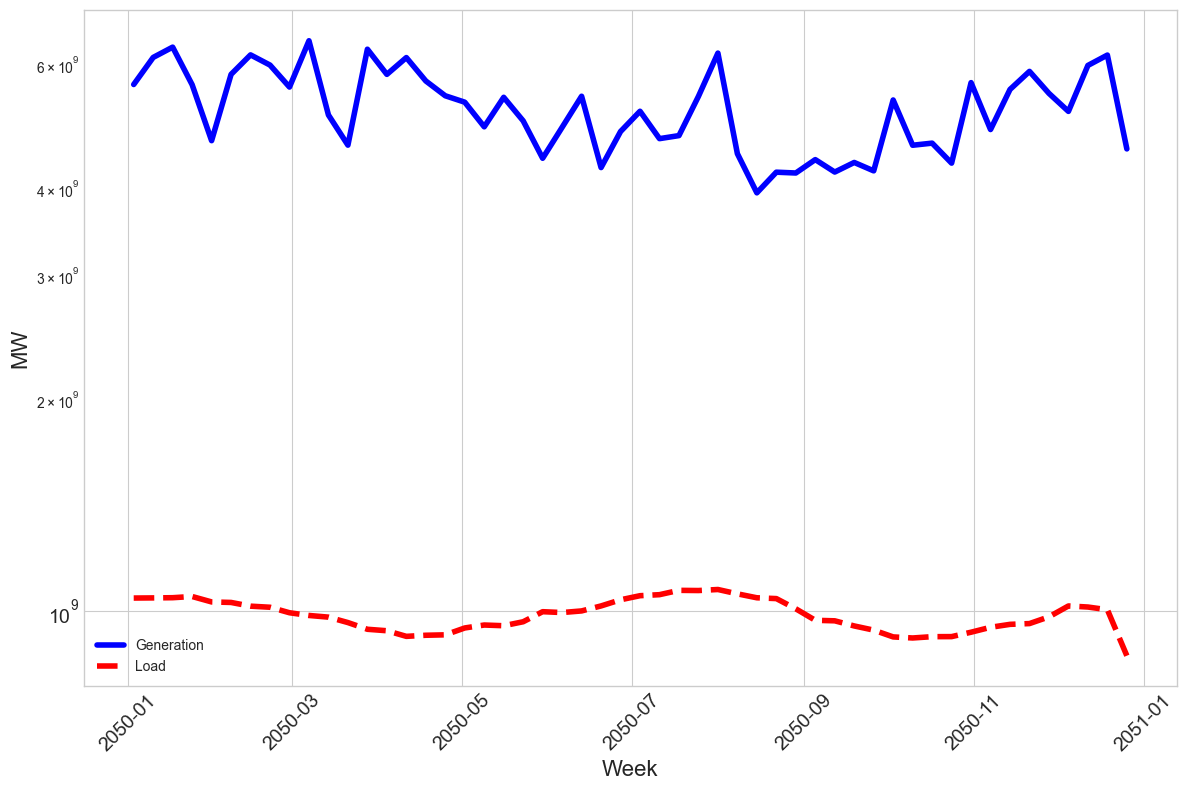

In [37]:
# Group by week and sum the values
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum()
total_weekly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('W')).sum()

# Remove the first entry
total_weekly_gen = total_weekly_gen.iloc[1:]
total_weekly_load = total_weekly_load.iloc[1:]
# Extract the week numbers and values
weeks = total_weekly_gen.index.to_timestamp()  # Convert period index to timestamp for plotting
values_gen = total_weekly_gen.values
values_load = total_weekly_load.values

# Plotting
plt.figure(figsize=(12, 8))

# Plot load on top
plt.plot(weeks, values_gen, label='Generation', linestyle='-', color='blue', linewidth=4)
plt.plot(weeks, values_load, label='Load', linestyle='--', color='red', linewidth=4)
plt.xlabel('Week', fontsize=16)
plt.ylabel('MW', fontsize=16)
plt.legend()  # Add a legend to the plot

# Customize ticks
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)
plt.yscale('log')

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

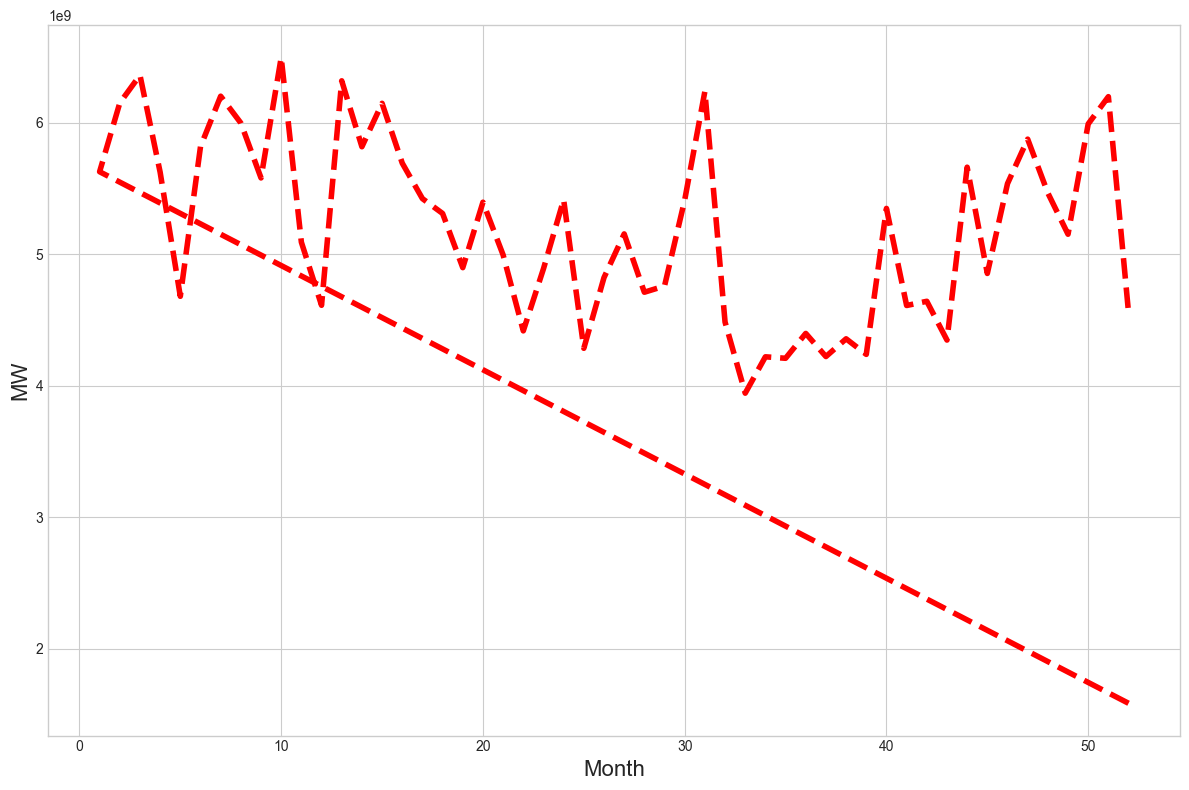

In [29]:

total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum()
weeks = total_weekly_gen.index.week
# Extract values and months
weeks = total_weekly_gen.index.week

plt.figure(figsize=(12, 8))


# Plot load on top
plt.plot(weeks, total_weekly_gen.values, label='Load', linestyle='--', color='red', linewidth=4)
plt.xlabel('Week', fontsize=16)
plt.ylabel('MW', fontsize=16)
    #text.set_fontweight('bold')  # Make legend text bold
# Customize ticks
# Tight layout to ensure everything fits without overlapping
plt.tight_layout()


# Show the plot
plt.show()


In [34]:
# Group by week and sum the values
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum()

# Reset index to get a DataFrame
total_weekly_gen = total_weekly_gen.reset_index()

# Extract the week numbers from the period index
total_weekly_gen['Week'] = total_weekly_gen['index'].apply(lambda x: x.week)

# Remove any week 0 entries (if they exist)
total_weekly_gen = total_weekly_gen[total_weekly_gen['Week'] != 0]

# Extract the week numbers and values
weeks = total_weekly_gen['Week']
values = total_weekly_gen[0]  # Assuming the data values are in the first column

# Plotting
plt.figure(figsize=(12, 8))

# Plot load on top
plt.plot(weeks, values, label='Load', linestyle='--', color='red', linewidth=4)
plt.xlabel('Week', fontsize=16)
plt.ylabel('MW', fontsize=16)
plt.legend()  # Add a legend to the plot

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

KeyError: 'index'

## Demand and supply graphs of each regions


north_america


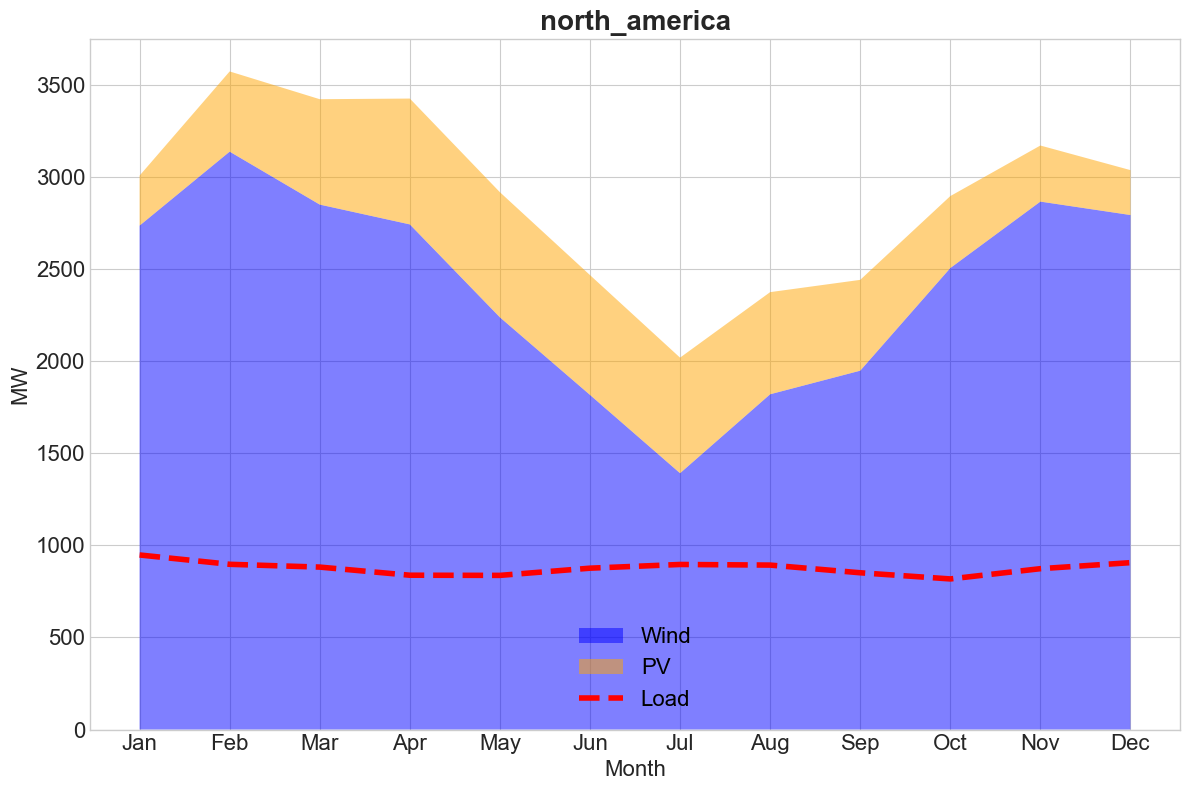

latin_america


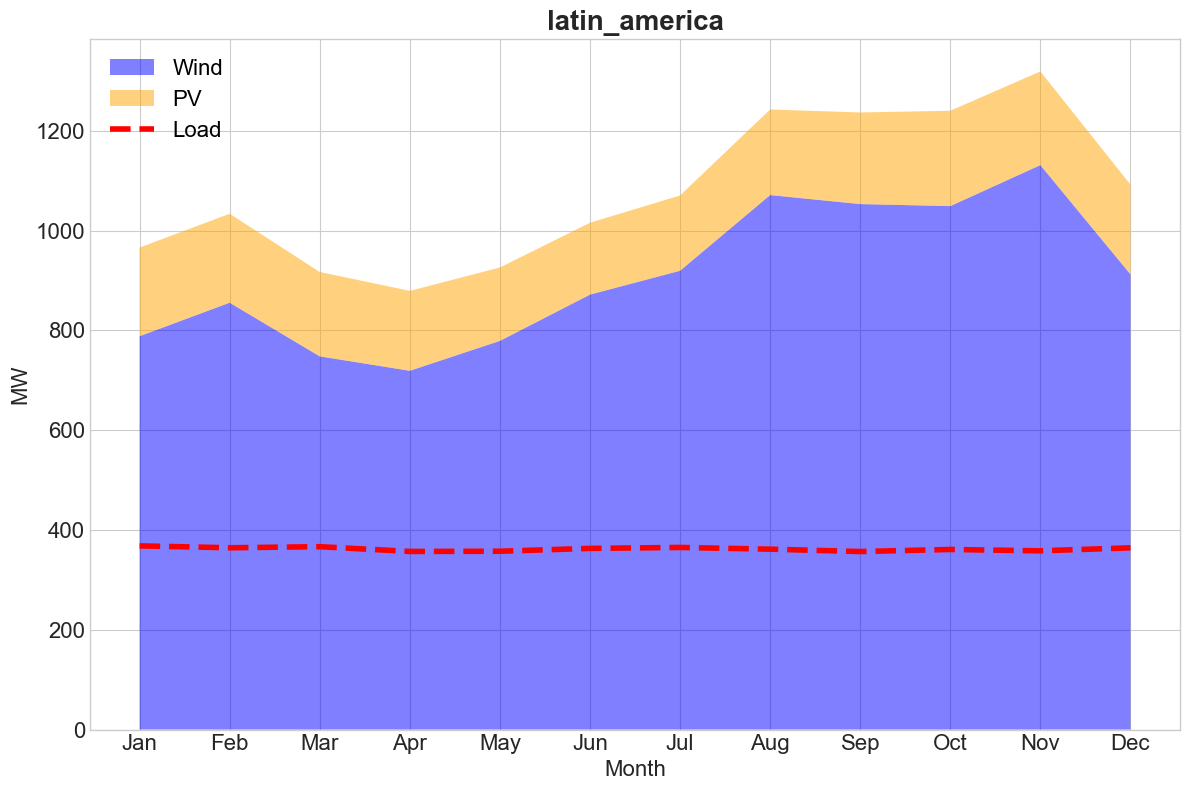

oceania


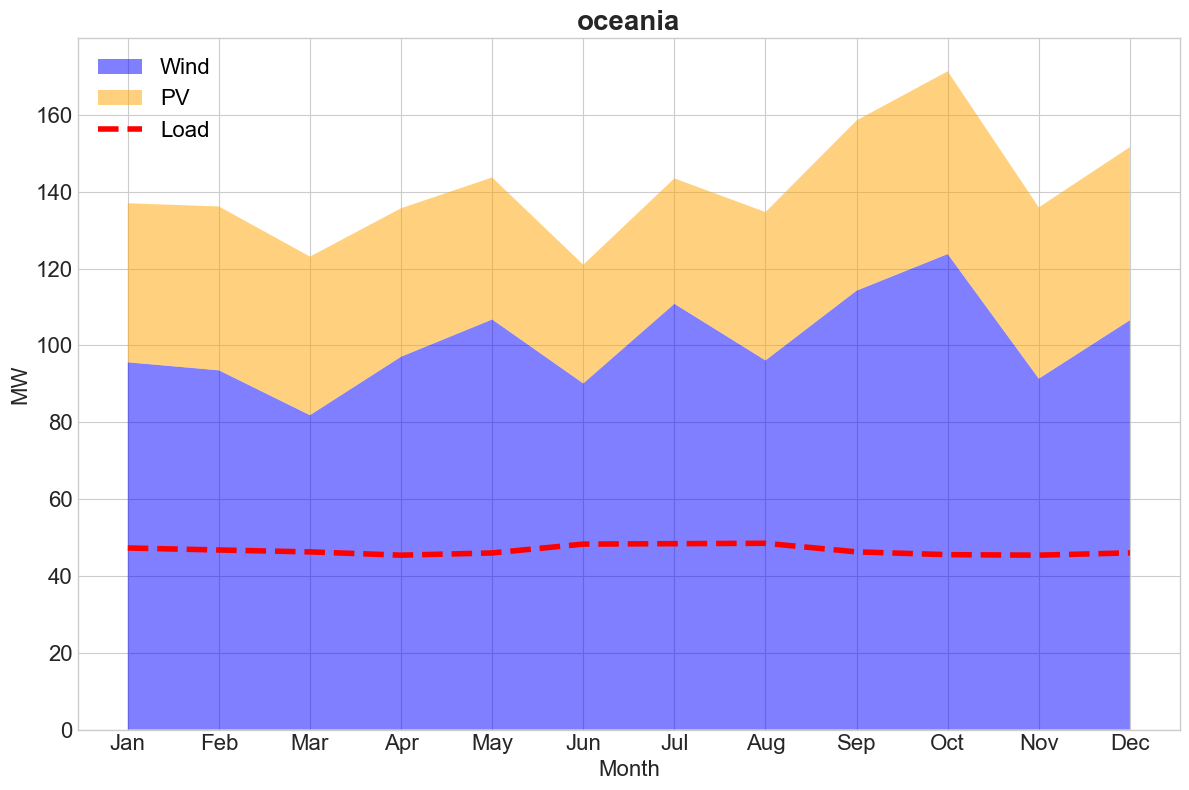

north_asia


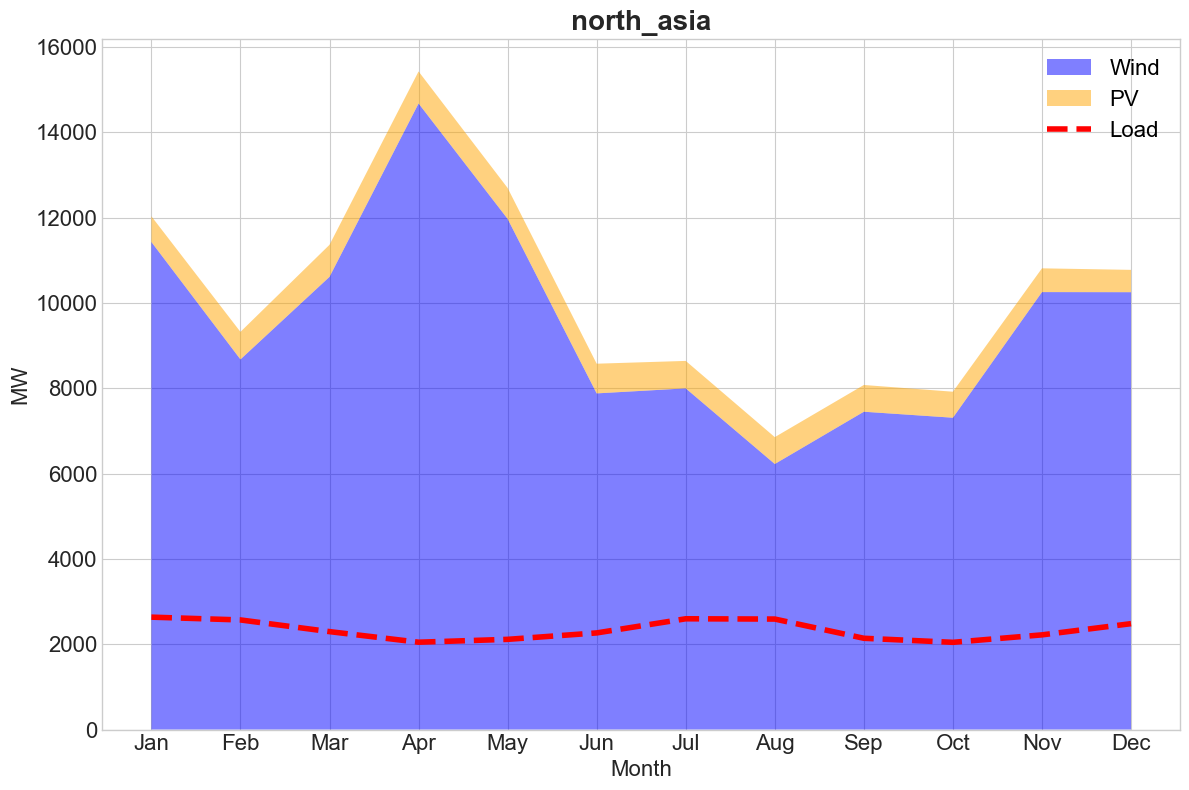

south_asia


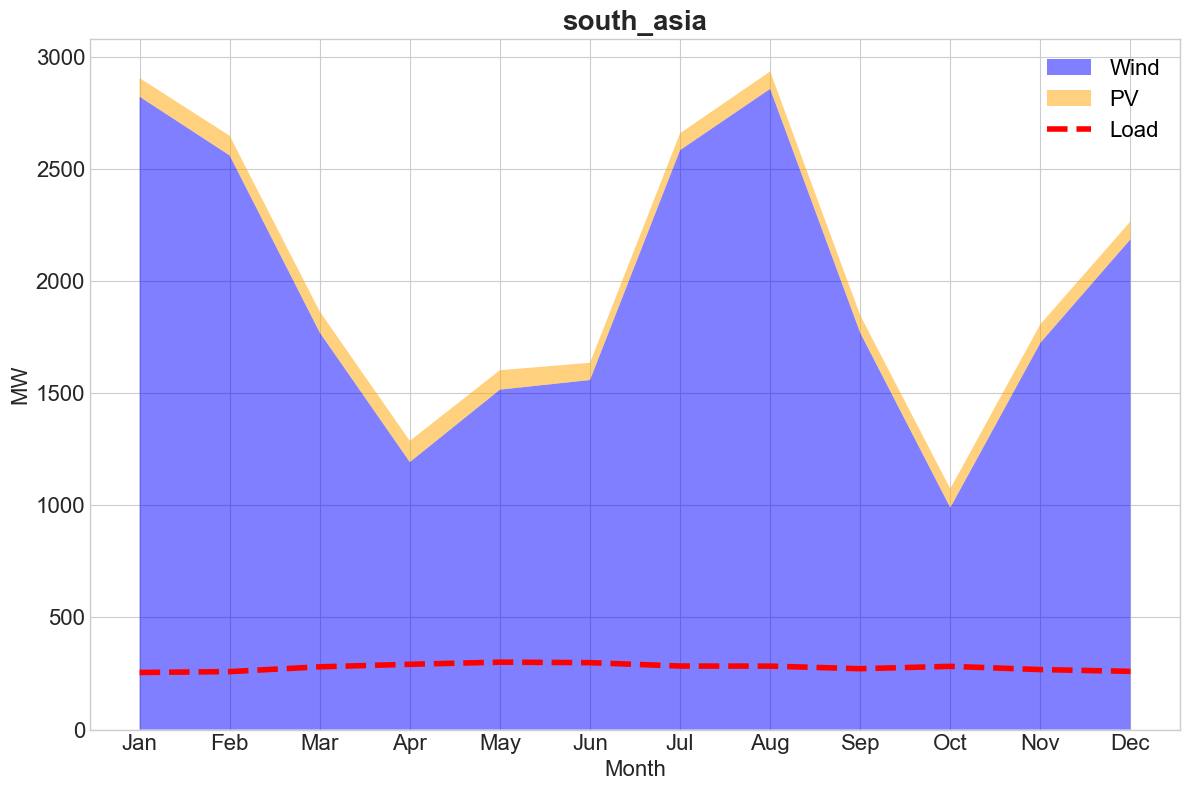

north_west_asia


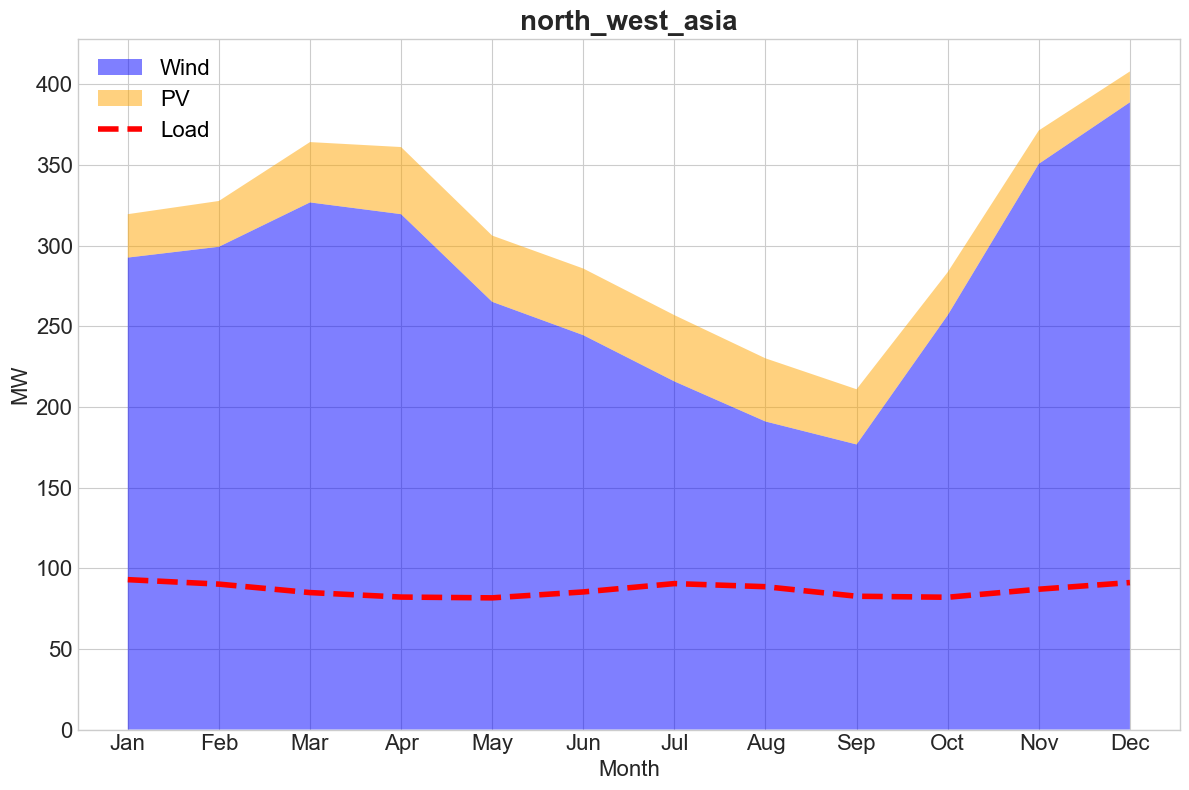

south_west_asia


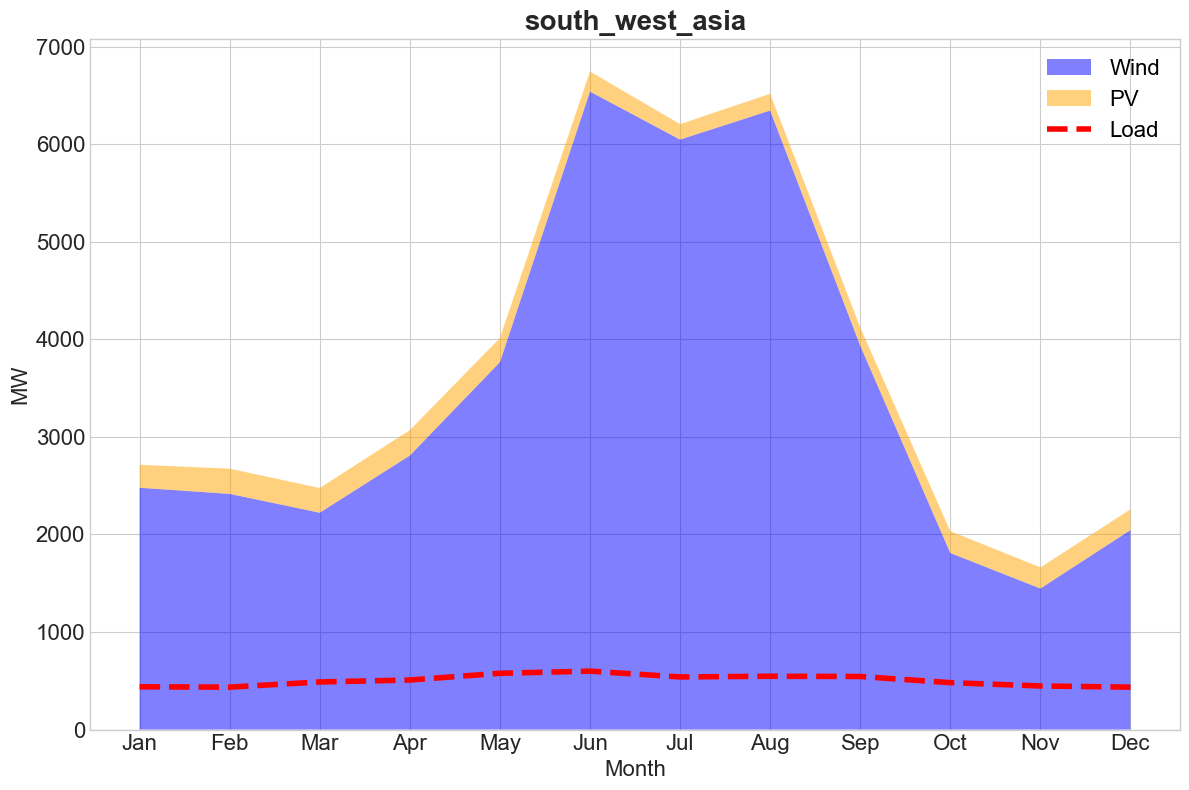

middle_east


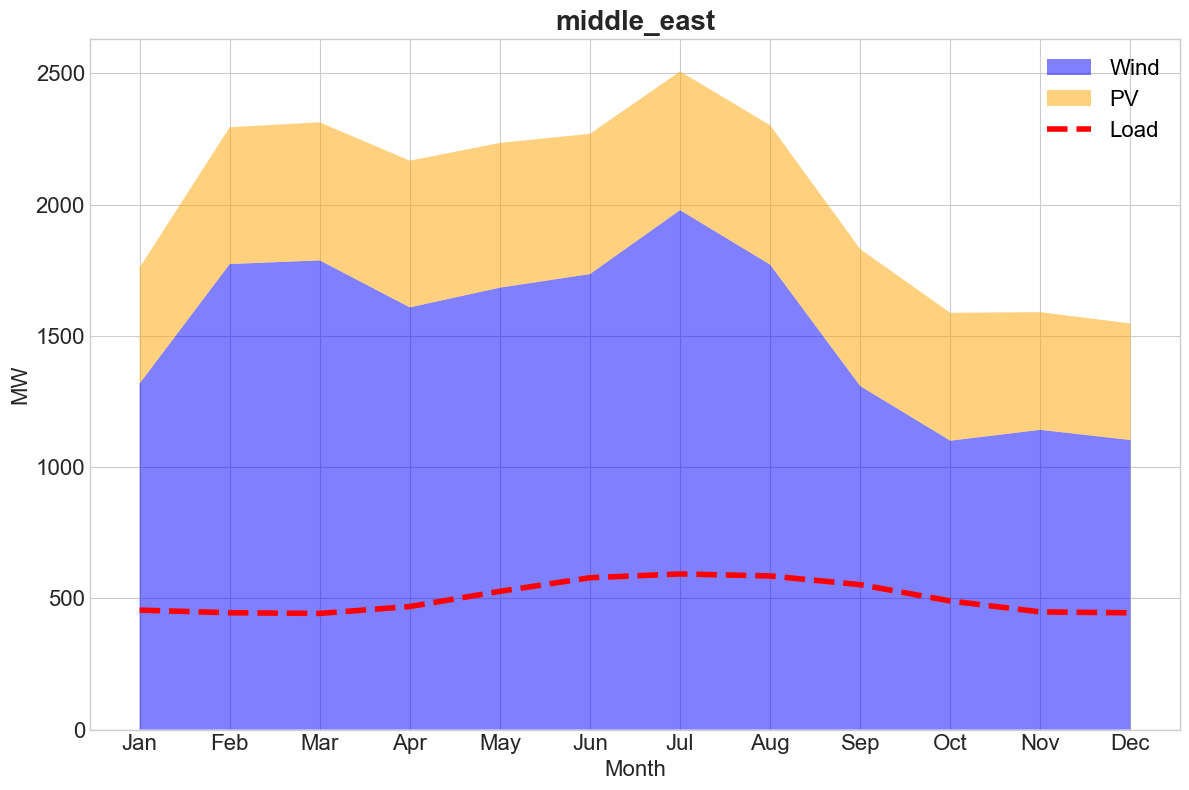

europe


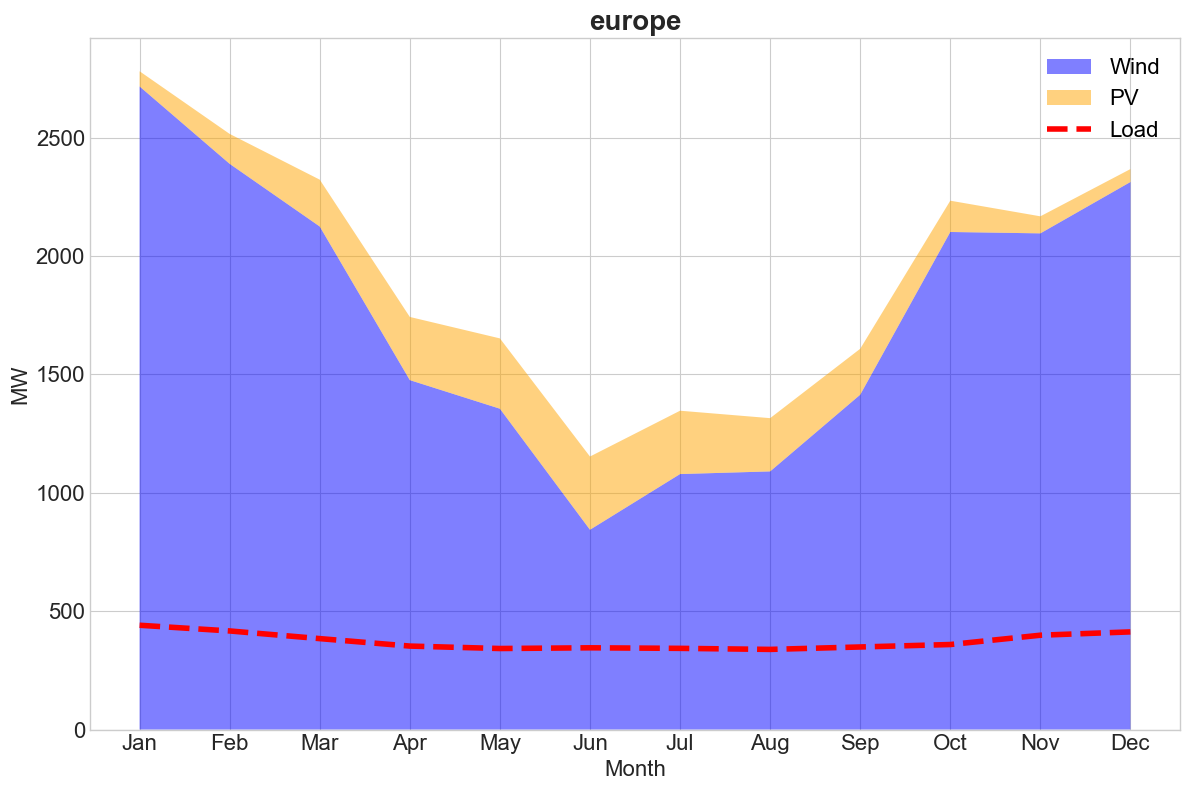

ups


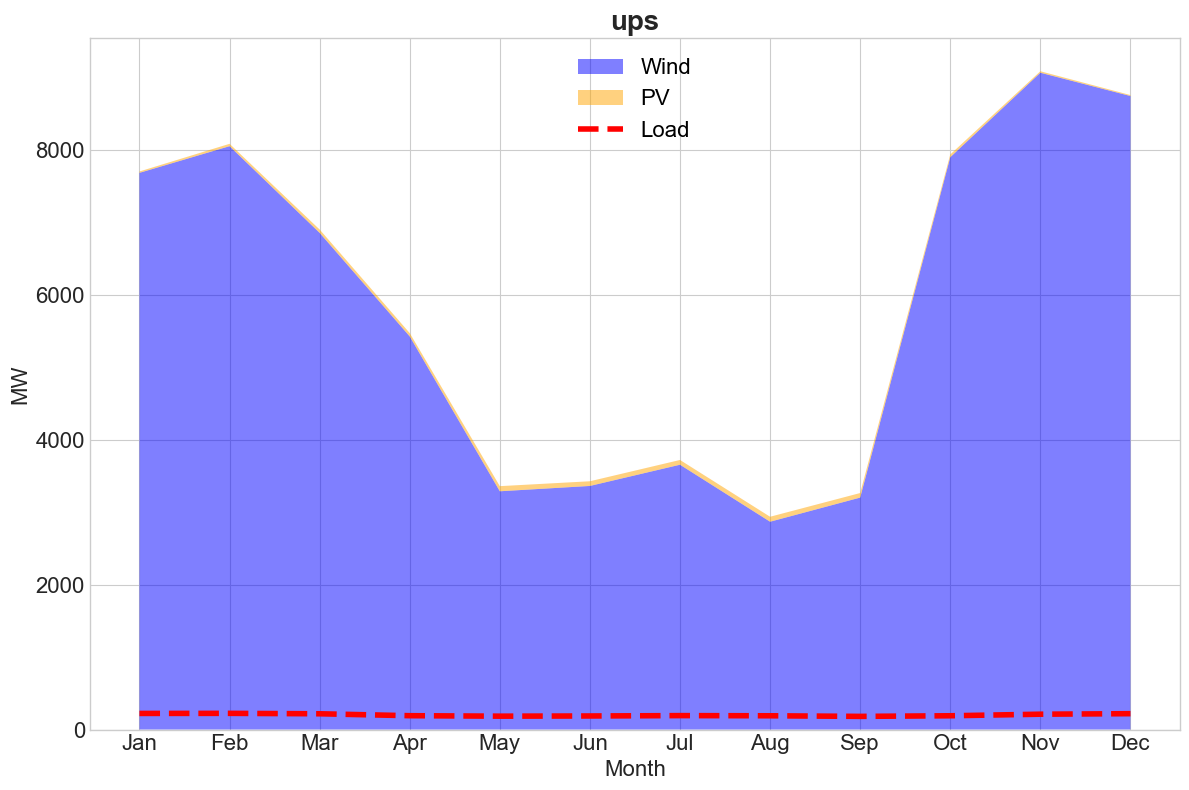

north_africa


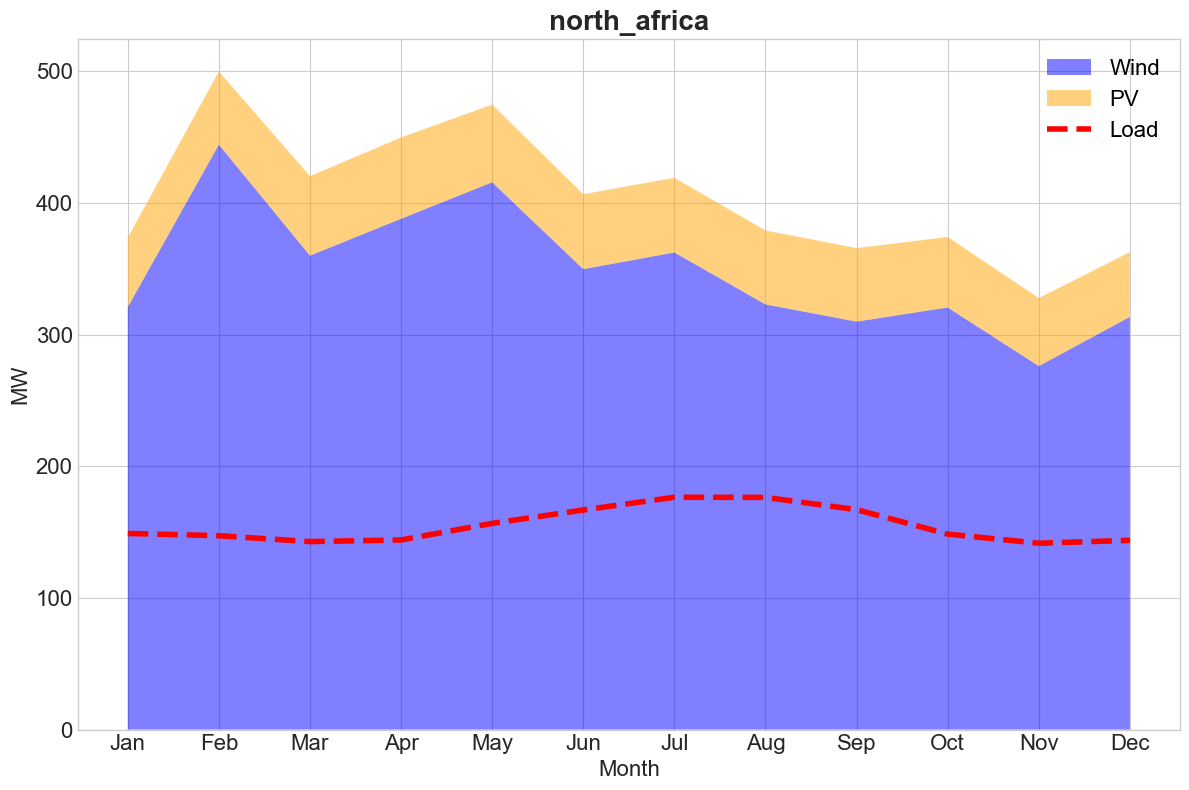

africa


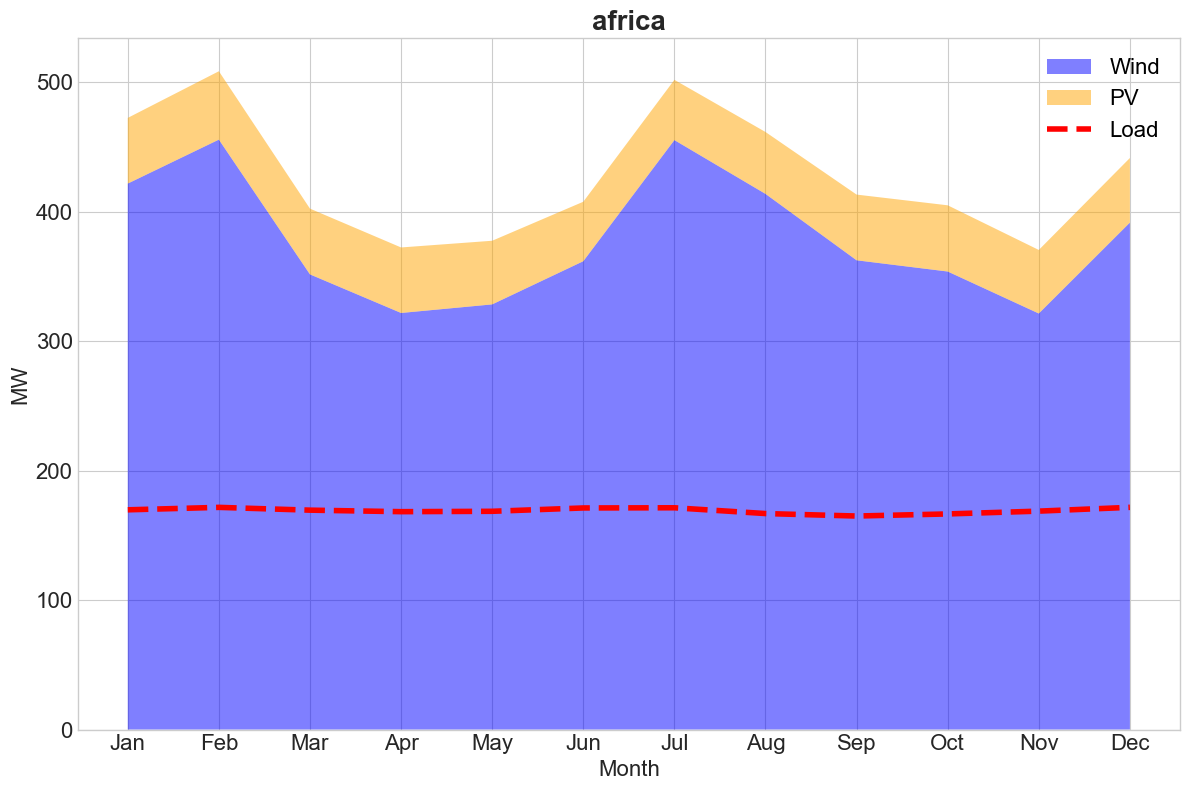

atlantic_north


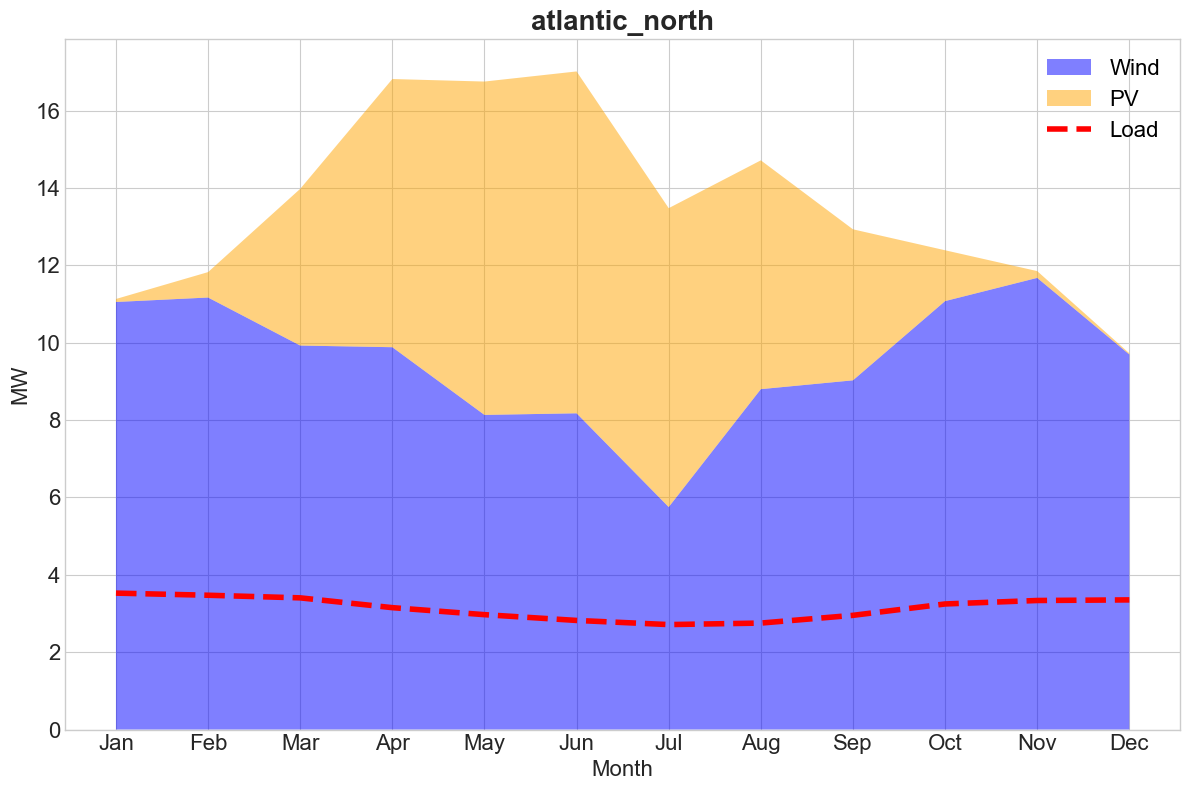

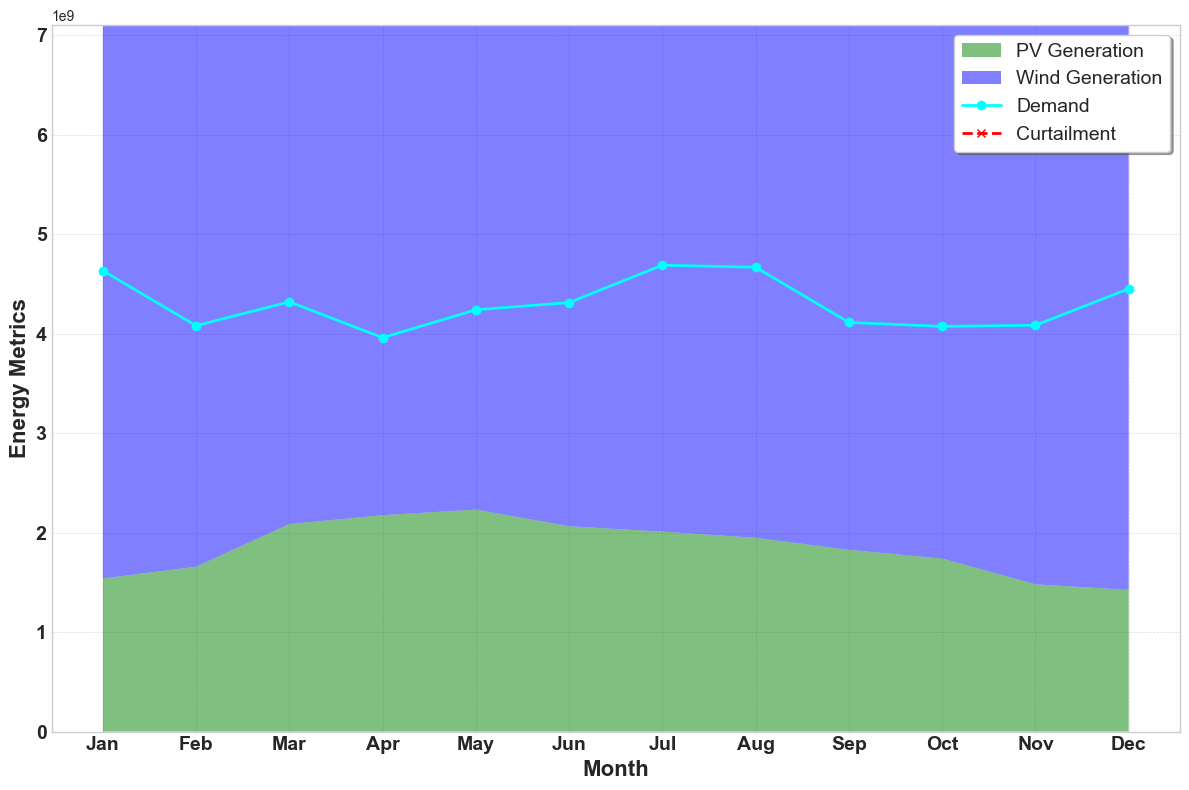

In [18]:
plt.style.use('seaborn-v0_8-whitegrid')  

for key, value in regions_dic.items():
    print(key)
    # series_l = value["load"]
    # load = series_l.groupby(series_l.index.to_period('M')).sum()
    load = value['mean_load_monthly']
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{key}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()

plt.figure(figsize=(12, 8))  # Increase figure size for better readability
# Plot line plots for Demand and Curtailment
# Plot stackplot for PV and wind generation
plt.stackplot(total_monthly_pv.index.month, total_monthly_pv.values, total_monthly_wind.values, labels=['PV Generation', 'Wind Generation'], colors=['green', 'blue'], alpha=0.5)
plt.plot(total_monthly_pv.index.month, total_monthly_load, label='Demand', color='cyan', linewidth=2, linestyle='-', marker='o')
plt.plot(total_monthly_pv.index.month, total_monthly_cur, label='Curtailment', color='red', linewidth=2, linestyle='--', marker='x')
plt.xlabel('Month', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('Energy Metrics', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.ylim(0, 7.1e9)
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, fontweight='bold')  # Increase x-tick font size and labels
plt.yticks(fontsize=14, fontweight='bold')  # Increase y-tick font size

plt.tight_layout()  # Adjust layout to fit elements better
plt.show()

## **Stochastic analysis**

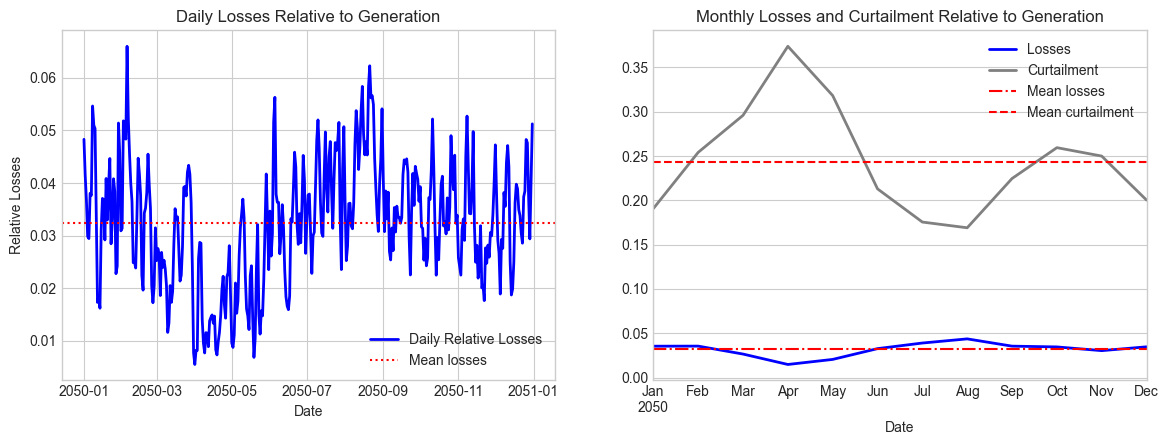

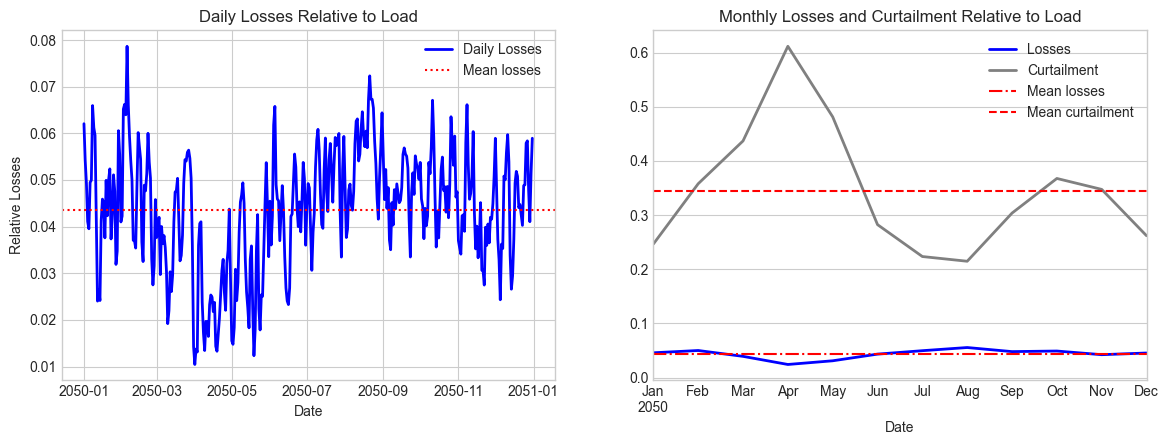

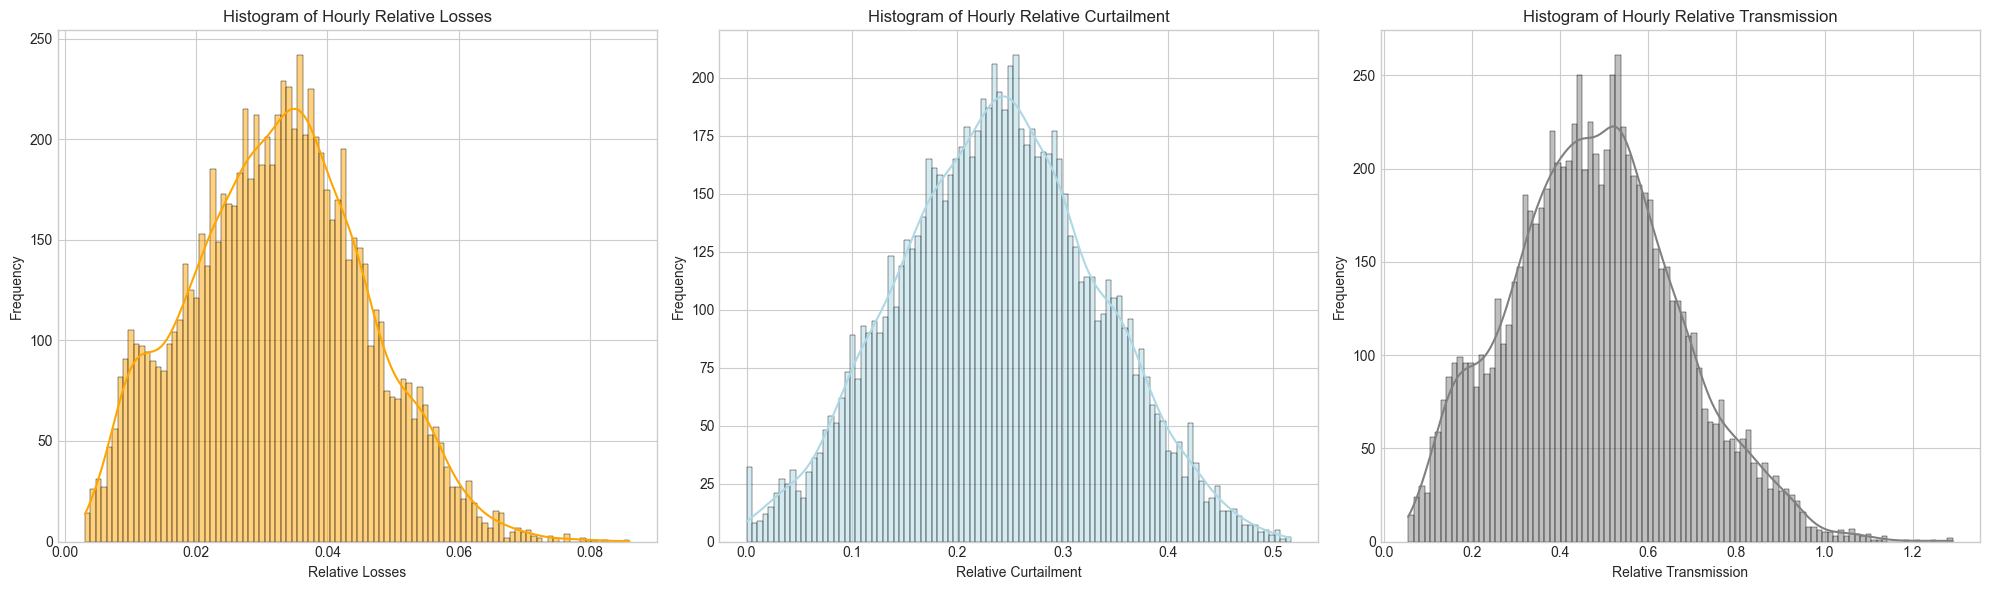

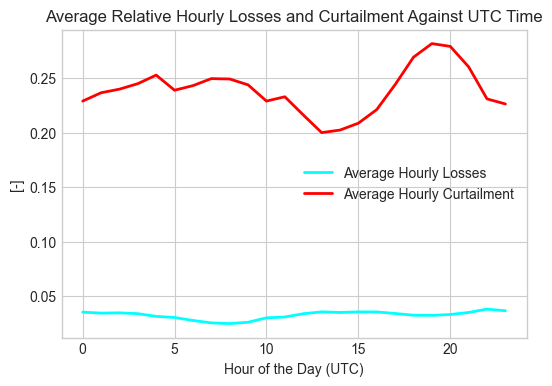

In [40]:
# Plot daily relative losses and compare to mean
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
daily_losses_rel_to_gen.plot(label='Daily Relative Losses', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=daily_losses_rel_to_gen.mean(), color='red', linestyle=':', label='Mean losses')
plt.title('Daily Losses Relative to Generation')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Monthly Average Losses
plt.subplot(2, 2, 2)
monthly_losses_rel_to_gen.plot(label='Losses', color='blue', linewidth=2)
monthly_cur_rel_to_gen.plot(label='Curtailment', color='gray', linestyle='-', linewidth=2)
plt.axhline(y=monthly_losses_rel_to_gen.mean(), color='red', linestyle='-.', label='Mean losses')
plt.axhline(y=monthly_cur_rel_to_gen.mean(), color='red', linestyle='--', label='Mean curtailment')
plt.title('Monthly Losses and Curtailment Relative to Generation')
plt.xlabel('Date')
plt.legend()

# Plot daily relative losses and compare to mean
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
daily_losses_rel_to_load.plot(label='Daily Losses', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=daily_losses_rel_to_load.mean(), color='red', linestyle=':', label='Mean losses')
plt.title('Daily Losses Relative to Load')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Monthly Average Losses
plt.subplot(2, 2, 2)
monthly_losses_rel_to_load.plot(label='Losses', color='blue', linewidth=2)
monthly_cur_rel_to_load.plot(label='Curtailment', color='gray', linestyle='-', linewidth=2)
plt.axhline(y=monthly_losses_rel_to_load.mean(), color='red', linestyle='-.', label='Mean losses')
plt.axhline(y=monthly_cur_rel_to_load.mean(), color='red', linestyle='--', label='Mean curtailment')
plt.title('Monthly Losses and Curtailment Relative to Load')
plt.xlabel('Date')
plt.legend()

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.histplot(hourly_losses_rel_to_gen, bins=100, kde=True, color='orange')
plt.title('Histogram of Hourly Relative Losses')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(hourly_cur_rel_to_gen, bins=100, kde=True, color='lightblue')
plt.title('Histogram of Hourly Relative Curtailment')
plt.xlabel('Relative Curtailment')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(hourly_p_trans_rel_gen, bins=100, kde=True, color='gray')
plt.title('Histogram of Hourly Relative Transmission')
plt.xlabel('Relative Transmission')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Losses against UTC time
hourly_losses = hourly_losses_rel_to_gen.groupby(hourly_losses_rel_to_gen.index.hour).mean()
hourly_cur = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.hour).mean()
plt.figure(figsize=(6, 4))
hourly_losses.plot(label='Average Hourly Losses', color='cyan', linewidth=2)
hourly_cur.plot(label='Average Hourly Curtailment', color='red', linewidth=2)
plt.title('Average Relative Hourly Losses and Curtailment Against UTC Time')
plt.xlabel('Hour of the Day (UTC)')
plt.ylabel('[-]')
plt.legend()
plt.show()



## Correlation matrix

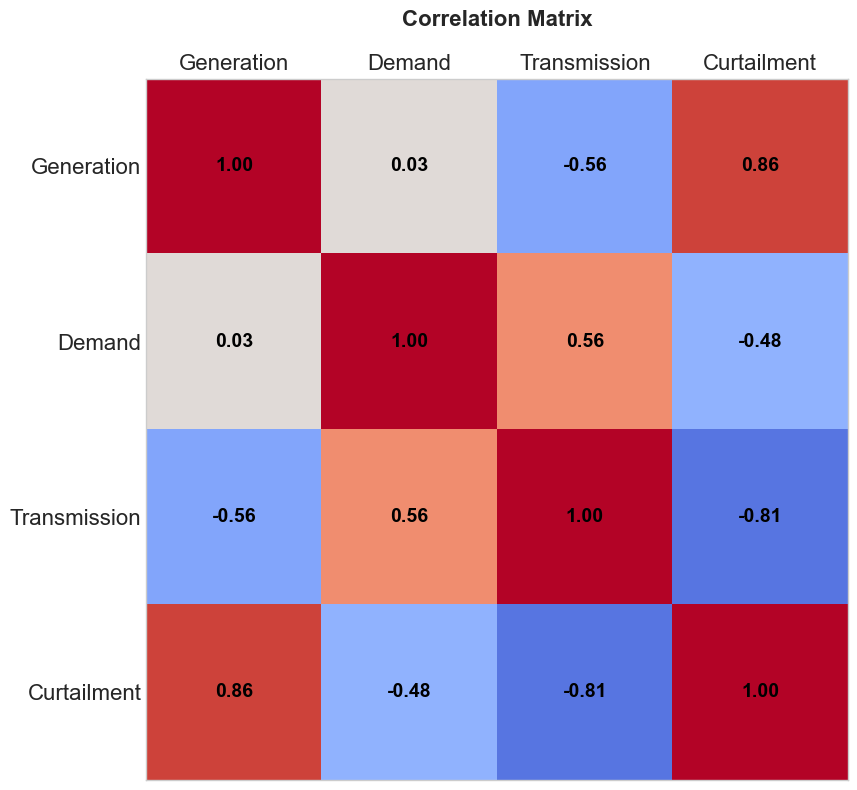

In [41]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Generation': total_hourly_gen,
    'Demand': total_hourly_load,
    'Transmission': total_hourly_p_trans,
    'Curtailment': total_hourly_cur
    
})

# Calculate pairwise correlations
correlation_matrix = data.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Display the matrix values with reversed colormap
cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns, rotation=0, fontsize=16)
ax.set_yticklabels(correlation_matrix.index, fontsize=16)

# Add text annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, f'{correlation_matrix.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=14, fontweight='bold')

# Title and layout adjustments
plt.title('Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## Fourier Transform

### Global fourier transform

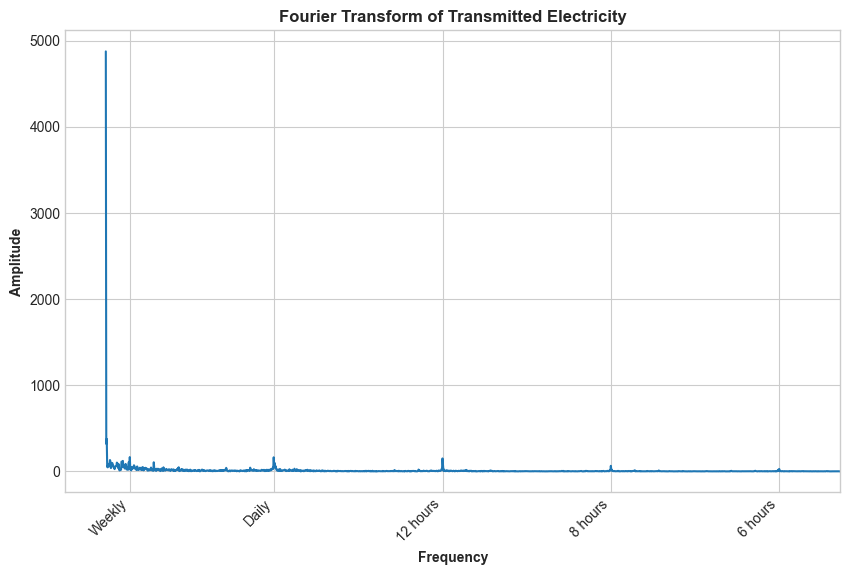

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
# Convert to numpy array
hourly_p_trans_rel_gen_array = total_actual_flow.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Transmitted Electricity', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

### Regional fourier transform

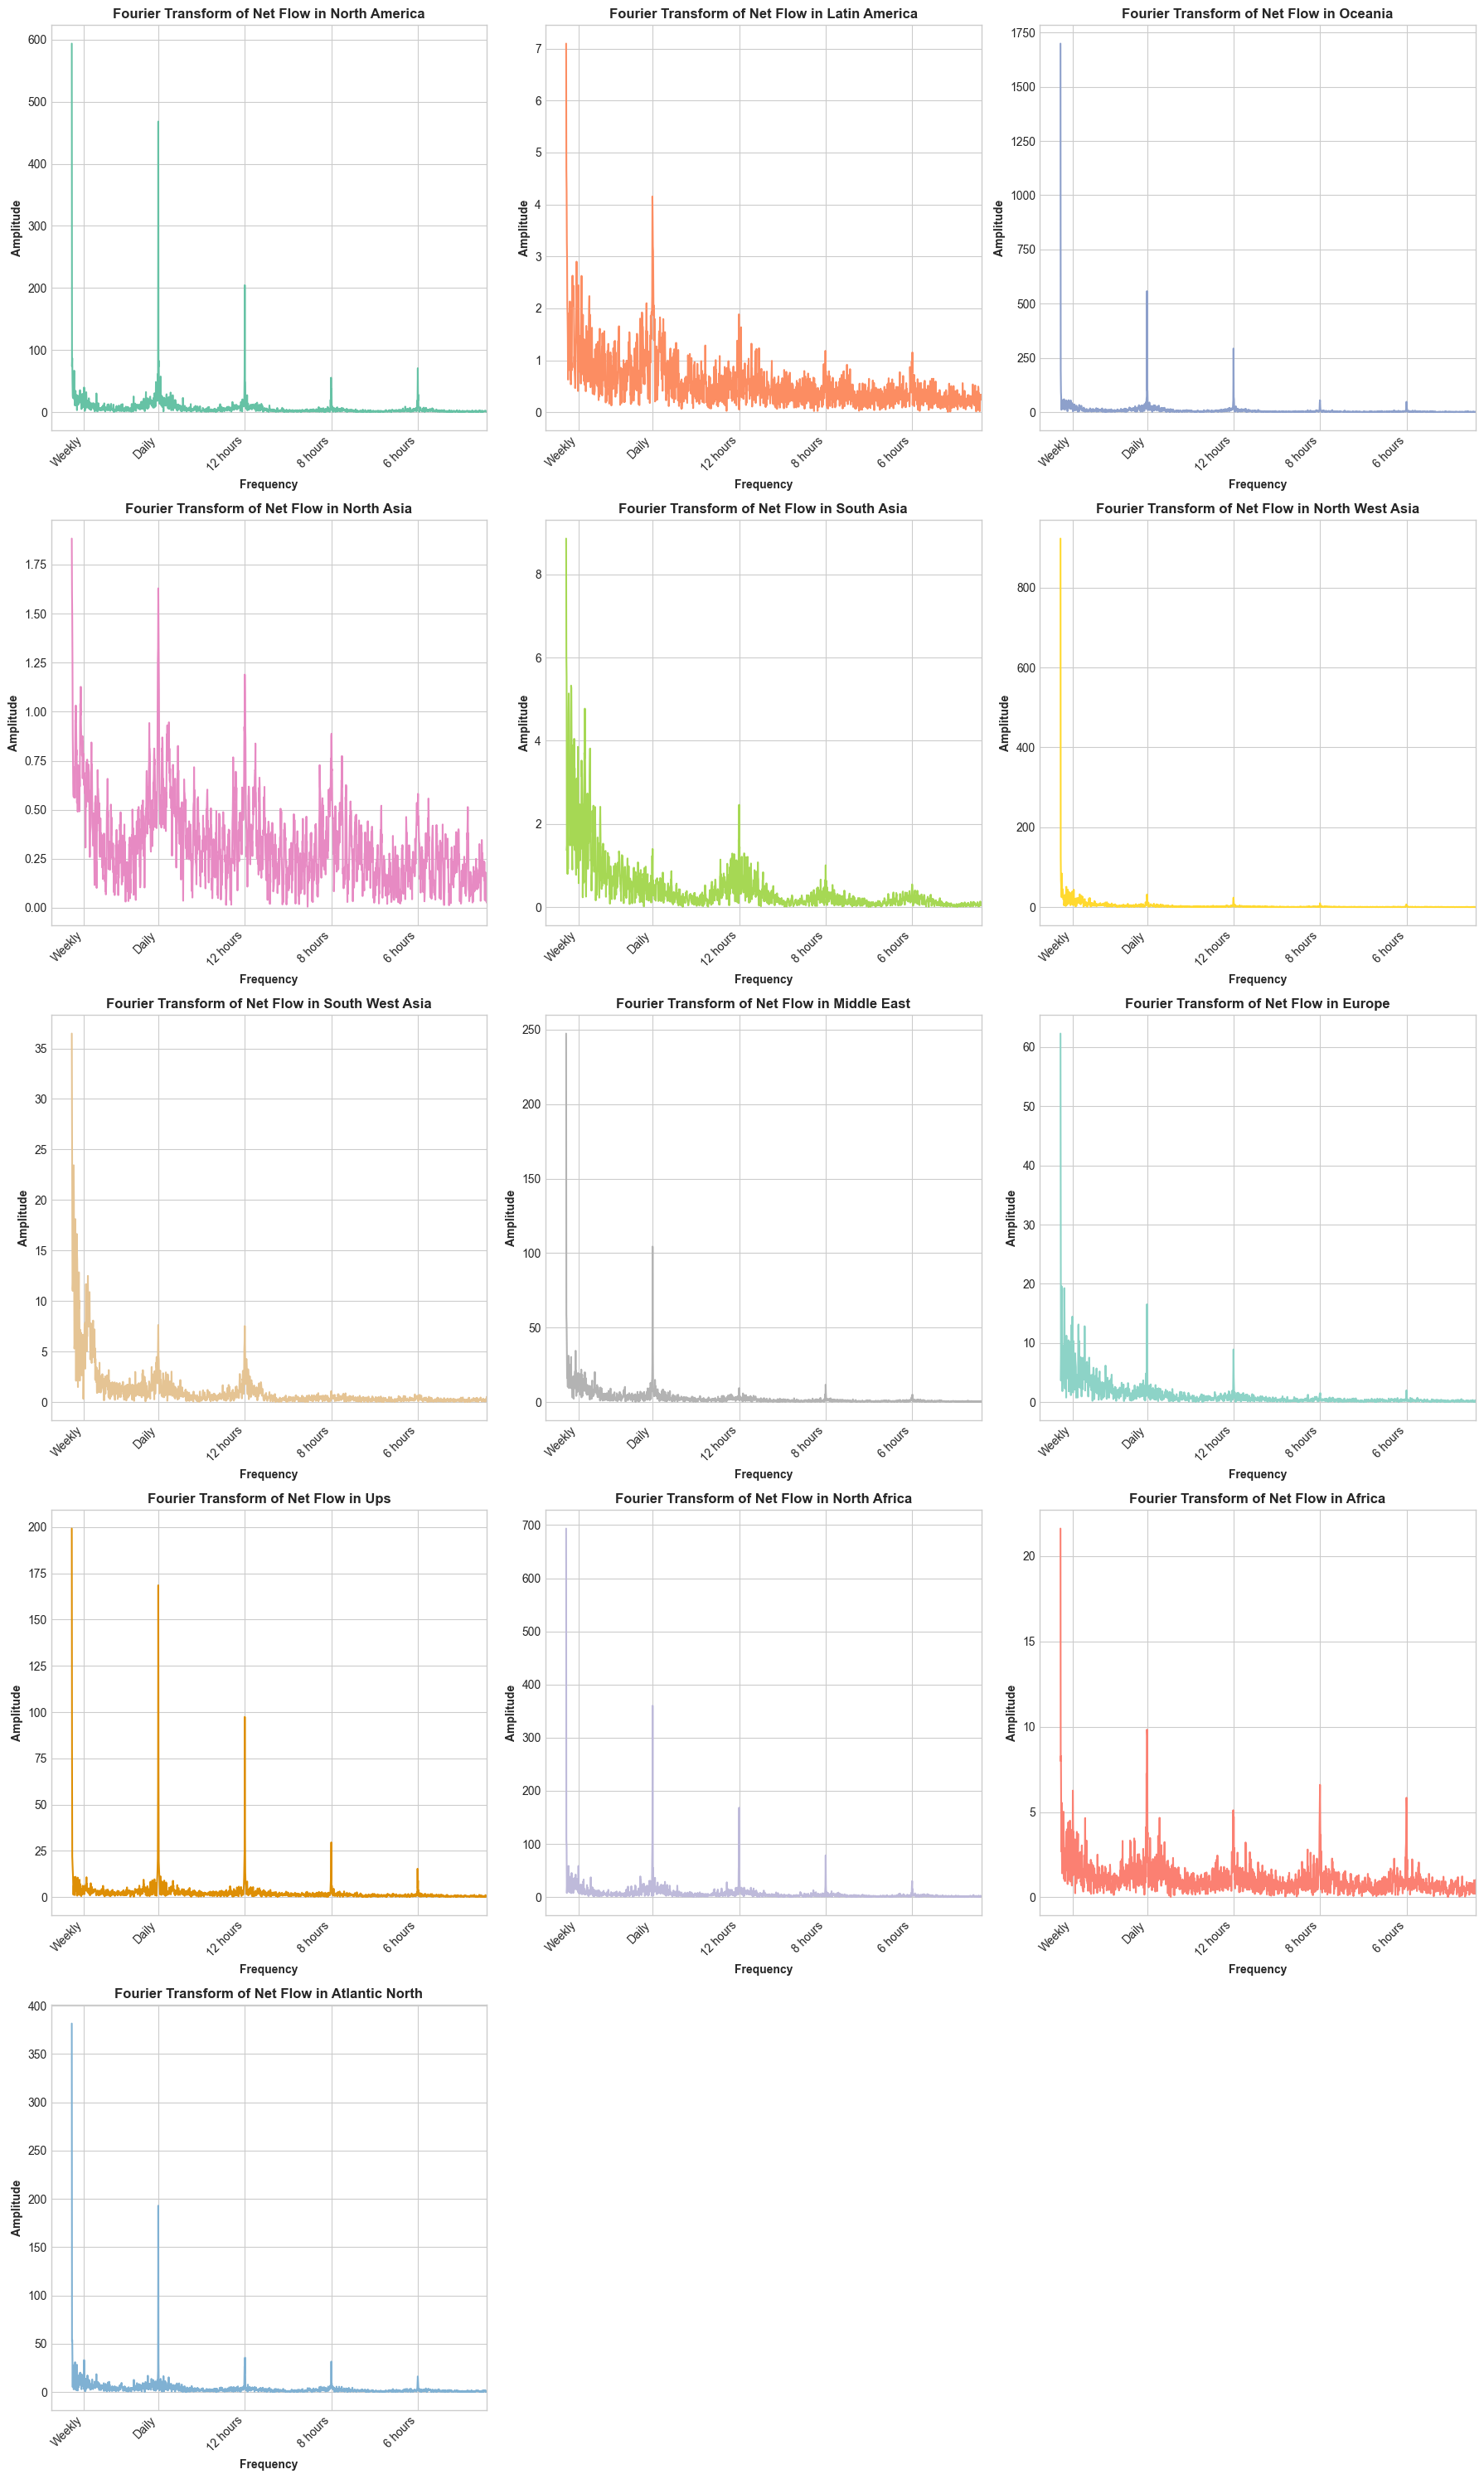

In [43]:
def format_region_name(region_name):
    return ' '.join(word.capitalize() for word in region_name.split('_'))

def plot_fourier_transform(region_key, region_value, ax):
    series = region_value["actualflow"]
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    eight_hour_freq = 1 / 8.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq, half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
    
    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color=region_colors[region_key])
    ax.set_xticks(frequencies)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlim(-0.01, 1/5)
    ax.set_xlabel('Frequency', fontweight='bold')
    ax.set_ylabel('Amplitude', fontweight='bold')
    formatted_title = format_region_name(region_key)
    ax.set_title(f'Fourier Transform of Net Flow in {formatted_title}', fontweight='bold')
    ax.grid(True, axis='x')

num_plots = len(regions_dic)
rows = (num_plots + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axs = axs.flatten()

for idx, (region_key, region_value) in enumerate(regions_dic.items()):
    plot_fourier_transform(region_key, region_value, axs[idx])

for idx in range(len(regions_dic), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()

# **Maps**

## Global grid map

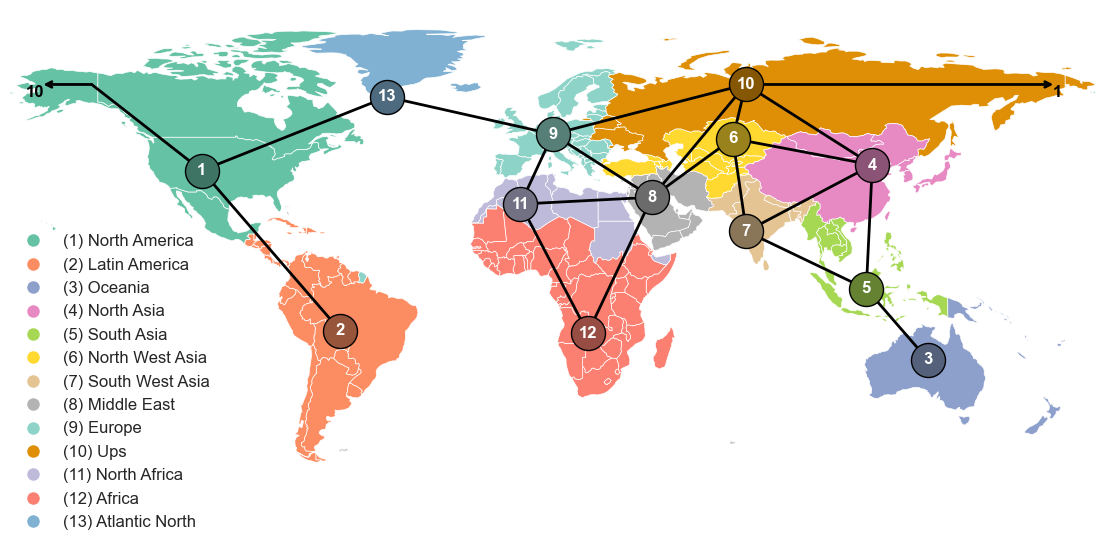

In [44]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic
import matplotlib.colors as mcolors

plt.rc("figure", figsize=(14, 10))
# Function to convert RGB tuple to hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def darken_color(color, factor=0.8):
    """
    Darkens a color by a given factor.
    color: The color to be darkened (in RGB or hex format).
    factor: The factor to darken the color (default is 0.8).
    """
    rgb = mcolors.to_rgb(color)  # Convert to RGB if in hex
    darker_rgb = [factor * c for c in rgb]  # Apply factor to each component
    return mcolors.to_hex(darker_rgb)  # Convert back to hex

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Manually assign French Guiana to Latin America
world.loc[world['name'] == 'France', 'bus'] = world.loc[world['name'] == 'France'].apply(
    lambda row: 'latin_america' if row['continent'] == 'South America' else row['bus'],
    axis=1
)

# Ensure that we have unique regions in the order defined in regions_dic
ordered_regions = [key for key in regions_dic if key in world['bus'].unique()]

# Convert colors to hex
colors = [rgb_to_hex(region_colors[bus]) if bus in region_colors else '#cccccc' for bus in world['bus']]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed


# Plot country regions with assigned colors
world.plot(ax=ax, color=colors, edgecolor='white', legend=False,transform=ccrs.PlateCarree(), linewidth=0.5)
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=f'({i+1}) {region.replace('_', ' ').title()}')
    for i, region in enumerate(ordered_regions)
]
ax.legend(
    handles=handles, 
    loc='lower left', 
    bbox_to_anchor=(-0.008, -0.013), 
    bbox_transform=ax.transAxes, 
    fancybox=False, 
    shadow=False, 
    ncol=1, 
    fontsize=12, 
    frameon=False, 
    framealpha=1, 
    edgecolor='black'
)

for i, bus in enumerate(n.buses.index, start=1):
    color_ = color_ = darken_color(region_colors[bus], factor=0.6)
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=600, color=color_, edgecolor='black', zorder=5, linewidths=1, transform=ccrs.PlateCarree())
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())

# Plot links
for i, link in enumerate(n.links.index[0::2]):
    if link != 'north_america_to_ups_0':
        bus0 = n.links.loc[link, 'bus0']
        bus1 = n.links.loc[link, 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
    else:
        bus0 = n.links.loc['north_america_to_ups_0', 'bus0']
        bus1 = n.links.loc['north_america_to_ups_0', 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]    
        x1, y1 = -143, n.buses.loc[bus1, ['x', 'y']]['y']
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
        x0, y0 = x1+0.9, y1    
        x1, y1 = -160, y1
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(-165, y1, '10', color='black', fontsize=12, ha='left', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree()) 
        x0, y0 = 177, y1    
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.annotate('', xy=(x0, y0), xytext=(x1, y1),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(x0+2, y0, '1', color='black', fontsize=12, ha='right', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())     
ax.spines['geo'].set_visible(False)
plt.show()


## Heat maps

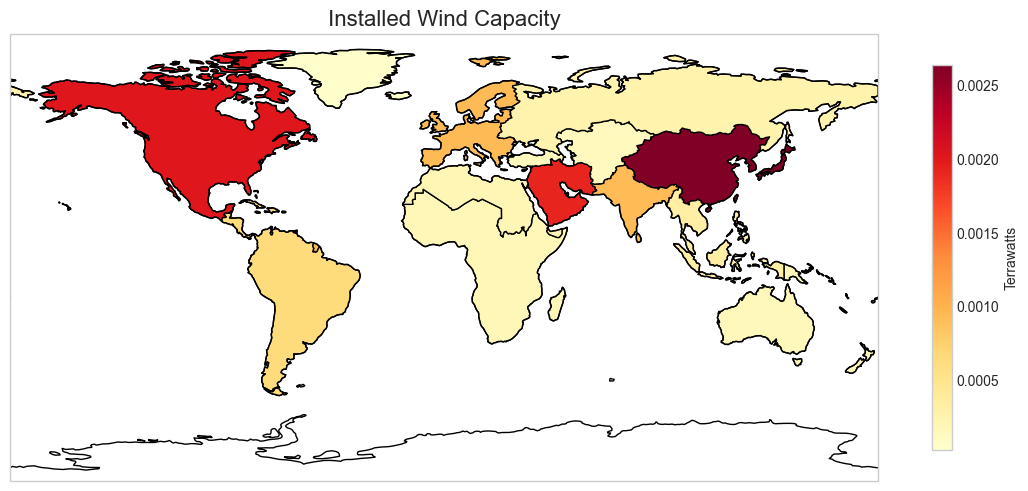

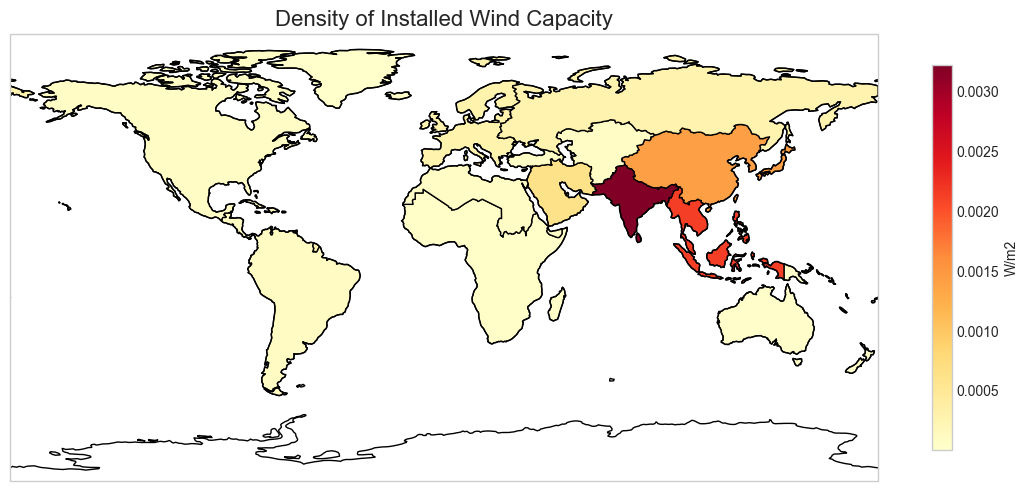

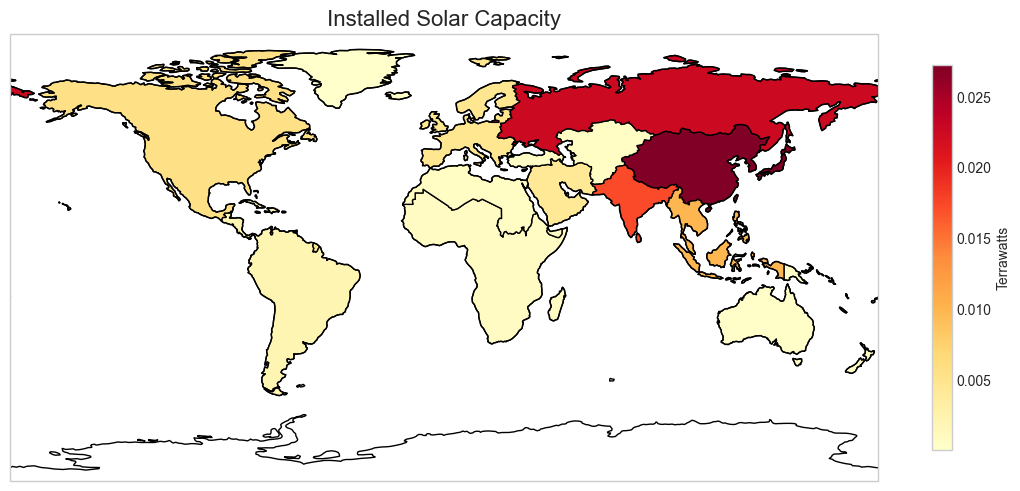

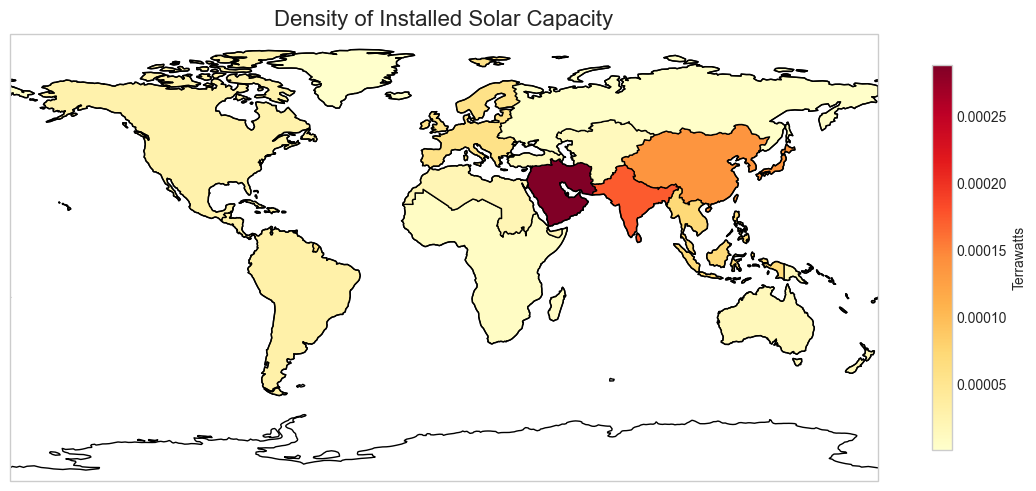

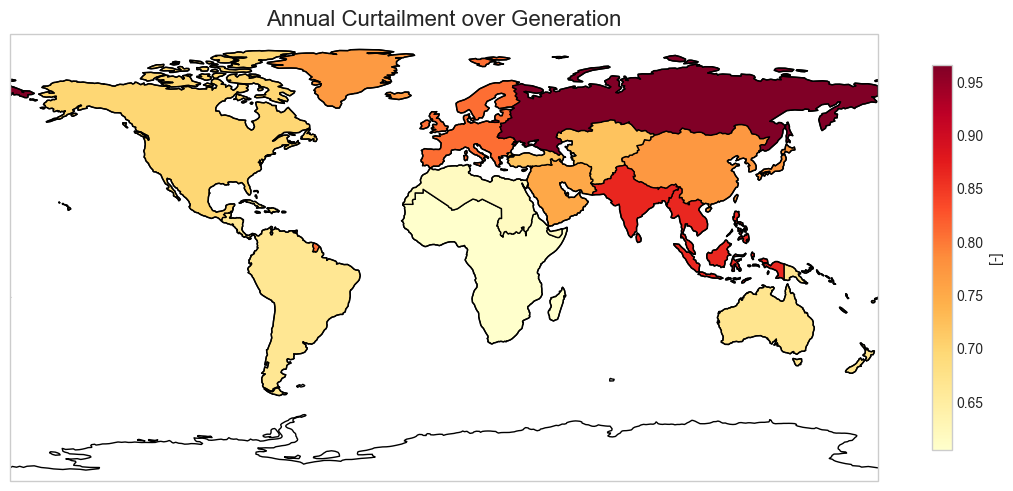

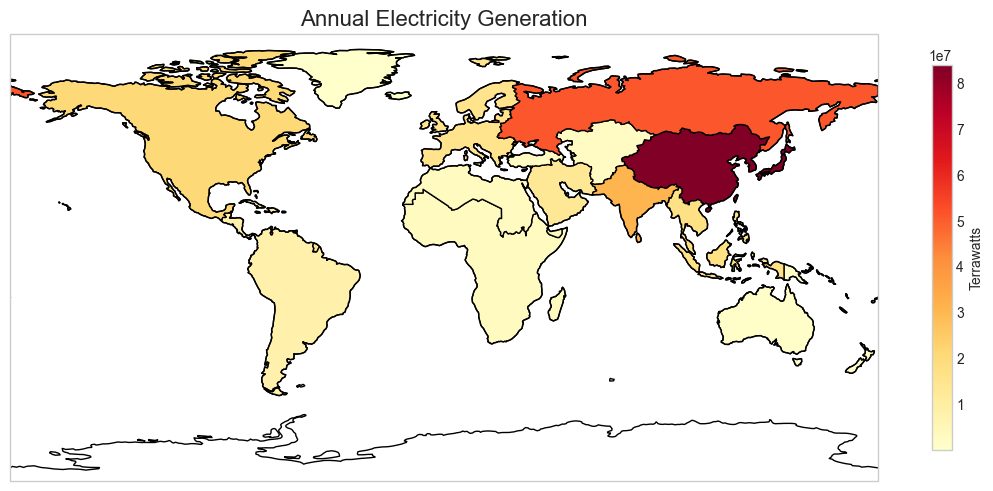

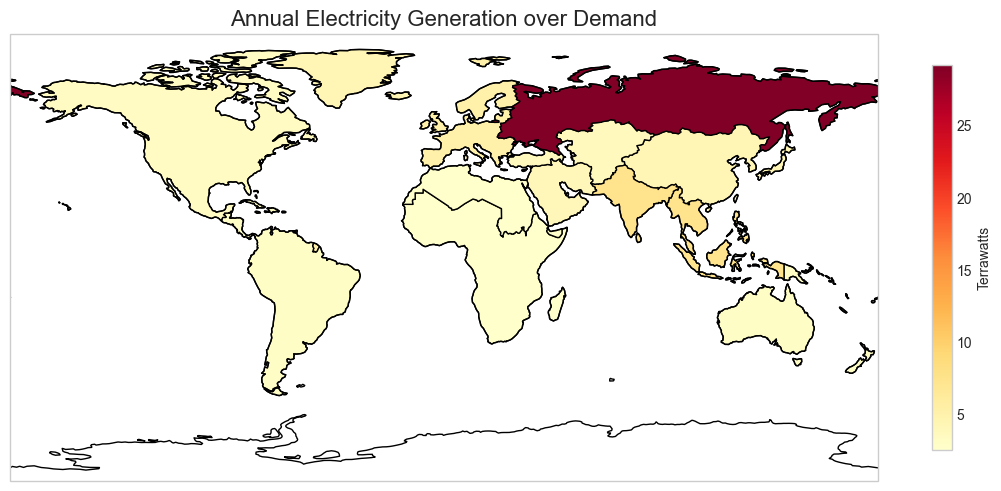

In [19]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_capacity_wind_dic[key] = value["wind_installed"] / 1e6
    installed_capacity_pv_dic[key] = value["pv_installed"] / 1e6
    installed_cap_pv_area[key] = value["wind_installed"] / area * 1e6
    installed_cap_wind_area[key] = value["pv_installed"] / area * 1e6
    curtailment_rel_to_gen[key] = value["total_curtailment_yearly"] / (value["total_wind_yearly"] + value["total_pv_yearly"])
    loads_dic[key] = (value["total_wind_yearly"] + value["total_pv_yearly"]) / value["total_load_yearly"]
    generation_dic[key] = value["total_wind_yearly"] + value["total_pv_yearly"] / 1e6
values_dics = [installed_capacity_pv_dic, installed_cap_pv_area,  installed_capacity_wind_dic,  installed_cap_wind_area, curtailment_rel_to_gen, generation_dic, loads_dic]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    # Plotting the network with results
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind Capacity', fontsize=16)
    elif i == 1:
        plt.title('Density of Installed Wind Capacity', fontsize=16)
    elif i == 2:
        plt.title('Installed Solar Capacity', fontsize=16)
    elif i == 3:
        plt.title('Density of Installed Solar Capacity', fontsize=16)
    elif i == 4:
        plt.title('Annual Curtailment over Generation', fontsize=16)
    elif i == 5:
        plt.title('Annual Electricity Generation', fontsize=16)
    elif i == 6:
        plt.title('Annual Electricity Generation over Demand', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    if i == np.any([1, 3]):
        cbar.set_label('W/m2')
    elif i == np.any([5, 6]):
        cbar.set_label('TWh')
    elif i == 4:
        cbar.set_label('[-]')
    else:
        cbar.set_label('Terrawatts')


    plt.show()

## Power flow chart

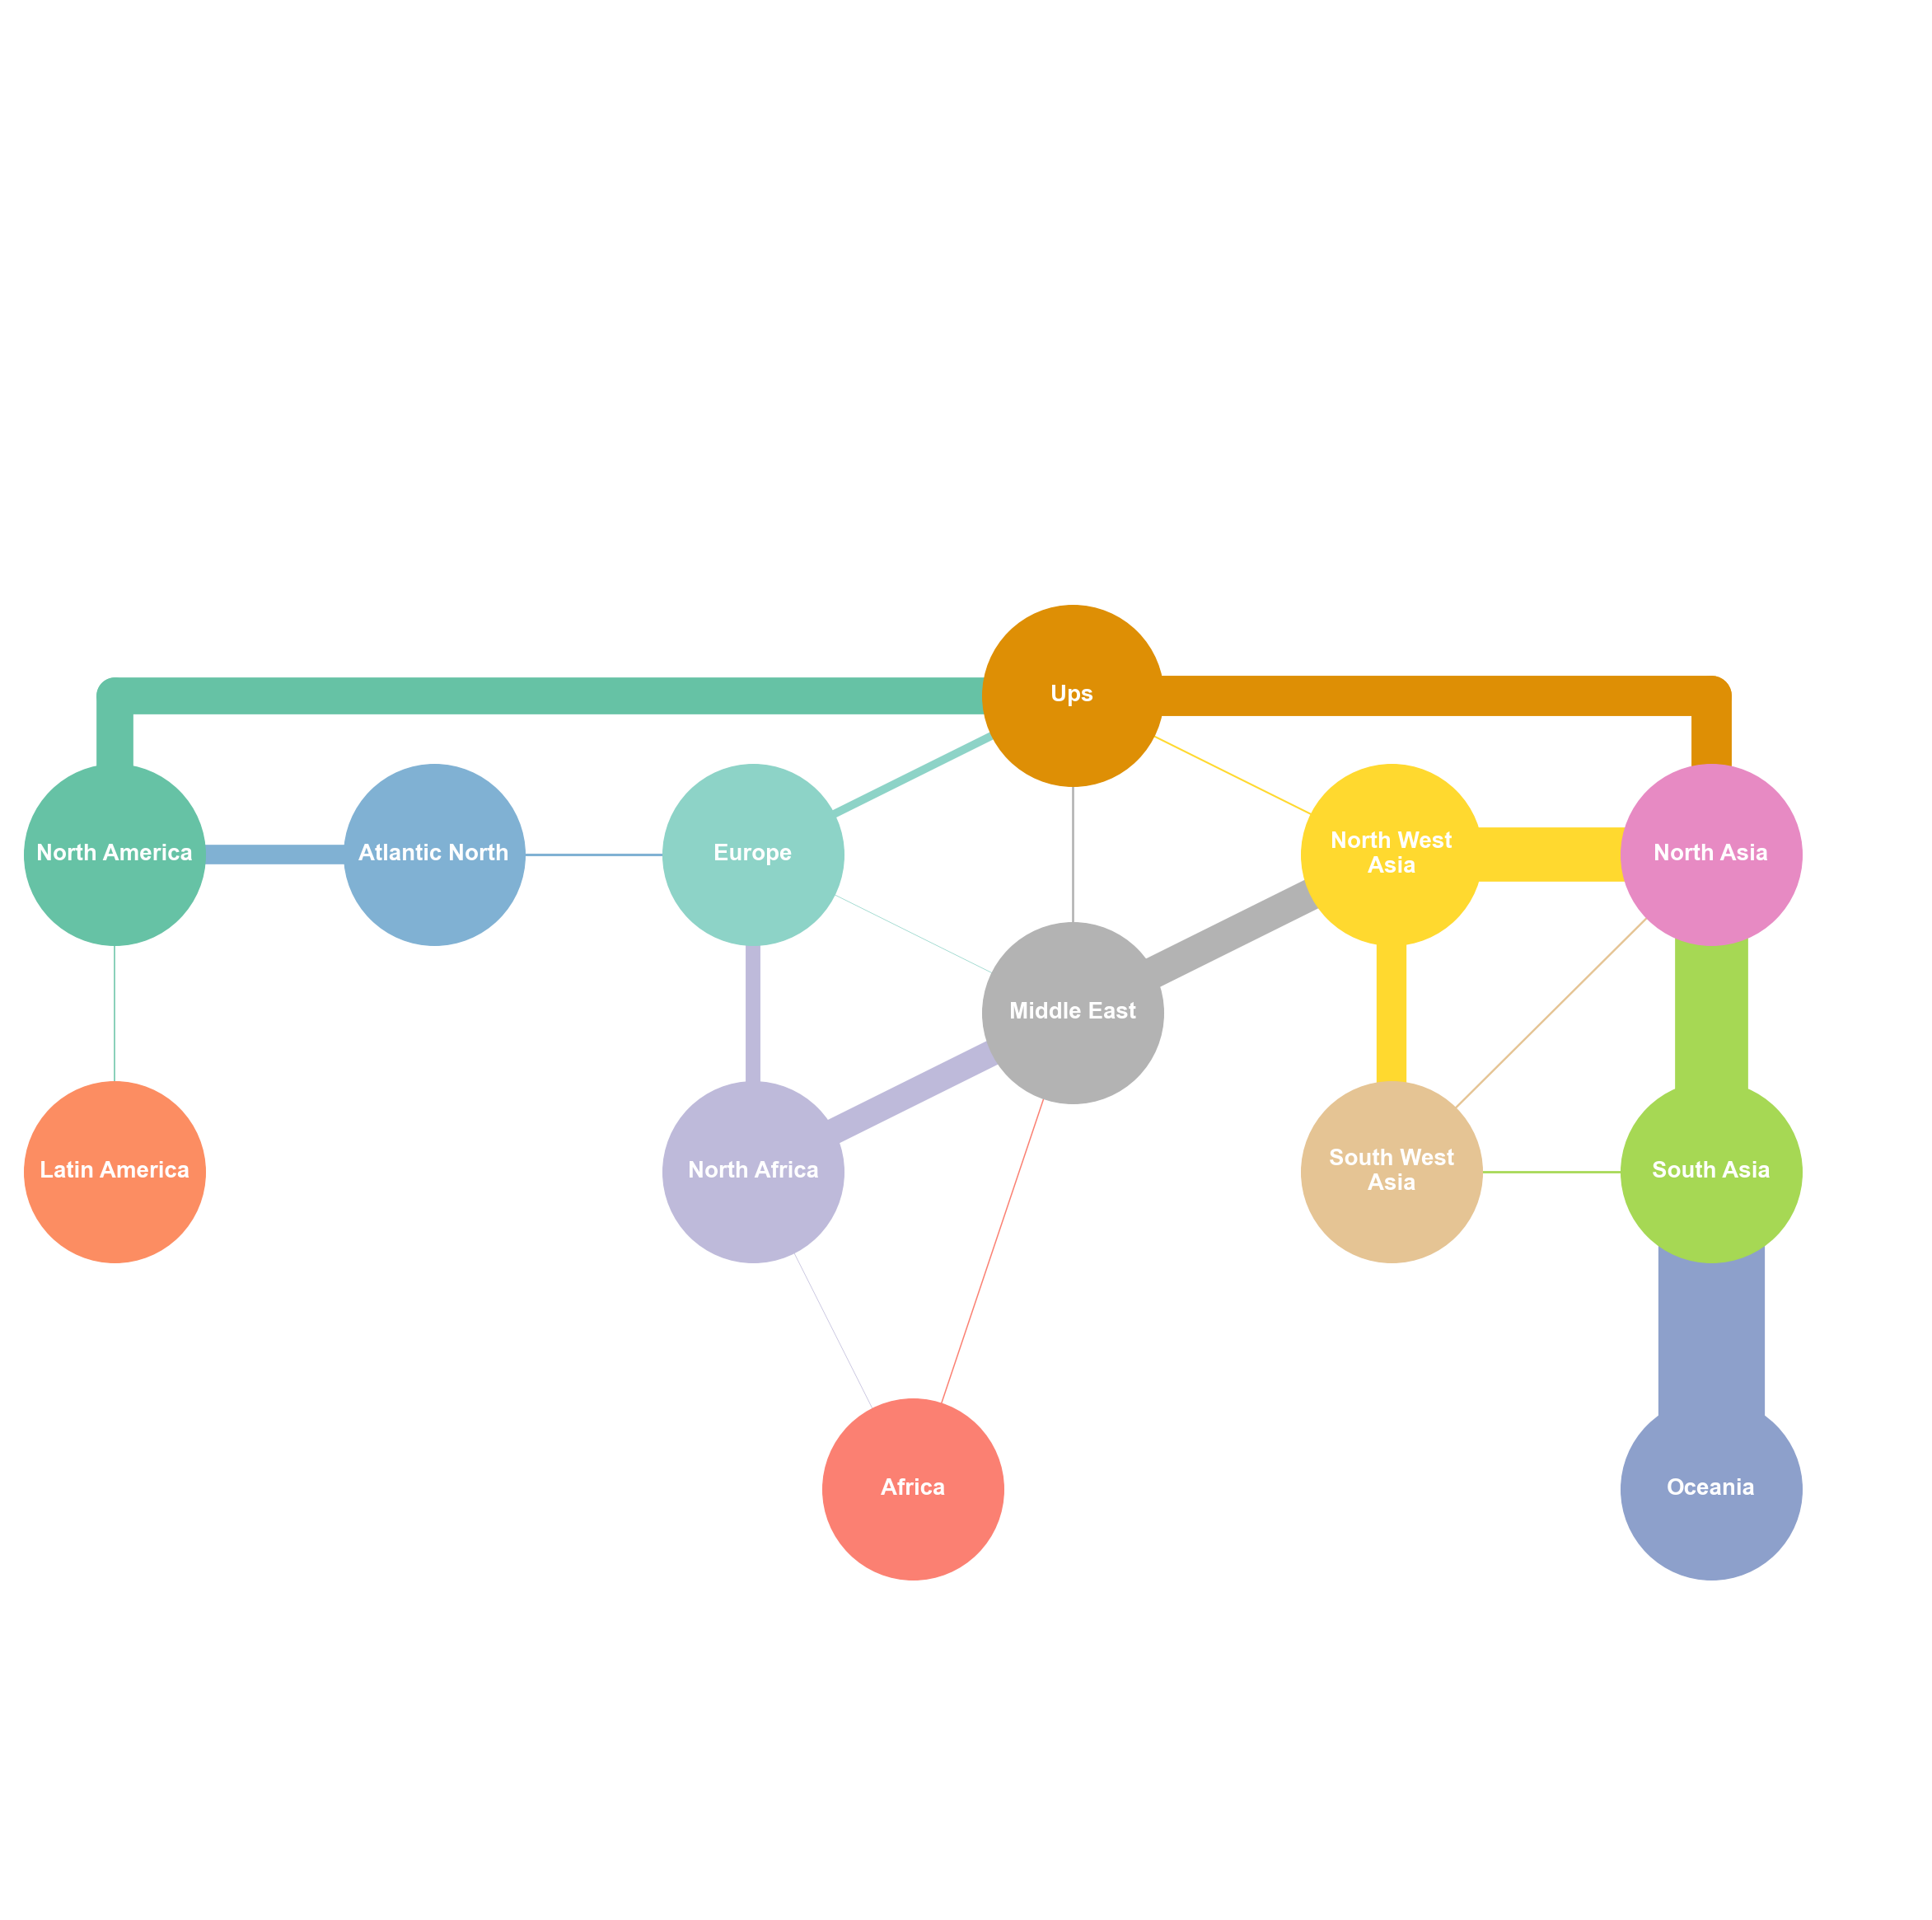

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np


mean_values = [netflows_links_series[key].mean() for (key, value) in netflows_links_series.items()]
std_values = [netflows_links_series[key].std() for (key, value) in netflows_links_series.items()]
plt.rc("figure", figsize=(30, 30))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Scale coordinates to fit the plot
scale = 5
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for i, (key, value) in enumerate(links_dic.items())}  


# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-3.5*scale, 5.5*scale)
ax.set_ylim(-3.5*scale, 5.5*scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=25000, color=region_colors[region_key_matched], zorder=5)
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=20, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.8e8, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        # Draw the L-shaped line for link 1_10
        ax.plot([-3*scale, -3*scale], [1.5*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([-3*scale, 1.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        # Draw the L-shaped line for link 4_10
        ax.plot([1.5*scale, 4.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([4.5*scale, 4.5*scale], [2.25*scale, 1.5*scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()


# **Checks**

## Check for constant deployed capacity

In [47]:
for key, value in regions_dic.items():
    wind_gen = n.generators_t.p[f"wind_{key}"] 
    pv_gen = n.generators_t.p[f"pv_{key}"]
    cap_wind = wind_gen / res_potential_dic[key]["wind"]
    cap_pv = pv_gen / res_potential_dic[key]["pv"]
    mean_wind = cap_wind.mean() * 100
    std_wind = cap_wind.std()
    mean_pv = cap_pv.mean() * 100
    std_pv = cap_pv.std()
    print(f'{key} wind: {round(mean_wind, 1)}%, {round(std_wind, 8)}')
    print(f'{key} pv: {round(mean_pv, 1)}%, {round(std_pv, 8)}')

north_america wind: 4.2%, 0.0
north_america pv: 3.2%, 0.00062637
latin_america wind: 22.9%, 0.0
latin_america pv: 1.1%, 0.0
oceania wind: 24.2%, 0.0
oceania pv: 15.8%, 0.0
north_asia wind: 46.3%, 0.0
north_asia pv: 0.0%, 0.0
south_asia wind: 100.0%, 0.0
south_asia pv: 0.0%, 0.0
north_west_asia wind: 25.6%, 0.0
north_west_asia pv: 0.9%, 0.0
south_west_asia wind: 100.0%, 0.0
south_west_asia pv: 0.0%, 0.0
middle_east wind: 68.9%, 0.0
middle_east pv: 0.0%, 0.0
europe wind: 12.0%, 0.0
europe pv: 0.0%, 0.0
ups wind: 0.2%, 0.0
ups pv: 0.7%, 0.00016791
north_africa wind: 19.5%, 0.0
north_africa pv: 13.3%, 0.0
africa wind: 14.0%, 0.0
africa pv: 0.2%, 0.0
atlantic_north wind: 5.2%, 0.0
atlantic_north pv: 0.0%, 0.0


# **Investigation of specific events**

## Highest transmission losses

In [48]:
index = hourly_losses_rel_to_gen.idxmax()
max_value = hourly_losses_rel_to_gen.max()
print("Index of the maximum value:", index)
print("Maximum value:", max_value)

for key, value in regions_dic.items():
    value[f'gen_max_losses'] = (n.generators_t.p[f"wind_{key}"][index] + n.generators_t.p[f"pv_{key}"][index]) * 1e-3
    value[f'load_max_losses'] = n.loads_t.p[f"load_{key}"][index] * 1e-3
    value[f'cur_max_losses'] = n.generators_t.p[f"curtailment_{key}"][index] * 1e-3

Index of the maximum value: 2050-02-05 15:00:00
Maximum value: 0.08607807718921479


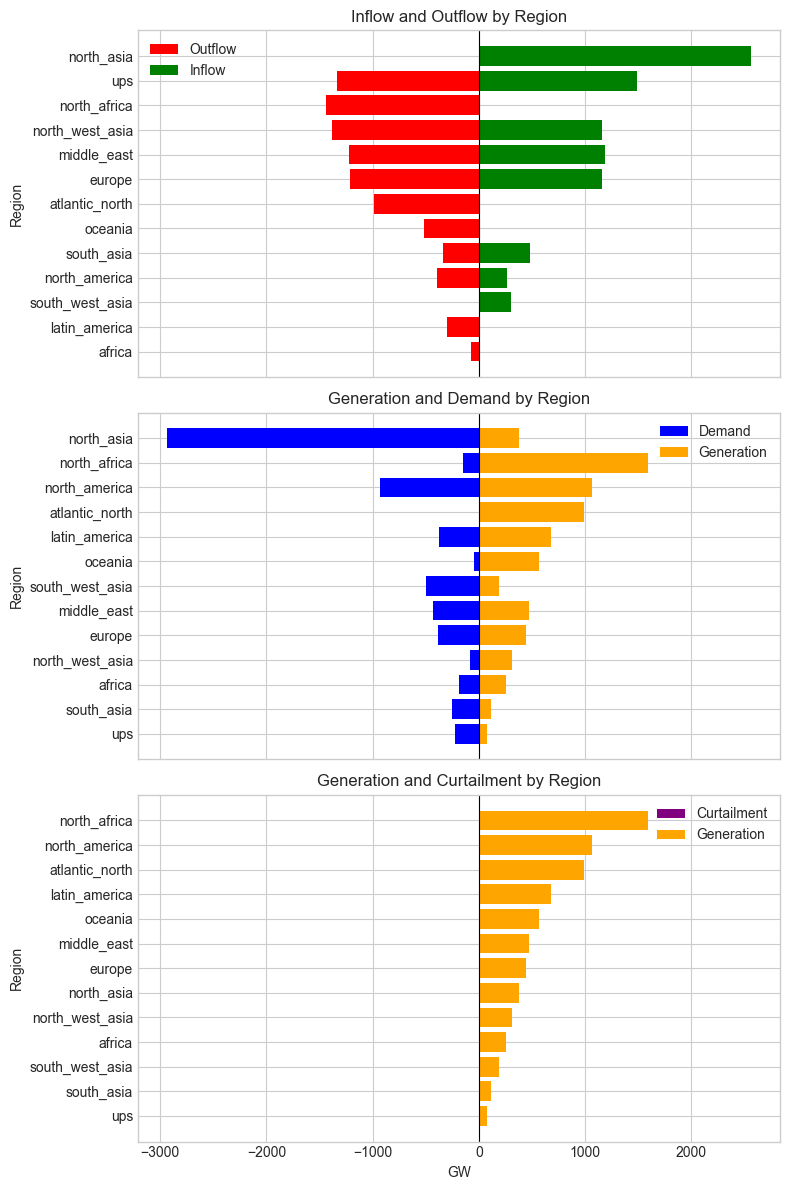

In [49]:
inflow_outflow_data = [
    (region_key, region_value['inflow_series'][index], region_value['outflow_series'][index])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_demand_data = [
    (region_key, region_value['gen_max_losses'], region_value['load_max_losses'])
    for region_key, region_value in regions_dic.items()
]
generation_demand_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_curtailment_data = [
    (region_key, region_value['gen_max_losses'], region_value['cur_max_losses'])
    for region_key, region_value in regions_dic.items()
]
generation_curtailment_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1] for item in inflow_outflow_data]
outflows = [item[2] for item in inflow_outflow_data]

regions_generation_demand = [item[0] for item in generation_demand_data]
generations_demand = [item[1] for item in generation_demand_data]
demands = [item[2] for item in generation_demand_data]

regions_generation_curtailment = [item[0] for item in generation_curtailment_data]
generations_curtailment = [item[1] for item in generation_curtailment_data]
curtailments = [item[2] for item in generation_curtailment_data]

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

axs[0].barh(regions_inflow_outflow, [-outflow for outflow in outflows], color='red', label='Outflow')
axs[0].barh(regions_inflow_outflow, inflows, color='green', label='Inflow')
axs[0].axvline(x=0, color='black', linewidth=0.8)
axs[0].set_ylabel('Region')
axs[0].set_title('Inflow and Outflow by Region')
axs[0].grid(True, axis='x')
axs[0].legend()
axs[0].invert_yaxis()

axs[1].barh(regions_generation_demand, [-demand for demand in demands], color='blue', label='Demand')
axs[1].barh(regions_generation_demand, generations_demand, color='orange', label='Generation')
axs[1].axvline(x=0, color='black', linewidth=0.8)
axs[1].set_ylabel('Region')
axs[1].set_title('Generation and Demand by Region')
axs[1].grid(True, axis='x')
axs[1].legend()
axs[1].invert_yaxis()

axs[2].barh(regions_generation_curtailment, [-curtailment for curtailment in curtailments], color='purple', label='Curtailment')
axs[2].barh(regions_generation_curtailment, generations_curtailment, color='orange', label='Generation')
axs[2].axvline(x=0, color='black', linewidth=0.8)
axs[2].set_xlabel('GW')
axs[2].set_ylabel('Region')
axs[2].set_title('Generation and Curtailment by Region')
axs[2].grid(True, axis='x')
axs[2].legend()
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()

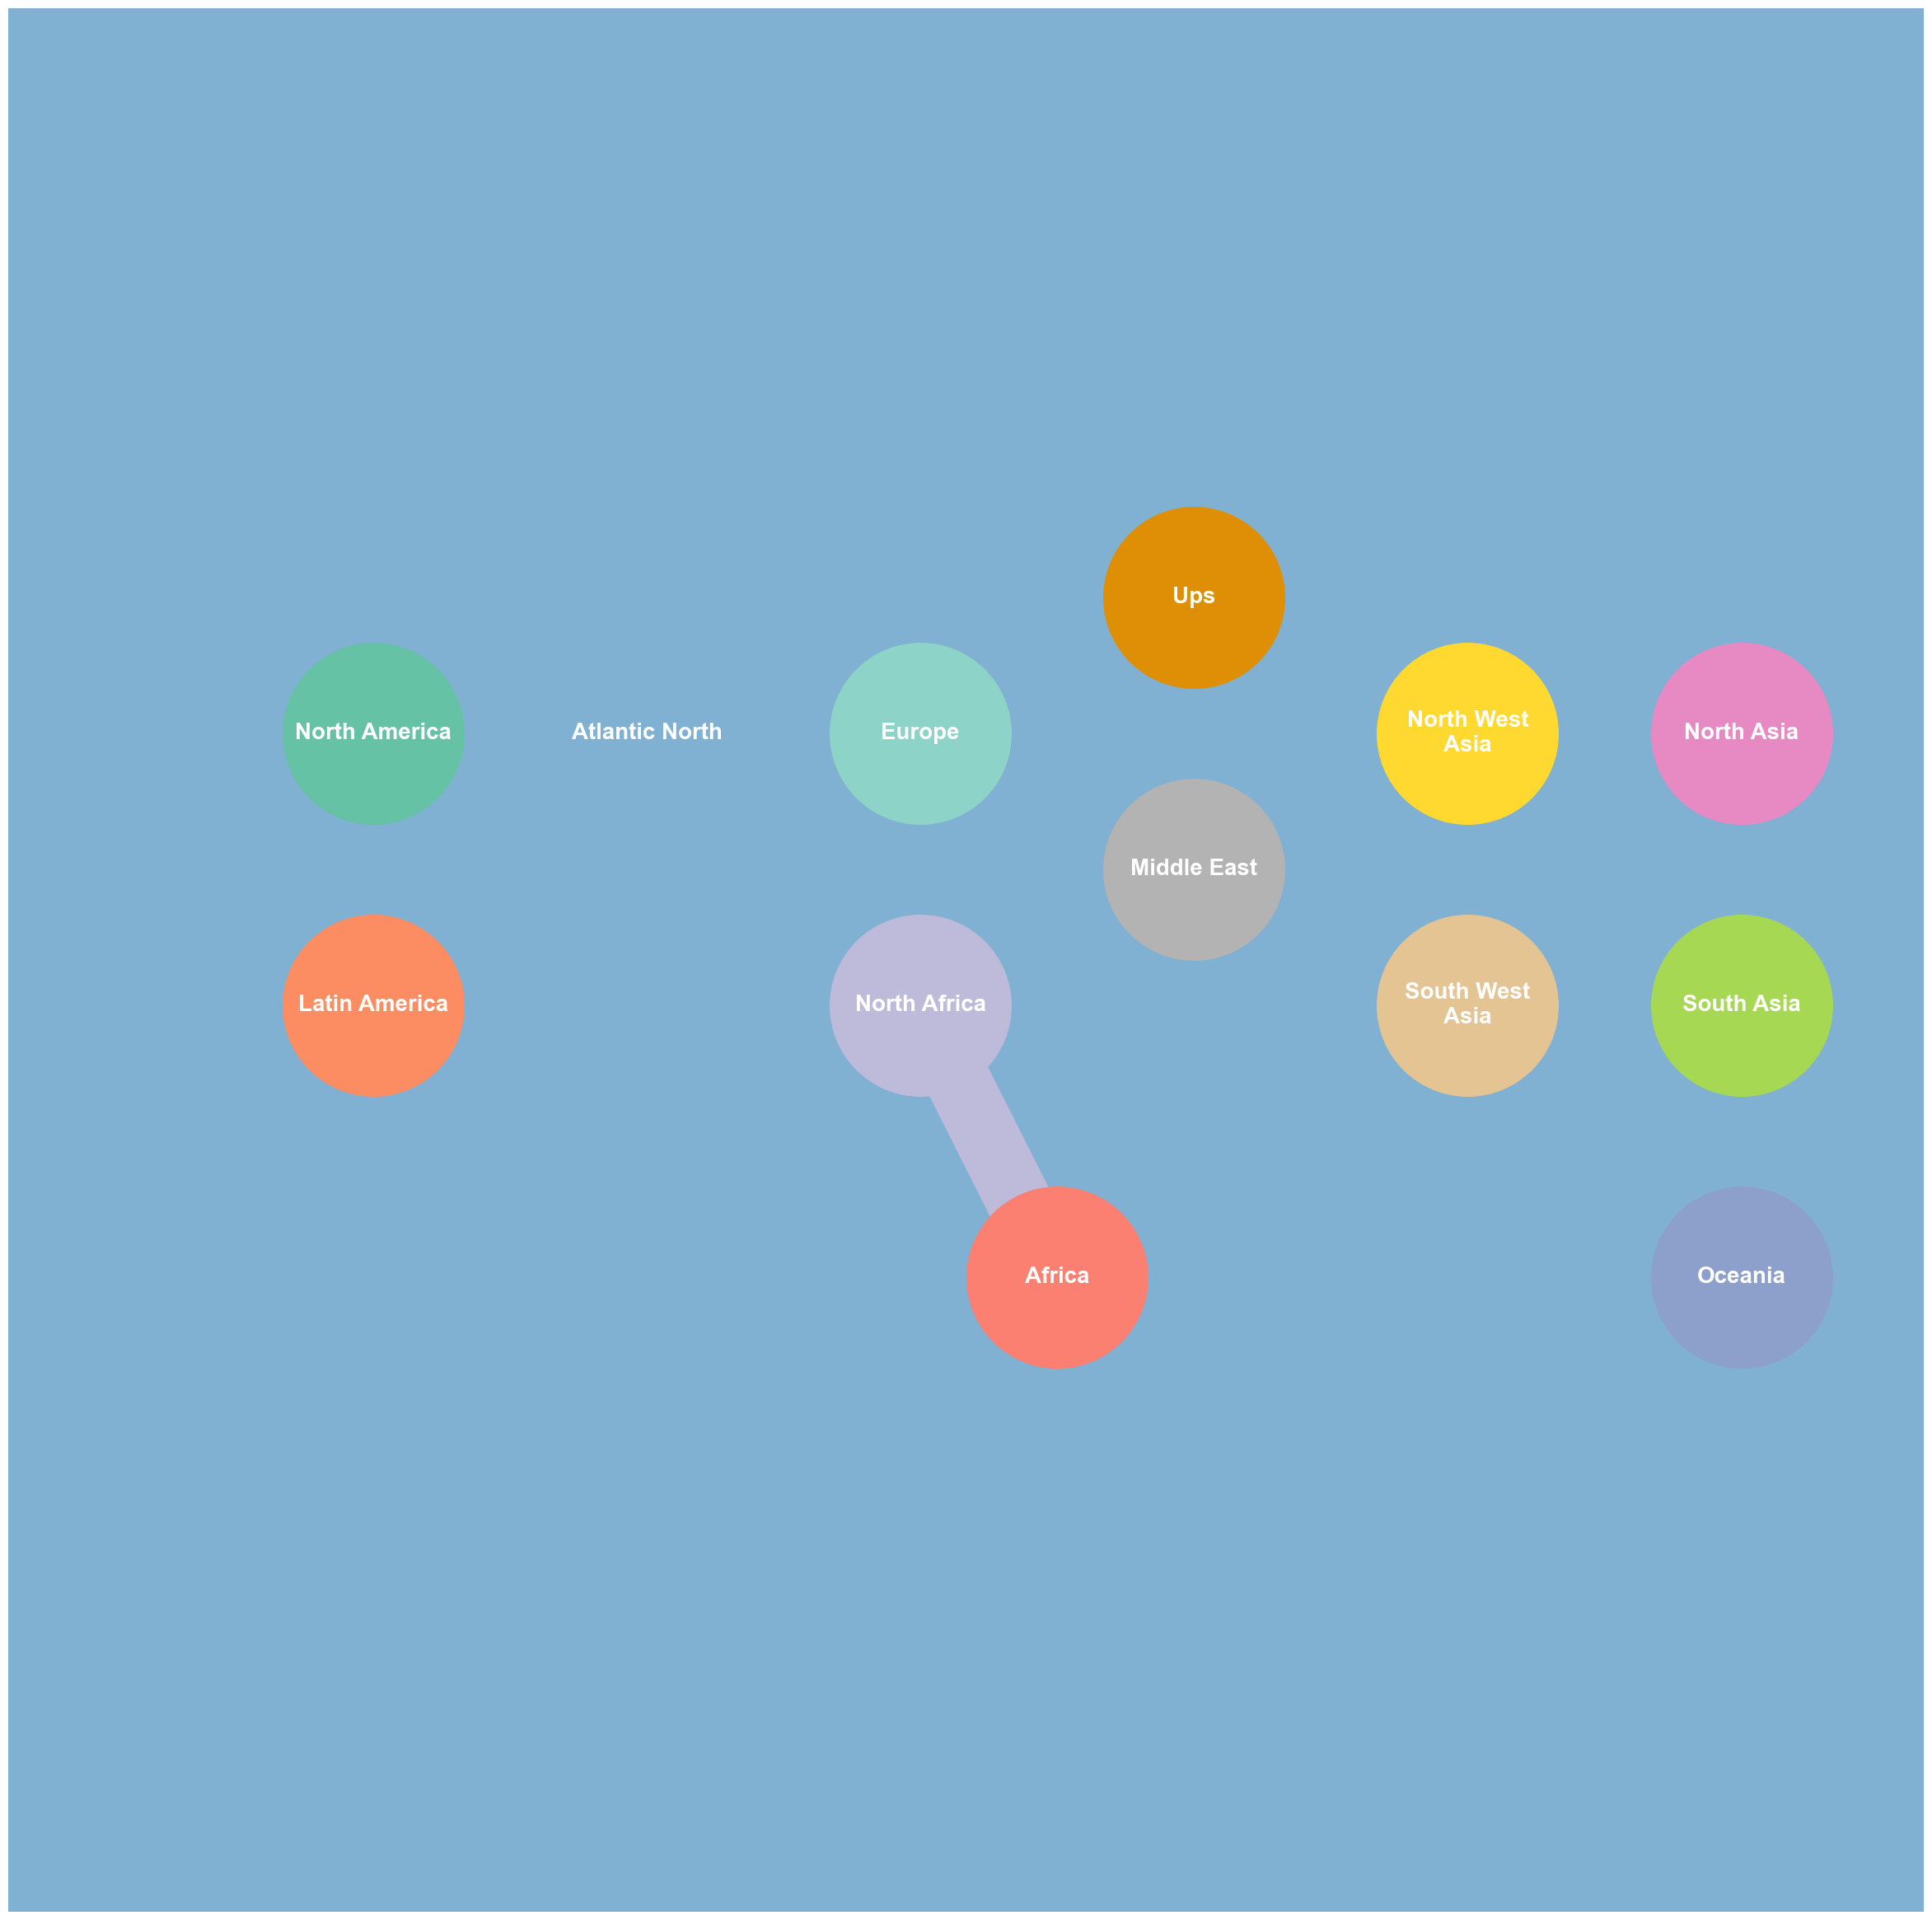

In [50]:
plt.rc("figure", figsize=(30, 30))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Scale coordinates to fit the plot
scale = 7
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for i, (key, value) in enumerate(links_dic.items())}  # Example values for color


# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-5*scale, 5.5*scale)
ax.set_ylim(-5*scale, 5.5*scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=25000, color=region_colors[region_key_matched], zorder=5)
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=20, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 1.2e4, 0.1)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        # Draw the L-shaped line for link 1_10
        ax.plot([-3*scale, -3*scale], [1.5*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([-3*scale, 1.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        # Draw the L-shaped line for link 4_10
        ax.plot([1.5*scale, 4.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([4.5*scale, 4.5*scale], [2.25*scale, 1.5*scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()


## Curtailment in Atlantic North

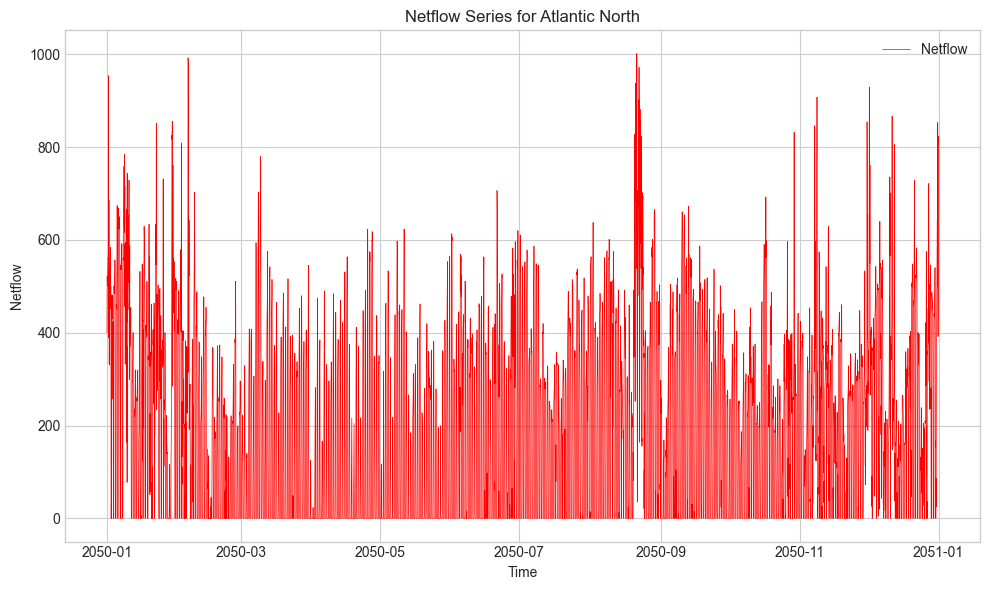

In [51]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
#plt.scatter(difference.index, difference.values, label='Netflow', color='blue', s=5)
#plt.scatter(curtailment_series.index, curtailment_series.values, label='Curtailment', color='red', s=5)
plt.plot(netflow_series.index, netflow_series.values, label='Netflow', color='red', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

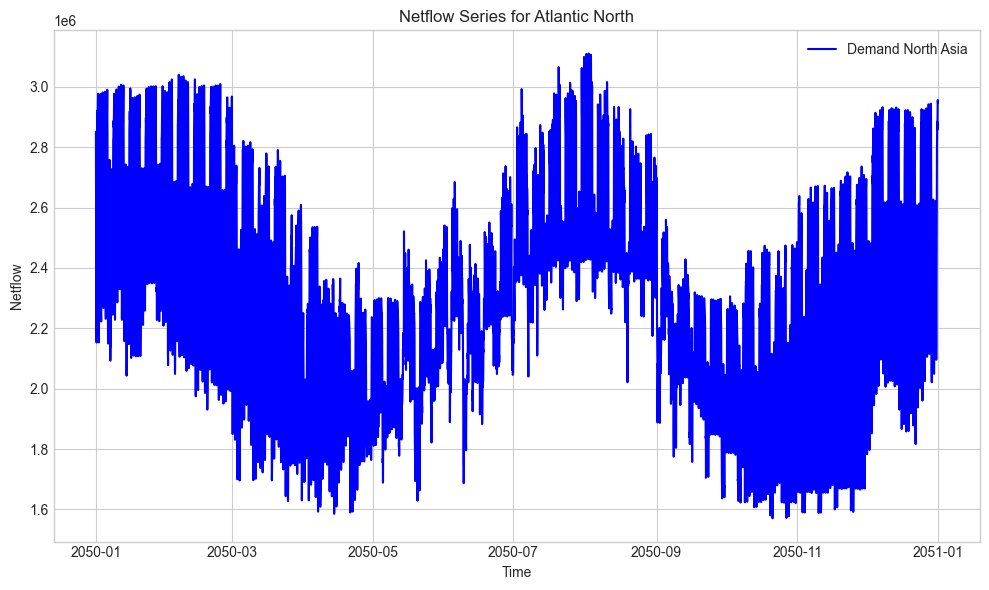

In [52]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(demand_series_north_asia.index, demand_series_north_asia.values, label='Demand North Asia', color='blue')
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Availability of VRE**

# Temporal availability

## Scatter plot of supply over demand 

In [21]:
tolerance = 1e-3 # tolerance for numerical inaccuracies
demand = 0
supply = 0
for key, value in regions_dic.items():
    demand += n.loads_t.p[f'load_{key}'] * 1e-3 #GW
    supply += (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'] + n.generators_t.p[f'curtailment_{key}']) * 1e-3 - value['netflow_series'] 
demand_supply_ratio = supply / (demand - tolerance)

fig, ax = plt.subplots(figsize=(12,6))


ax.scatter(demand_supply_ratio.index, demand_supply_ratio.values, s=2, color='blue', alpha=0.6, label='Supply/Demand Ratio')

ax.set_xlabel('Time')
ax.set_ylabel('Supply over demand')
ax.set_yscale('log')
#ax.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



KeyError: 'netflow_series'

# **Curtailment**

## Scatter plot global with all the regions

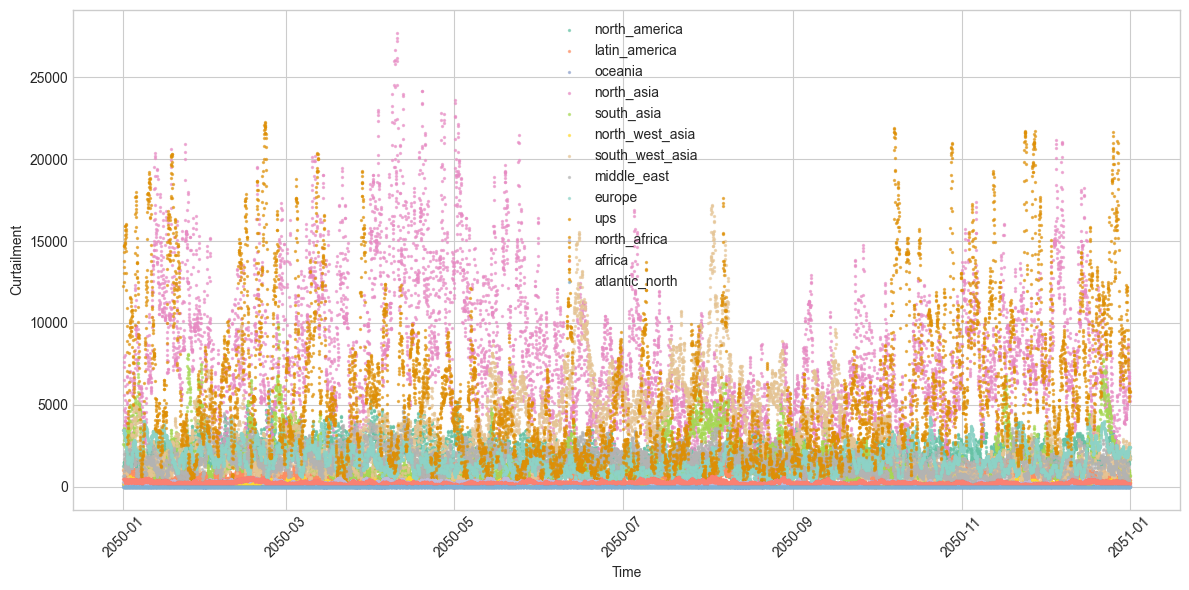

In [24]:
tolerance = 1e-3 # tolerance for numerical inaccuracies
curtailment = {}
for key, value in regions_dic.items():
    curtailment[key] =  n.generators_t.p[f'curtailment_{key}'] * 1e-3 


fig, ax = plt.subplots(figsize=(12,6))
for key, value in curtailment.items():
    color_ = region_colors[key]
    ax.scatter(value.index, value.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Curtailment')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

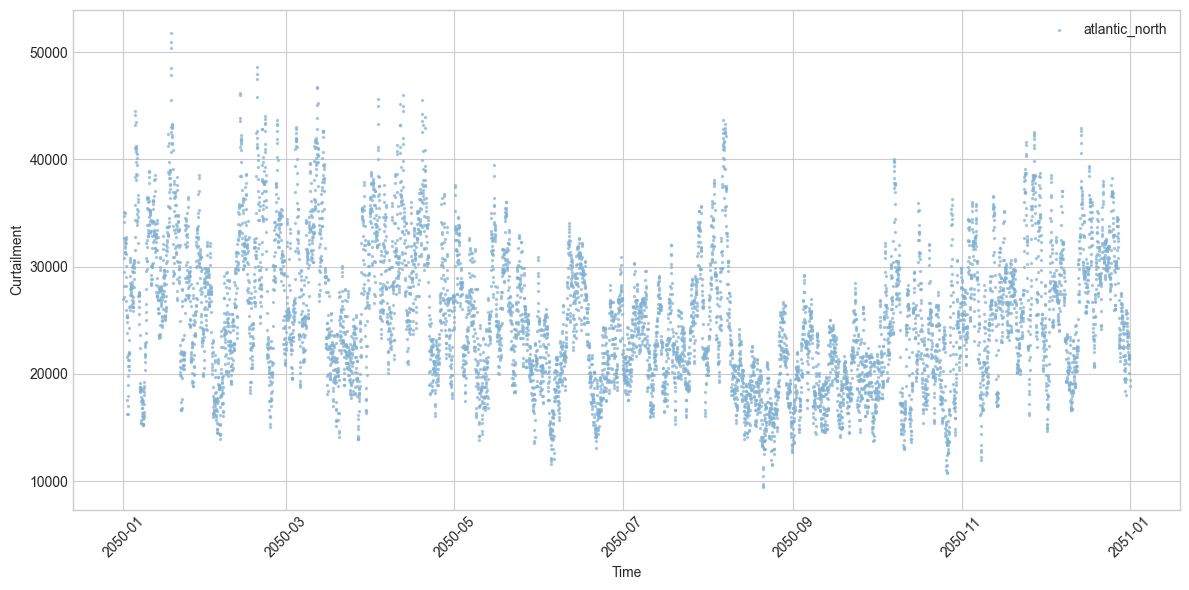

In [23]:
tolerance = 1e-3 # tolerance for numerical inaccuracies
curtailment = 0
for key, value in regions_dic.items():
    curtailment +=  n.generators_t.p[f'curtailment_{key}'] * 1e-3 

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(curtailment.index, curtailment.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Curtailment')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scatter plot atlantic north

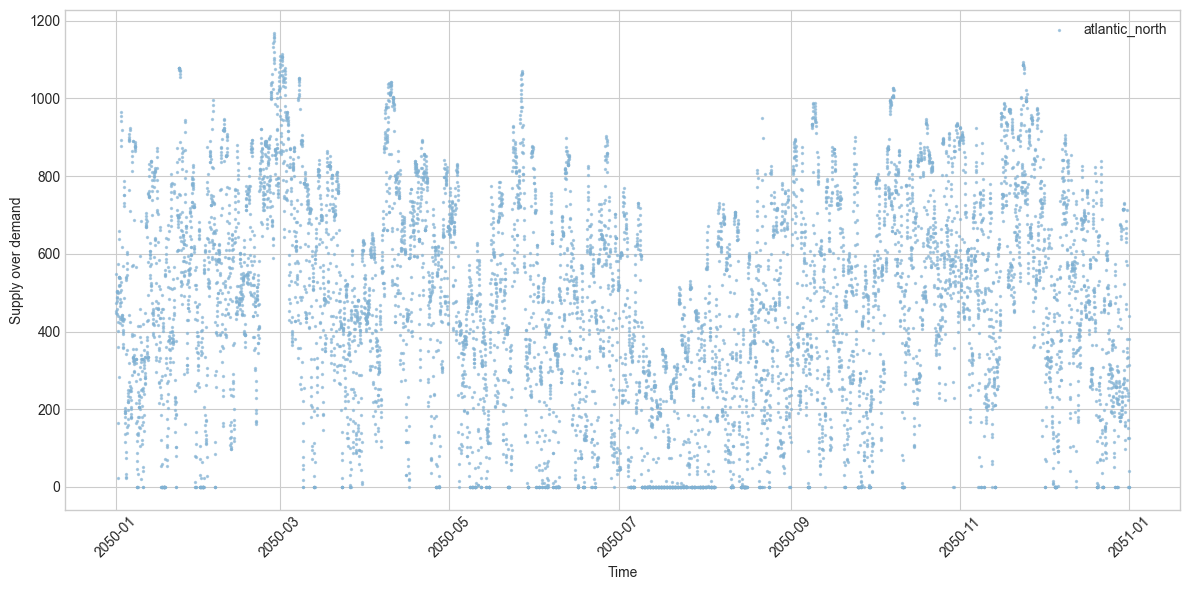

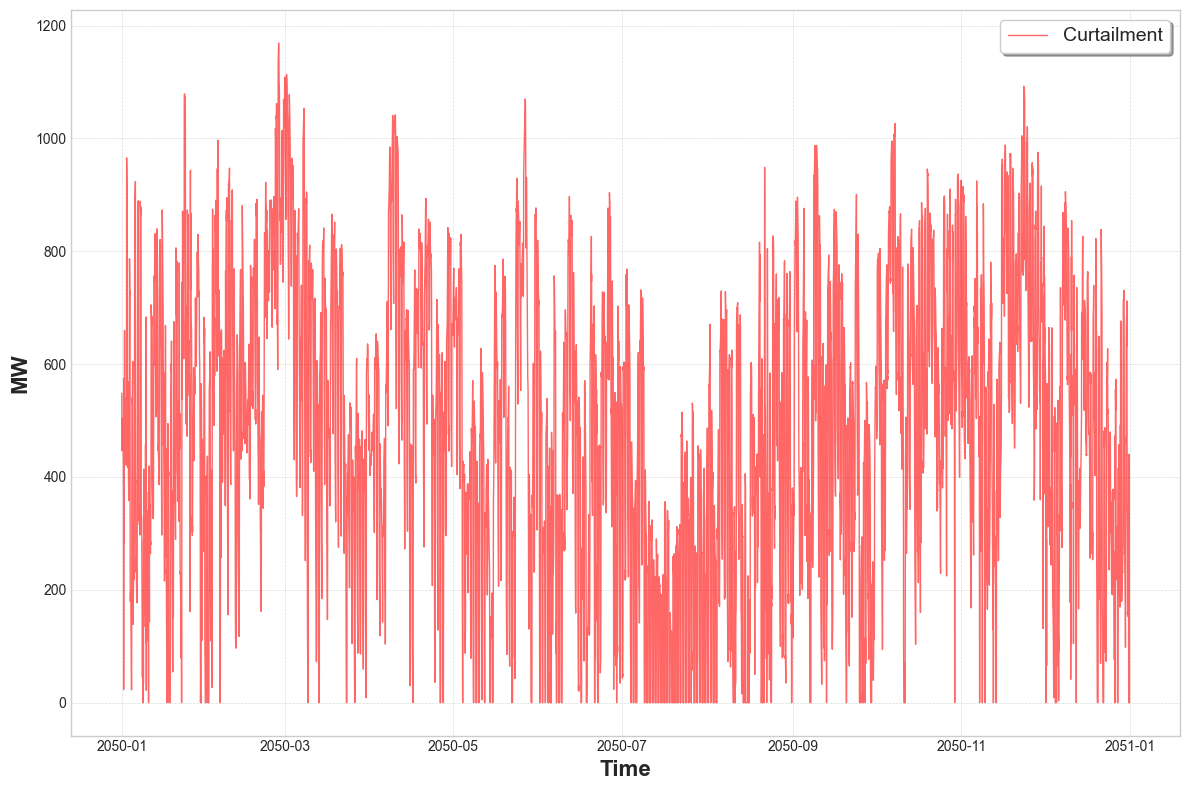

In [55]:
# Graph
region = 'atlantic_north'
series = curtailment[region]
fig, ax = plt.subplots(figsize=(12,6))
color_ = region_colors[region]
ax.scatter(series.index, series.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Supply over demand')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))  
plt.plot(series.index, series.values, label='Curtailment', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('MW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

## Time series generation vs demand North Asia

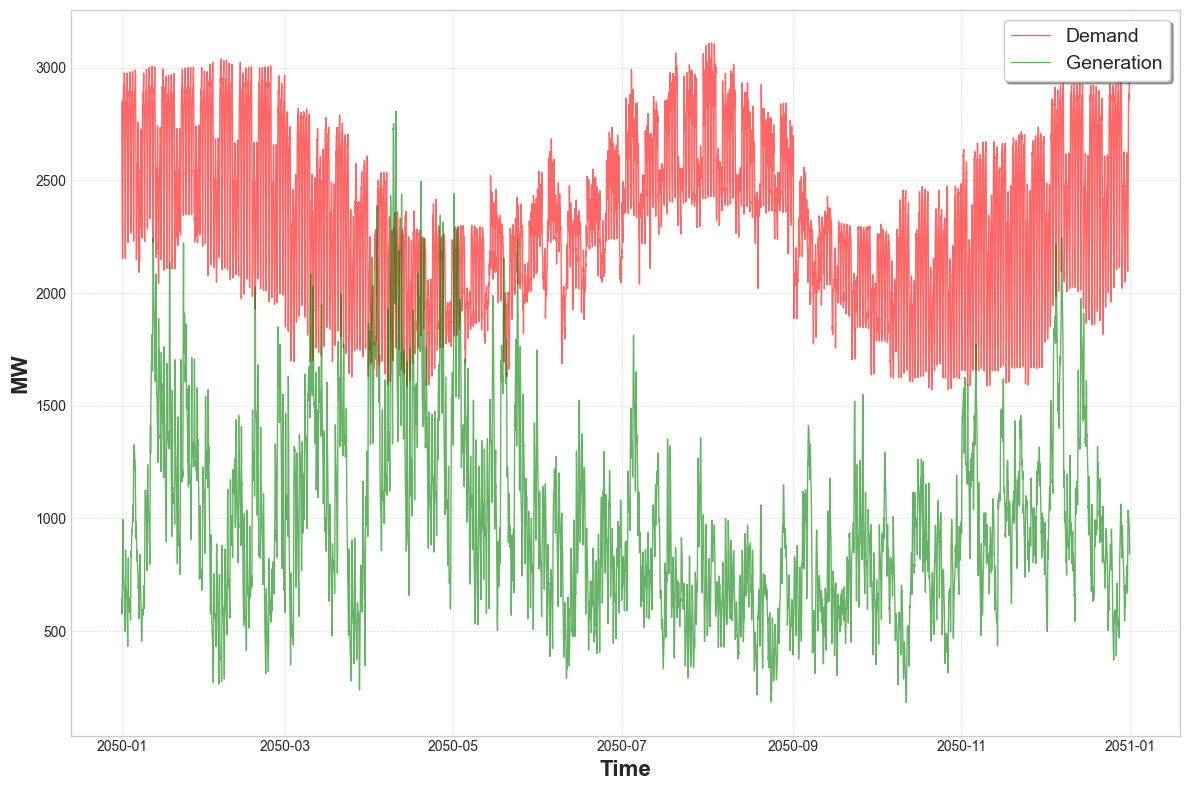

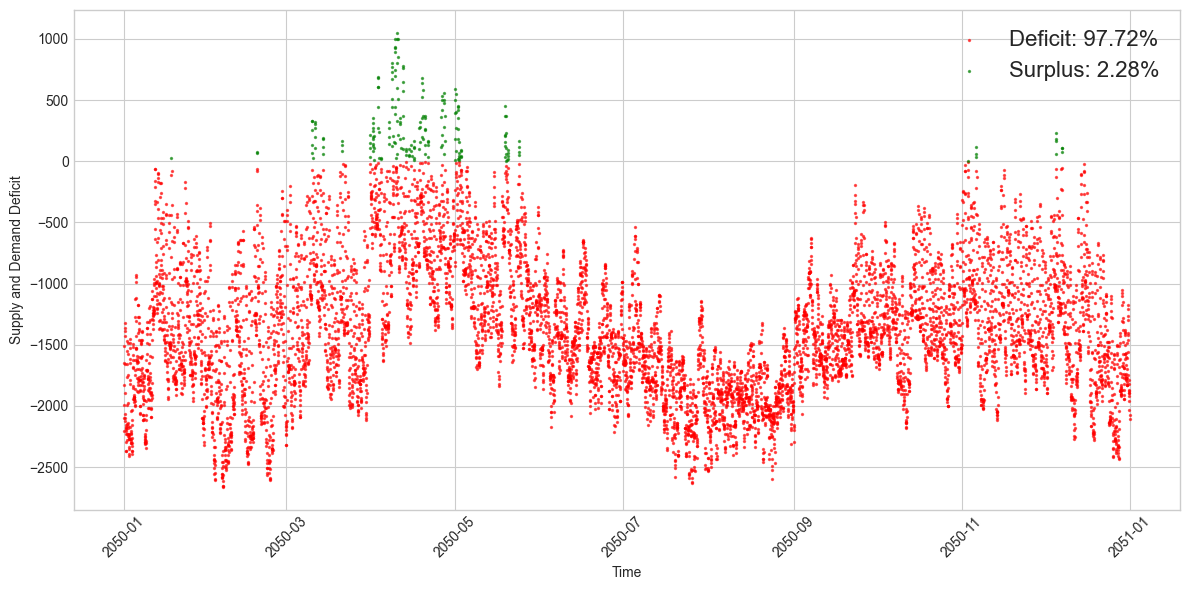

In [56]:
demand_north_asia = n.loads_t.p[f'load_north_asia'] * 1e-3
gen_north_asia = (n.generators_t.p['wind_north_asia'] + n.generators_t.p['pv_north_asia']) * 1e-3
deficit = gen_north_asia - demand_north_asia

# Graph
plt.figure(figsize=(12, 8))  
plt.plot(demand_north_asia.index, demand_north_asia.values, label='Demand', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.plot(gen_north_asia.index, gen_north_asia.values, label='Generation', color='green', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('MW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

# scatter plot
# Calculate percentages
total_points = len(deficit)
points_above_zero = (deficit > 0).sum()
points_below_zero = (deficit <= 0).sum()

percentage_above_zero = (points_above_zero / total_points) * 100
percentage_below_zero = (points_below_zero / total_points) * 100

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot points below zero in red
ax.scatter(deficit[deficit <= 0].index, deficit[deficit <= 0].values, s=2, color='red', alpha=0.6, label=f'Deficit: {percentage_below_zero:.2f}%')

# Plot points above zero in green
ax.scatter(deficit[deficit > 0].index, deficit[deficit > 0].values, s=2, color='green', alpha=0.6, label=f'Surplus: {percentage_above_zero:.2f}%')

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Supply and Demand Deficit')
ax.set_yscale('linear')
ax.legend(fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time series inflow north asia 

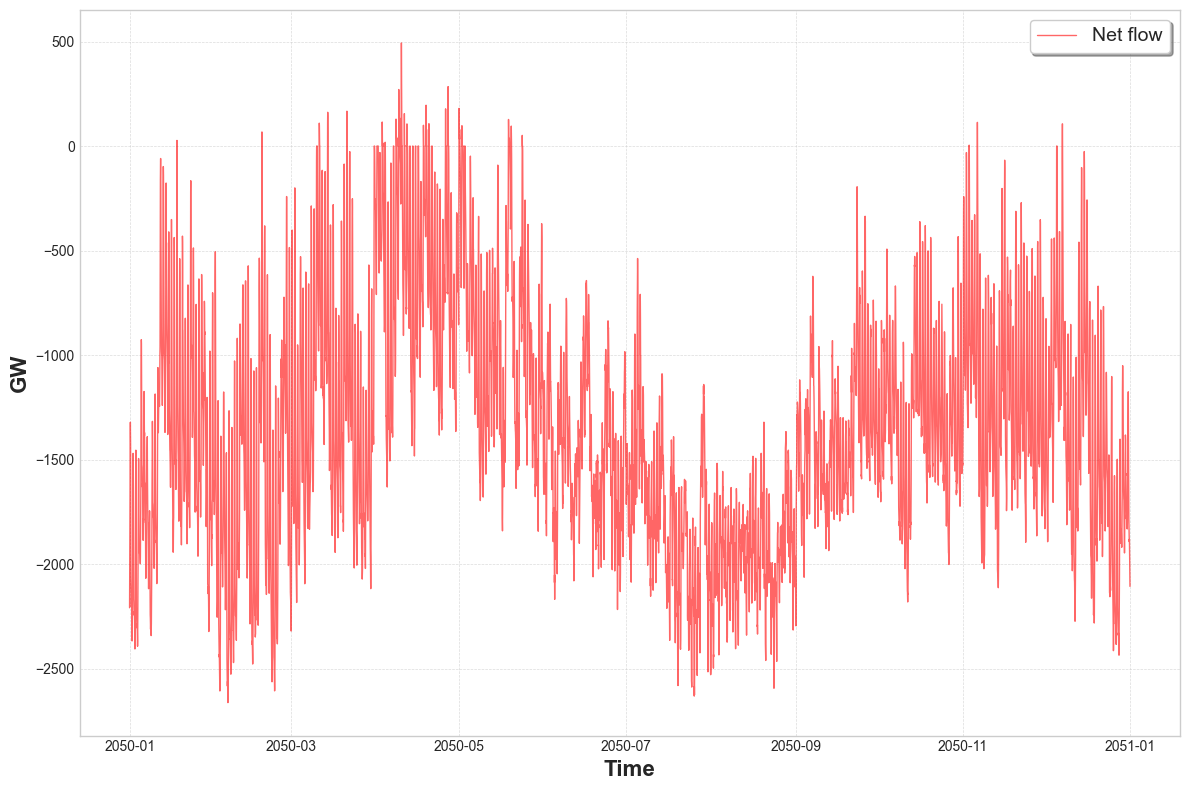

In [57]:
inflow_north_asia = regions_dic['north_asia']['netflow_series']

# Graph
plt.figure(figsize=(12, 8))  
plt.plot(inflow_north_asia.index, inflow_north_asia.values, label='Net flow', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('GW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

## Fourier series generation vs demand North Asia

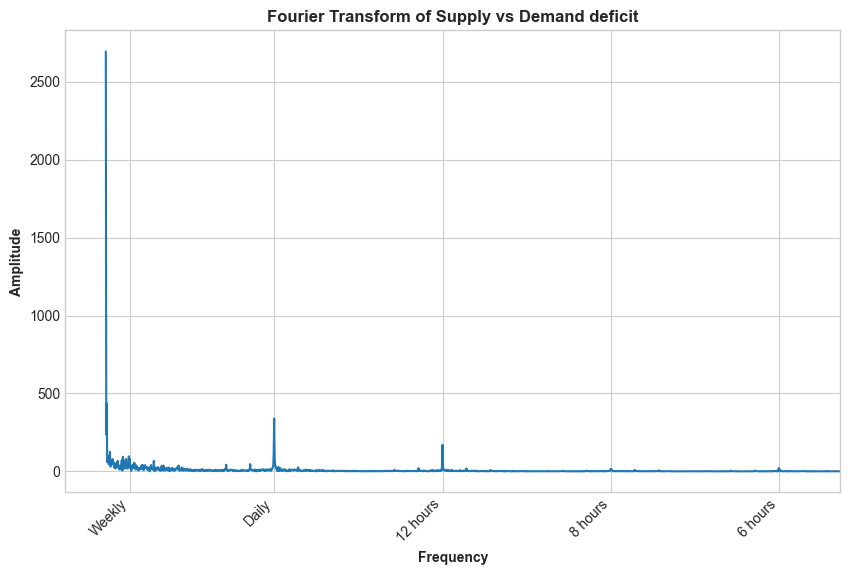

In [58]:
# Convert to numpy array
hourly_p_trans_rel_gen_array = deficit.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()


## Fourier series inflow north asia

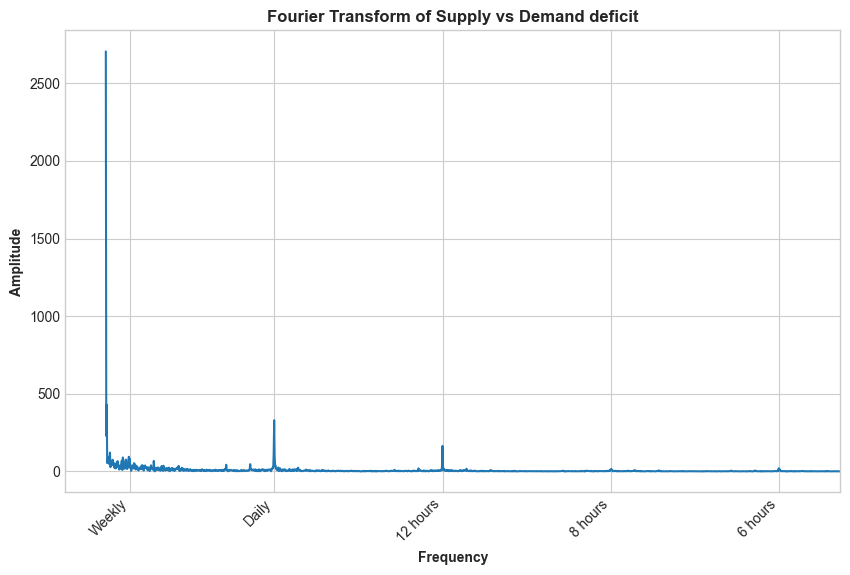

In [59]:
# Convert to numpy array
hourly_p_trans_rel_gen_array = inflow_north_asia.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

## Fourier series VRE potential atlantic north

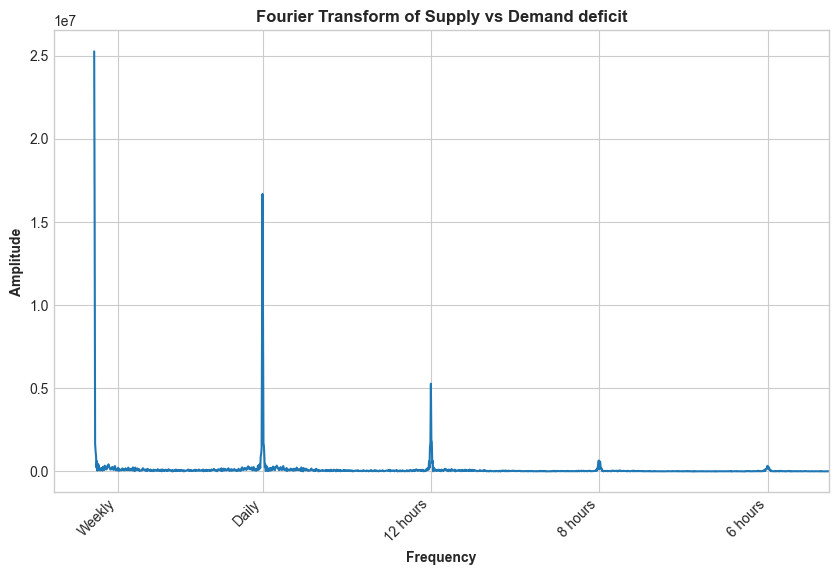

In [60]:
# Convert to numpy array
series = res_potential_dic['atlantic_north']['pv']
hourly_p_trans_rel_gen_array = series.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

## Correlation Matrix of VRE potentials vs Demand 

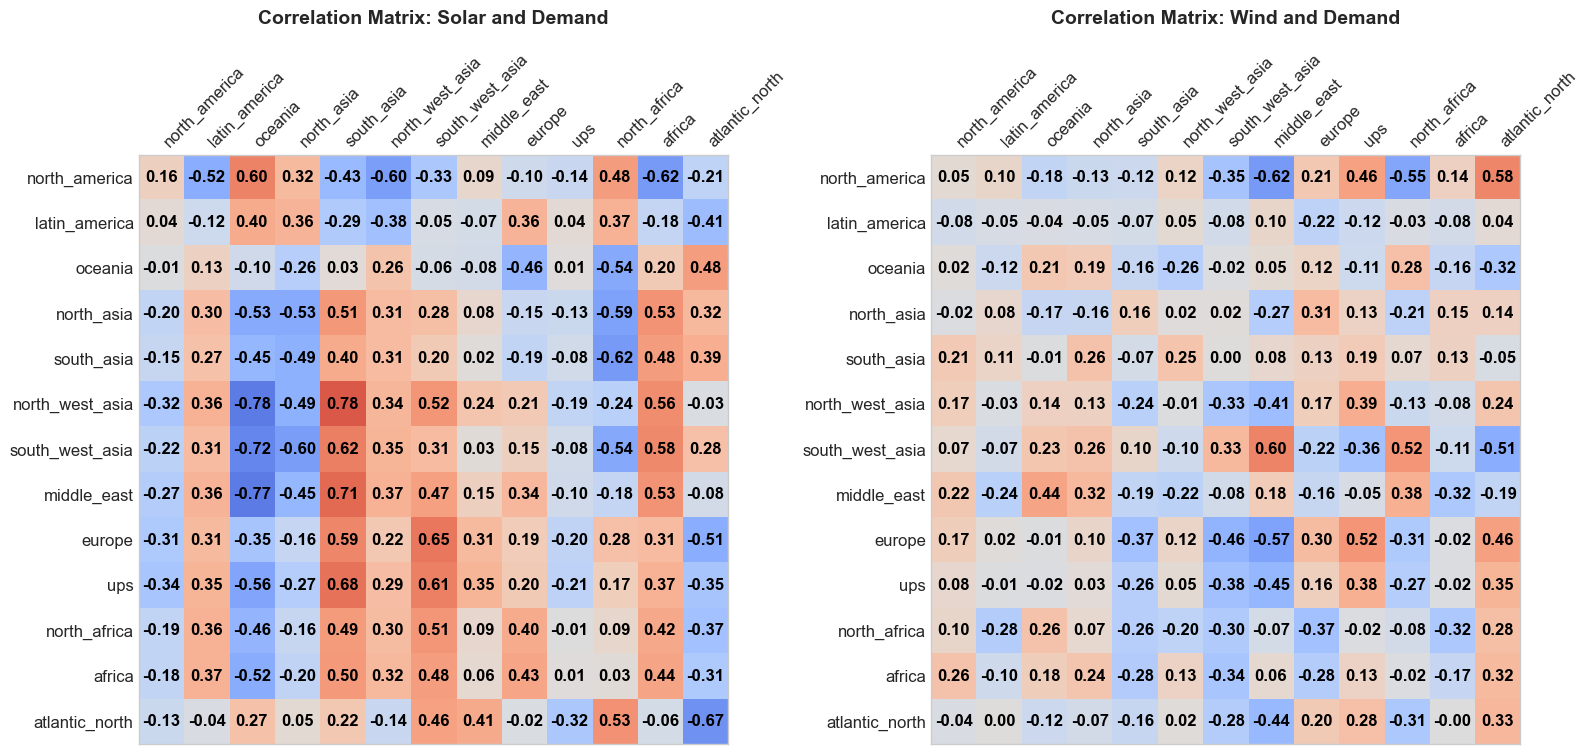

In [61]:
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})


regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        correlation_matrix1.loc[i, j] = data1[i].corr(demand[j])
        correlation_matrix2.loc[i, j] = data2[i].corr(demand[j])

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()


/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



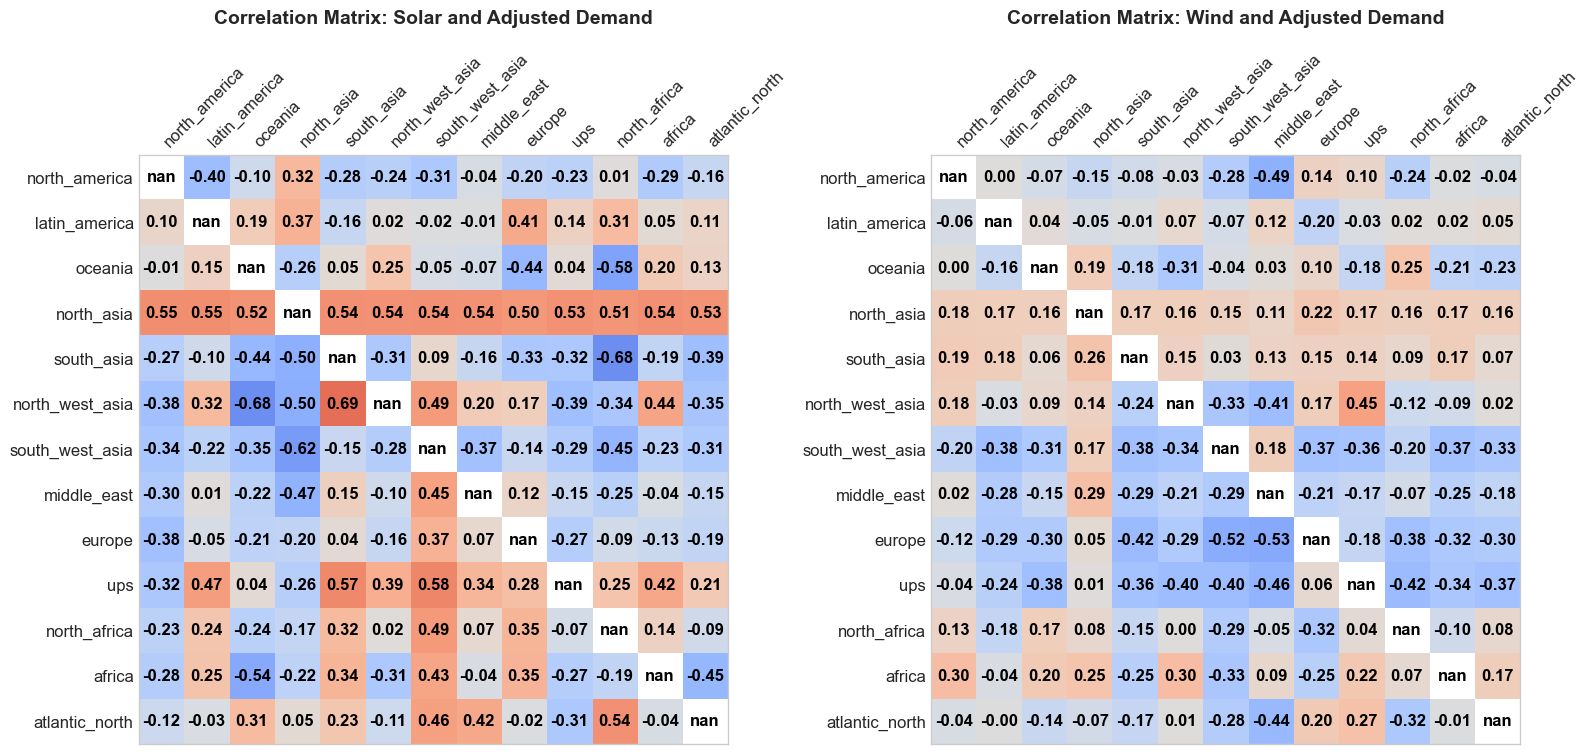

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})

regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        adjusted_demand_j = demand[j] - demand[i]
        correlation_matrix1.loc[i, j] = data1[i].corr(adjusted_demand_j)
        correlation_matrix2.loc[i, j] = data2[i].corr(adjusted_demand_j)

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


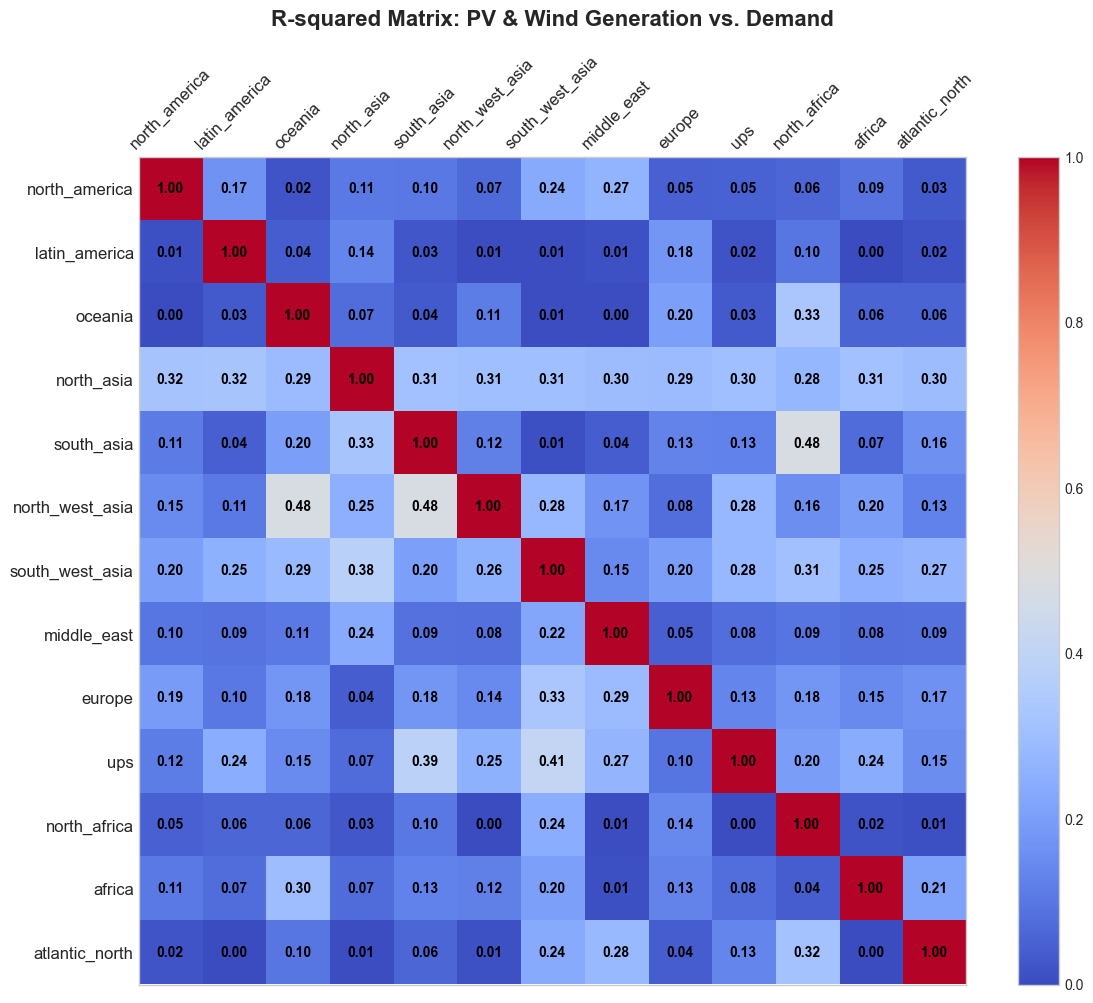

In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})

regions = list(regions_dic.keys())
num_regions = len(regions)

# Initialize the R-squared matrix
r_squared_matrix = np.zeros((num_regions, num_regions))

# Loop through each region's demand and each region's PV and wind
for i, region_demand in enumerate(regions):

    for j, region_generation in enumerate(regions):
        y = demand[region_demand].values - demand[region_generation].values      
        X = np.vstack([data1[region_generation].values, data2[region_generation].values]).T
        model = LinearRegression().fit(X, y)
        r_squared = model.score(X, y)
        r_squared_matrix[j, i] = r_squared

# Convert R-squared matrix to DataFrame for better readability
r_squared_df = pd.DataFrame(r_squared_matrix, index=regions, columns=regions)

# Plot the R-squared matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Display the matrix values with reversed colormap
cax = ax.matshow(r_squared_df, cmap='coolwarm', vmin=0, vmax=1)

# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(r_squared_df.columns)))
ax.set_yticks(range(len(r_squared_df.index)))
ax.set_xticklabels(r_squared_df.columns, rotation=45, fontsize=12)
ax.set_yticklabels(r_squared_df.index, fontsize=12)

# Add text annotations
for i in range(len(r_squared_df.columns)):
    for j in range(len(r_squared_df.index)):
        plt.text(i, j, f'{r_squared_df.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')

# Title and layout adjustments
plt.title('R-squared Matrix: PV & Wind Generation vs. Demand', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(cax)
plt.tight_layout()
plt.show()
